In [65]:
# %load_ext autoreload
# %autoreload 2 
# from utils import *
# from Network import *
# basic packages
import numpy as np
import glob
# import h5py
import math
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
import os
import copy
import time
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision.transforms import ToTensor
#from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm
import sys
# sys.path.append('/scratch/xc1490/projects/tmp/python_packages')
import wandb
wandb.__version__

'0.16.1'

In [ ]:
os.environ['WANDB_DISABLE_SERVICE'] = 'True'

In [ ]:
# !wandb login

In [ ]:
#!pip install --target=/home/xc1490/home/projects/tmp/python_packages wandb
#!pip install --target=/home/xc1490/home/projects/tmp/python_packages click

In [66]:
class FoVDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_data[idx])
        y = torch.tensor(self.y_data[idx])
        return x,y

def a_norm(Q, K, mask = None):
    m = torch.matmul(Q, K.transpose(2,1).float())
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float())
    
    
    if mask is not None:
        m.masked_fill(mask == 0, float("-1e20"))
    
    return torch.softmax(m , -1) #(batch_size, seq_length, seq_length)


def attention(Q, K, V, mask = None):
    #Attention(Q, K, V) = norm(QK)V
    a = a_norm(Q, K, mask) #(batch_size, seq_length, seq_length)
    
    return  torch.matmul(a,  V) #(batch_size, seq_length, head_dim)

class AttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, head_dim):
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, head_dim)
        self.key = Key(dim_val, head_dim)
        self.query = Query(dim_val, head_dim)
    
    def forward(self, x, kv = None, mask = None):
        if(kv is None):
            #Attention with x connected to Q,K and V (For encoder)
            output =  attention(self.query(x), self.key(x), self.value(x), mask)
        else:
            #Attention with x as Q, external vector kv as K an V (For decoder)
            output = attention(self.query(x), self.key(kv), self.value(kv), mask)
        
        return output #(batch_size, seq_length, head_dim)
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, head_dim, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, head_dim))
        self.heads = nn.ModuleList(self.heads)
        self.fc = nn.Linear(n_heads * head_dim, dim_val, bias = False)
                      
    def forward(self, x, kv = None, mask = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv, mask = mask))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs [N, seq_len, dim_val]        
        x = self.fc(a)
        
        return x
    
class Value(torch.nn.Module):
    def __init__(self, dim_val, head_dim):
        super(Value, self).__init__()
        self.fc1 = nn.Linear(dim_val, head_dim, bias = False) # [N,seq_len,head_dim]
    
    def forward(self, x):
        x = self.fc1(x)
        return x

class Key(torch.nn.Module):
    def __init__(self, dim_val, head_dim):
        super(Key, self).__init__()
        self.fc1 = nn.Linear(dim_val, head_dim, bias = False) # [N,seq_len,head_dim]
    
    def forward(self, x):
        x = self.fc1(x)
        return x

class Query(torch.nn.Module):
    def __init__(self, dim_val, head_dim):
        super(Query, self).__init__()        
        self.fc1 = nn.Linear(dim_val, head_dim, bias = False)
    
    def forward(self, x):
        x = self.fc1(x)        
        return x

# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=600):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe) # [seq_len, dim_val]
        
    def forward(self, x):
        x = x + self.pe[:x.size(1), :].squeeze(1) # x + [seq_len, dim_val]
        return x  

#TODO
class RelativePositionalEncoding(nn.Module):
    def __init__(self, seq_len, dropout=0.1, max_len=5000):
        super(RelativePositionalEncoding, self).__init__()
        self.seq_len = seq_len
        self.table = nn.Linear(seq_len, 2*seq_len)
        

    def forward(self, x):
        x = table(x)
        return x 

# checkpointing
def save_ckpt(path, model, optimizer, epoch, train_losses, val_losses):
    
#     torch.save({'net': network.state_dict(), 'opt': optimizer.state_dict()}, fn)
    path = f'{path}/epoch_{epoch}_batch_{BATCH_SIZE}_ckpts.pt'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'lr': lr
            }, path)

def load_ckpt(path, model, optimizer, device='cuda'):
    if device == 'cpu':
        checkpoint = torch.load(path,map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
#     lr = checkpoint['lr']
    model.eval()
    return model, optimizer, train_losses, val_losses

In [67]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, dim_val, head_dim, n_heads = 1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttentionBlock(dim_val, head_dim , n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
    
    def forward(self, x):
        # x: [N, enc_seq_len, dim_val]
        a = self.attn(x)
        x = self.norm1(x + a)
        a = self.fc1(F.elu(self.fc2(x)))
        x = self.norm2(x + a) # [N, enc_seq_len, dim_val]
        return x

class DecoderLayer(torch.nn.Module):
    def __init__(self, dim_val, head_dim, n_heads = 1):
        super(DecoderLayer, self).__init__()
        self.attn1 = MultiHeadAttentionBlock(dim_val, head_dim, n_heads)
        self.attn2 = MultiHeadAttentionBlock(dim_val, head_dim, n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
        self.norm3 = nn.LayerNorm(dim_val)
        
    def forward(self, x, enc, mask):
        # x: [N, dec_seq_len, dim_val]
        a = self.attn1(x, kv=None, mask = mask)
        x = self.norm1(a + x)
        a = self.attn2(x, kv = enc, mask = mask) # TODO check does this need mask?
        x = self.norm2(a + x)
        a = self.fc1(F.elu(self.fc2(x)))
        x = self.norm3(x + a) # x: [N, dec_seq_len, dim_val]
        return x

class Transformer(torch.nn.Module):
    def __init__(self, dim_val, head_dim, feature_size, dec_seq_len, out_seq_len, n_decoder_layers = 1, n_encoder_layers = 1, n_heads = 1, pe_mode = 'standard', device='cuda'):
        """
            dim_val: d_model - 64
            head_dim: 16
            feature_size: input feature size - 9
            dec_seq_len: length of decoder input sequence - 600
            out_seq_len: decoder output sequence length - 1 or 600?
            pe_mode: positional encoding mode - 'relative' or 'standard'
        """
        self.device=device
        super(Transformer, self).__init__()
        self.dec_seq_len = dec_seq_len
        
        #Initiate encoder and Decoder layers
        self.encs = nn.ModuleList()
        for i in range(n_encoder_layers):
            self.encs.append(EncoderLayer(dim_val, head_dim, n_heads))
        
#         self.decs = nn.ModuleList()
#         for i in range(n_decoder_layers):
#             self.decs.append(DecoderLayer(dim_val, head_dim, n_heads))
        self.pos = PositionalEncoding(dim_val)
        #Dense layers for managing network inputs and outputs
#         self.enc_input_fc = nn.Linear(feature_size, dim_val)
        self.enc_input_fc = nn.Sequential(
            nn.Linear(feature_size, dim_val//2),
            nn.LeakyReLU(),
            nn.Linear(dim_val//2, dim_val),
        )
        self.dec_input_fc = nn.Linear(feature_size, dim_val)
#         self.out_fc = nn.Linear(dec_seq_len * dim_val, out_seq_len)
        self.out_fc = nn.Sequential(
            nn.Linear(dim_val, int(dim_val/2)),
            nn.LeakyReLU(),
            nn.Linear(int(dim_val/2), int(dim_val/4)),
            nn.LeakyReLU(),
            nn.Linear(int(dim_val/4), int(dim_val/8)),
            nn.LeakyReLU(),
            nn.Linear(int(dim_val/8), feature_size),
        )

        
    def make_trg_mask(self, N, trg_len):
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
           N, 1, trg_len, trg_len
        )
        return trg_mask.to(self.device)
    
    def forward(self, x, target=None):
        # x: [N, enc_seq_len, feature_size] = [8, 600, 9]
        # dec_input = [N, dec_seq_len, feature_size]
        
        # MLP
        mlp = self.enc_input_fc(x) # [N, enc_seq_len, dim_val]
        #encoder
        e = self.encs[0](self.pos(mlp))
        for enc in self.encs[1:]:
            e = enc(e) # [N, enc_seq_len, dim_val]
        #decoder
        x = self.out_fc(e) # [N, enc_seq_len, feature_size]
        
        return x

In [68]:
# config
FRAME_RATE = 60 # 60 frames/sec
MAX_HISTORY_TIME = 10
MAX_PREDICTION_TIME = 10
HISTORY_TIME = 2
PREDICTION_TIME = 2
HISTORY_LENGTH = HISTORY_TIME*FRAME_RATE
PREDICTION_LENGTH = PREDICTION_TIME*FRAME_RATE
MAX_HISTORY_LENGTH = MAX_HISTORY_TIME*FRAME_RATE
MAX_PREDICTION_LENGTH = MAX_PREDICTION_TIME*FRAME_RATE
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
FEATURE_SIZE = 9
BATCH_SIZE = 16

cuda


In [69]:
# data
x_train = np.loadtxt('processed_data/x_train.csv', dtype='float32', delimiter=',').reshape((-1,MAX_HISTORY_LENGTH,FEATURE_SIZE))[:,:HISTORY_LENGTH,:]
y_train = np.loadtxt('processed_data/y_train.csv', dtype='float32', delimiter=',').reshape((-1,MAX_PREDICTION_LENGTH,FEATURE_SIZE))[:,:PREDICTION_LENGTH,:]
x_val = np.loadtxt('processed_data/x_val.csv', dtype='float32', delimiter=',').reshape((-1,MAX_HISTORY_LENGTH,FEATURE_SIZE))[:,:HISTORY_LENGTH,:]
y_val = np.loadtxt('processed_data/x_val.csv', dtype='float32', delimiter=',').reshape((-1,MAX_PREDICTION_LENGTH,FEATURE_SIZE))[:,:PREDICTION_LENGTH,:]
x_test = np.loadtxt('processed_data/x_test.csv', dtype='float32', delimiter=',').reshape((-1,MAX_HISTORY_LENGTH,FEATURE_SIZE))[:,:HISTORY_LENGTH,:]
y_test = np.loadtxt('processed_data/y_test.csv', dtype='float32', delimiter=',').reshape((-1,MAX_PREDICTION_LENGTH,FEATURE_SIZE))[:,:PREDICTION_LENGTH,:]
mean_std = np.loadtxt('processed_data/xyz_mean_std.csv', dtype='float32', delimiter=',').reshape((3, -1))

In [70]:
x_train.shape, mean_std

((2528, 120, 9),
 array([[-0.18793215,  1.5261388 , -0.13073014,  0.6257753 ,  0.15468523,
          0.60360074],
        [-0.62449   ,  1.5019501 ,  0.02522216,  0.5530124 ,  0.03978195,
          0.72023517],
        [-0.3388281 ,  1.5143266 ,  0.12828556,  0.20926948,  0.03762233,
          0.37227112]], dtype=float32))

In [71]:
train_data = FoVDataset(x_train, y_train)
val_data = FoVDataset(x_val, y_val)
test_data = FoVDataset(x_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [72]:
len(train_dataloader)

158

In [73]:
train_data[0][0].shape

torch.Size([120, 9])

In [74]:
#training hyperparams
enc_seq_len = HISTORY_LENGTH
dec_seq_len = PREDICTION_LENGTH
output_sequence_length = PREDICTION_LENGTH

n_heads = 5
head_dim = 32 # dimension of each head, not total
dim_val = n_heads*head_dim # embedding dimension, all heads together
lr = 0.1
tf_rate = 0.5
epochs = 400
n_decoder_layers = 3
n_encoder_layers = 3
batch_size = BATCH_SIZE
n_batches = len(train_dataloader)

#init network and optimizer
model = Transformer(dim_val, head_dim, FEATURE_SIZE, dec_seq_len, output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads, device=DEVICE).to(device=DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
#keep track of loss for graph
train_losses = []
val_losses = []
test_losses = []
sep_train_losses = []
sep_val_losses = []
sep_test_losses = []
train_pearsonr_arr = []
val_pearsonr_arr = []
test_pearsonr_arr = []

In [75]:
def my_loss(output, target):
    # compute loss for each feature
    # output/target: [N, seq_len, 9]
    # change sin cos back to angle ?
    output_rx = torch.atan2(output[:,:,3], output[:,:,4]).unsqueeze(2)
    output_ry = torch.atan2(output[:,:,5], output[:,:,6]).unsqueeze(2)
    output_rz = torch.atan2(output[:,:,7], output[:,:,8]).unsqueeze(2)
    target_rx = torch.atan2(target[:,:,3], target[:,:,4]).unsqueeze(2)
    target_ry = torch.atan2(target[:,:,5], target[:,:,6]).unsqueeze(2)
    target_rz = torch.atan2(target[:,:,7], target[:,:,8]).unsqueeze(2)
    output = torch.cat((output,output_rx,output_ry,output_rz),-1)
    target = torch.cat((target,target_rx,target_ry,target_rz),-1)
    
    loss = torch.mean((output - target) ** 2, [0,1])
    pearsonr = stats.pearsonr(output.detach().cpu().flatten(), target.detach().cpu().flatten())
    return loss, pearsonr

In [78]:
def train(model: nn.Module, data_loader, optimizer, scaler, writer, step) -> None:
    progress_bar = tqdm(data_loader)
    model.train() # turn on train mode
    total_loss = 0.
    start_time = time.time()
    num_batches = len(data_loader)
    log_interval = num_batches // 5
    return_loss = 0.
    sep_return_loss = np.zeros((1,12))
    loss_dict_train = {}
#     total_sep_loss = np.zeros((1,6))
    for batch_idx, (data, targets) in enumerate(progress_bar):
#         print("batch index: ", batch_idx)
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)
        # with torch.cuda.amp.autocast():
        output = model(data)
        optimizer.zero_grad()
        # loss = criterion(output, targets)
        sep_loss, train_pearsonr = my_loss(output, targets)
#         print("sep_loss shape: ", sep_loss.unsqueeze(0).shape)
        # scaler.scale(loss).backward()
        loss = torch.sum(sep_loss[:9])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        # scaler.step(optimizer)
        optimizer.step()
        # scaler.update()
        #writer.add_scalar("Training Loss", loss, global_step=step)
        step += 1
        total_loss += loss.item()
        return_loss += loss.item()
        sep_return_loss += sep_loss.detach().cpu().numpy()
        progress_bar.set_postfix_str(f"training loss={loss.item():.4e}|avg training loss={total_loss/(batch_idx+1):.4e}")
        loss_dict_train['training loss'] = loss.item()
        loss_dict_train['x loss'] = sep_loss[0]
        loss_dict_train['y loss'] = sep_loss[1]
        loss_dict_train['z loss'] = sep_loss[2]
        loss_dict_train['r_sin loss'] = sep_loss[3]
        loss_dict_train['r_cos loss'] = sep_loss[4]
        loss_dict_train['p_sin loss'] = sep_loss[5]
        loss_dict_train['p_cos loss'] = sep_loss[6]      
        loss_dict_train['y_sin loss'] = sep_loss[7]      
        loss_dict_train['y_cos loss'] = sep_loss[8]
        loss_dict_train['rx loss'] = sep_loss[9]    
        loss_dict_train['ry loss'] = sep_loss[10]
        loss_dict_train['rz loss'] = sep_loss[11]
        
        loss_dict_train['avg training loss'] = total_loss/(batch_idx+1)
        loss_dict_train['train pearsonr'] = train_pearsonr
        wandb.log(loss_dict_train) 
        if batch_idx % log_interval == 0 and batch_idx > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            print(f'| epoch {epoch:3d} | {batch_idx:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.5f} | ms/batch {ms_per_batch:5.5f} | '
                  f'loss {cur_loss:5.5f}')
            total_loss = 0
            start_time = time.time()
    return return_loss/(batch_idx+1), sep_return_loss/(batch_idx+1), train_pearsonr

def validate(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()
    total_loss = 0.
    sep_total_loss = np.zeros((1,12))
    loss_dict_valid = {}
    with torch.no_grad():
        for (data, targets) in dataloader:
            data = data.to(device=DEVICE) # [N, seq_len, feature_size]
            targets = targets.to(device=DEVICE) # [N, seq_len, feature_size]
            output = model(data)
#             plt.figure()
#             plt.plot(targets.detach().cpu().numpy()[0,:,8])
#             plt.plot(output.detach().cpu().numpy()[0,:,8])
#             plt.legend(['target','output'])
#             plt.show()
#             print("output: ", output)
            sep_valid_loss, valid_pearsonr = my_loss(output, targets)
            total_loss += torch.sum(sep_valid_loss)
            sep_total_loss += sep_valid_loss.detach().cpu().numpy()
            loss_dict_valid['valid loss'] = sep_valid_loss
            loss_dict_valid['valid pearsonr'] = valid_pearsonr
            wandb.log(loss_dict_valid) 
    return total_loss/(len(dataloader) - 1), sep_total_loss/(len(dataloader) - 1), valid_pearsonr
    

# def inference(model: nn.Module, dataloader: DataLoader) -> float:
#     model.eval()  # turn on evaluation mode
#     total_loss = 0.
#     o = []
#     loss_dict_test = {}
#     with torch.no_grad():
#         for (data, targets) in dataloader:
#             data = data.to(device=DEVICE) # [N, seq_len, feature_size]
#             targets = targets.to(device=DEVICE) # [N, seq_len, feature_size]
#             N, seq_len, feature_size = targets.shape
#             dec_input = torch.zeros(targets.shape)
#             for i in range(seq_len):
#                 if i == 0:
#                     dec_input = data
#                     output = model(data, dec_input)
#                     o = output
#                 else:
#                     dec_input[:,:seq_len-i,:] = data[:,i:,:]
#                     dec_input[:,seq_len-i:,:] = o
#                     output = model(data, dec_input)
#                     o = torch.hstack(o, output[:,-1,:])
#             test_loss = my_loss(o, targets).item()
#             total_loss += test_loss
#             loss_dict_test['test loss'] = test_loss
#             wandb.log(loss_dict_test) 
#             # print("val loss: ", total_loss)
#             # data = data.permute(1, 0, 2) #.detach().cpu().numpy()
#             # output = output.permute(1, 0, 2) #.detach().cpu().numpy()
#             # print("output2: ", output[0][0])
#     return total_loss / (len(dataloader) - 1)

In [ ]:
wandb.init(
        project="Transformer_Enc_MLP",
        # track hyperparameters and run metadata
        #config=vars(args)
        config={
            "epochs": epochs,
            "batch_size": batch_size,
            "history_time": HISTORY_TIME,
            "prediction_time": PREDICTION_TIME,
            "learning_rate": lr,
            "dim_val": dim_val,
            "decoder": "MLP"
        }
    )

In [ ]:
model, optimizer, train_losses, val_losses = load_ckpt("{}/checkpoints/epoch_{}_batch_{}_ckpts.pt".format(os.getcwd(), 50, batch_size), model, optimizer)

In [ ]:
len(train_losses)

In [ ]:
total_train_loss, sep_train_loss, train_pearsonr = validate(model, train_dataloader)

In [ ]:
train_data[0][0].shape

In [ ]:
model.eval()
predict = model(train)

/state/partition1/job-41022835/ipykernel_2594365/1876996118.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch #1


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   1 |    31/  158 batches | lr 0.00731 | ms/batch 31.48423 | loss 36.14170
| epoch   1 |    62/  158 batches | lr 0.00731 | ms/batch 28.24861 | loss 3.80782
| epoch   1 |    93/  158 batches | lr 0.00731 | ms/batch 29.10827 | loss 3.86703
| epoch   1 |   124/  158 batches | lr 0.00731 | ms/batch 28.98542 | loss 3.93991
| epoch   1 |   155/  158 batches | lr 0.00731 | ms/batch 28.80838 | loss 3.70218
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  4.88s | valid loss 7.8070 | mean loss   7.8723
-----------------------------------------------------------------------------------------
Epoch #2


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   2 |    31/  158 batches | lr 0.00731 | ms/batch 30.36274 | loss 4.04221
| epoch   2 |    62/  158 batches | lr 0.00731 | ms/batch 29.61493 | loss 3.67399
| epoch   2 |    93/  158 batches | lr 0.00731 | ms/batch 29.18490 | loss 3.77086
| epoch   2 |   124/  158 batches | lr 0.00731 | ms/batch 30.16318 | loss 3.72676
| epoch   2 |   155/  158 batches | lr 0.00731 | ms/batch 29.26553 | loss 3.88743
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  4.96s | valid loss 7.7605 | mean loss   6.5116
-----------------------------------------------------------------------------------------
Epoch #3


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   3 |    31/  158 batches | lr 0.00694 | ms/batch 30.48968 | loss 3.95506
| epoch   3 |    62/  158 batches | lr 0.00694 | ms/batch 29.20656 | loss 3.77170
| epoch   3 |    93/  158 batches | lr 0.00694 | ms/batch 29.98917 | loss 3.70846
| epoch   3 |   124/  158 batches | lr 0.00694 | ms/batch 29.64139 | loss 3.87442
| epoch   3 |   155/  158 batches | lr 0.00694 | ms/batch 29.84318 | loss 3.75822
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  4.98s | valid loss 7.7784 | mean loss   5.8306
-----------------------------------------------------------------------------------------
Epoch #4


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   4 |    31/  158 batches | lr 0.00660 | ms/batch 31.06125 | loss 3.90109
| epoch   4 |    62/  158 batches | lr 0.00660 | ms/batch 29.14025 | loss 3.86148
| epoch   4 |    93/  158 batches | lr 0.00660 | ms/batch 29.36276 | loss 3.86078
| epoch   4 |   124/  158 batches | lr 0.00660 | ms/batch 30.28528 | loss 3.65474
| epoch   4 |   155/  158 batches | lr 0.00660 | ms/batch 29.51644 | loss 5.21400
-----------------------------------------------------------------------------------------
| end of epoch   4 | time:  4.99s | valid loss 8.0027 | mean loss   5.4986
-----------------------------------------------------------------------------------------
Epoch #5


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   5 |    31/  158 batches | lr 0.00627 | ms/batch 30.47562 | loss 3.96954
| epoch   5 |    62/  158 batches | lr 0.00627 | ms/batch 28.98498 | loss 3.80506
| epoch   5 |    93/  158 batches | lr 0.00627 | ms/batch 29.83619 | loss 3.86300
| epoch   5 |   124/  158 batches | lr 0.00627 | ms/batch 29.56637 | loss 3.68534
| epoch   5 |   155/  158 batches | lr 0.00627 | ms/batch 29.67533 | loss 3.78637
-----------------------------------------------------------------------------------------
| end of epoch   5 | time:  4.96s | valid loss 7.8868 | mean loss   5.2144
-----------------------------------------------------------------------------------------
Epoch #6


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   6 |    31/  158 batches | lr 0.00595 | ms/batch 30.57075 | loss 3.74068
| epoch   6 |    62/  158 batches | lr 0.00595 | ms/batch 29.16208 | loss 3.75043
| epoch   6 |    93/  158 batches | lr 0.00595 | ms/batch 29.71177 | loss 3.81260
| epoch   6 |   124/  158 batches | lr 0.00595 | ms/batch 29.58676 | loss 3.80624
| epoch   6 |   155/  158 batches | lr 0.00595 | ms/batch 29.27504 | loss 3.88726
-----------------------------------------------------------------------------------------
| end of epoch   6 | time:  5.01s | valid loss 7.8220 | mean loss   5.0106
-----------------------------------------------------------------------------------------
Epoch #7


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   7 |    31/  158 batches | lr 0.00566 | ms/batch 30.57850 | loss 3.99857
| epoch   7 |    62/  158 batches | lr 0.00566 | ms/batch 29.44703 | loss 3.75955
| epoch   7 |    93/  158 batches | lr 0.00566 | ms/batch 29.43395 | loss 3.77196
| epoch   7 |   124/  158 batches | lr 0.00566 | ms/batch 29.19120 | loss 3.73684
| epoch   7 |   155/  158 batches | lr 0.00566 | ms/batch 29.96402 | loss 3.80725
-----------------------------------------------------------------------------------------
| end of epoch   7 | time:  4.96s | valid loss 7.8058 | mean loss   4.8578
-----------------------------------------------------------------------------------------
Epoch #8


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   8 |    31/  158 batches | lr 0.00537 | ms/batch 30.79492 | loss 3.82423
| epoch   8 |    62/  158 batches | lr 0.00537 | ms/batch 29.05056 | loss 3.83602
| epoch   8 |    93/  158 batches | lr 0.00537 | ms/batch 29.24057 | loss 3.80112
| epoch   8 |   124/  158 batches | lr 0.00537 | ms/batch 29.13445 | loss 3.83023
| epoch   8 |   155/  158 batches | lr 0.00537 | ms/batch 29.52368 | loss 3.73548
-----------------------------------------------------------------------------------------
| end of epoch   8 | time:  4.94s | valid loss 7.7567 | mean loss   4.7390
-----------------------------------------------------------------------------------------
Epoch #9


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   9 |    31/  158 batches | lr 0.00510 | ms/batch 30.52419 | loss 3.81741
| epoch   9 |    62/  158 batches | lr 0.00510 | ms/batch 29.62895 | loss 3.64442
| epoch   9 |    93/  158 batches | lr 0.00510 | ms/batch 29.56890 | loss 3.98014
| epoch   9 |   124/  158 batches | lr 0.00510 | ms/batch 29.43543 | loss 3.85490
| epoch   9 |   155/  158 batches | lr 0.00510 | ms/batch 29.87304 | loss 3.77495
-----------------------------------------------------------------------------------------
| end of epoch   9 | time:  4.97s | valid loss 7.7568 | mean loss   4.6442
-----------------------------------------------------------------------------------------
Epoch #10


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  10 |    31/  158 batches | lr 0.00485 | ms/batch 31.08191 | loss 3.94633
| epoch  10 |    62/  158 batches | lr 0.00485 | ms/batch 29.41420 | loss 3.83993
| epoch  10 |    93/  158 batches | lr 0.00485 | ms/batch 29.26367 | loss 3.99310
| epoch  10 |   124/  158 batches | lr 0.00485 | ms/batch 29.57418 | loss 3.66111
| epoch  10 |   155/  158 batches | lr 0.00485 | ms/batch 29.53115 | loss 3.60382
-----------------------------------------------------------------------------------------
| end of epoch  10 | time:  4.98s | valid loss 7.7450 | mean loss   4.5664
-----------------------------------------------------------------------------------------
Epoch #11


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  11 |    31/  158 batches | lr 0.00461 | ms/batch 30.29107 | loss 4.00095
| epoch  11 |    62/  158 batches | lr 0.00461 | ms/batch 29.34944 | loss 3.71509
| epoch  11 |    93/  158 batches | lr 0.00461 | ms/batch 29.35349 | loss 3.84317
| epoch  11 |   124/  158 batches | lr 0.00461 | ms/batch 29.23680 | loss 3.82545
| epoch  11 |   155/  158 batches | lr 0.00461 | ms/batch 29.53389 | loss 3.64787
-----------------------------------------------------------------------------------------
| end of epoch  11 | time:  4.93s | valid loss 7.7839 | mean loss   4.5015
-----------------------------------------------------------------------------------------
Epoch #12


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  12 |    31/  158 batches | lr 0.00438 | ms/batch 31.71502 | loss 4.11551
| epoch  12 |    62/  158 batches | lr 0.00438 | ms/batch 29.09430 | loss 3.78737
| epoch  12 |    93/  158 batches | lr 0.00438 | ms/batch 29.52037 | loss 3.83849
| epoch  12 |   124/  158 batches | lr 0.00438 | ms/batch 29.20344 | loss 3.62109
| epoch  12 |   155/  158 batches | lr 0.00438 | ms/batch 29.35543 | loss 3.70185
-----------------------------------------------------------------------------------------
| end of epoch  12 | time:  4.98s | valid loss 7.7689 | mean loss   4.4466
-----------------------------------------------------------------------------------------
Epoch #13


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  13 |    31/  158 batches | lr 0.00416 | ms/batch 30.38816 | loss 3.85319
| epoch  13 |    62/  158 batches | lr 0.00416 | ms/batch 29.03495 | loss 3.79916
| epoch  13 |    93/  158 batches | lr 0.00416 | ms/batch 28.69514 | loss 3.79283
| epoch  13 |   124/  158 batches | lr 0.00416 | ms/batch 29.20063 | loss 3.86006
| epoch  13 |   155/  158 batches | lr 0.00416 | ms/batch 29.16767 | loss 3.72587
-----------------------------------------------------------------------------------------
| end of epoch  13 | time:  4.91s | valid loss 7.7800 | mean loss   4.3996
-----------------------------------------------------------------------------------------
Epoch #14


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  14 |    31/  158 batches | lr 0.00395 | ms/batch 30.45879 | loss 4.02686
| epoch  14 |    62/  158 batches | lr 0.00395 | ms/batch 28.93559 | loss 3.91188
| epoch  14 |    93/  158 batches | lr 0.00395 | ms/batch 28.89411 | loss 3.73950
| epoch  14 |   124/  158 batches | lr 0.00395 | ms/batch 28.56442 | loss 3.83411
| epoch  14 |   155/  158 batches | lr 0.00395 | ms/batch 28.39734 | loss 3.59601
-----------------------------------------------------------------------------------------
| end of epoch  14 | time:  4.86s | valid loss 7.7635 | mean loss   4.3588
-----------------------------------------------------------------------------------------
Epoch #15


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  15 |    31/  158 batches | lr 0.00375 | ms/batch 30.34907 | loss 3.96722
| epoch  15 |    62/  158 batches | lr 0.00375 | ms/batch 28.90691 | loss 3.67862
| epoch  15 |    93/  158 batches | lr 0.00375 | ms/batch 29.62742 | loss 3.75049
| epoch  15 |   124/  158 batches | lr 0.00375 | ms/batch 29.45098 | loss 3.89731
| epoch  15 |   155/  158 batches | lr 0.00375 | ms/batch 29.18455 | loss 3.80133
-----------------------------------------------------------------------------------------
| end of epoch  15 | time:  4.93s | valid loss 7.7493 | mean loss   4.3230
-----------------------------------------------------------------------------------------
Epoch #16


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  16 |    31/  158 batches | lr 0.00356 | ms/batch 30.18841 | loss 3.85379
| epoch  16 |    62/  158 batches | lr 0.00356 | ms/batch 29.35316 | loss 3.71453
| epoch  16 |    93/  158 batches | lr 0.00356 | ms/batch 29.85342 | loss 3.76477
| epoch  16 |   124/  158 batches | lr 0.00356 | ms/batch 29.46083 | loss 3.85721
| epoch  16 |   155/  158 batches | lr 0.00356 | ms/batch 29.64599 | loss 3.88029
-----------------------------------------------------------------------------------------
| end of epoch  16 | time:  4.95s | valid loss 7.7992 | mean loss   4.2915
-----------------------------------------------------------------------------------------
Epoch #17


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  17 |    31/  158 batches | lr 0.00339 | ms/batch 29.55269 | loss 4.02165
| epoch  17 |    62/  158 batches | lr 0.00339 | ms/batch 29.19908 | loss 3.68995
| epoch  17 |    93/  158 batches | lr 0.00339 | ms/batch 29.38921 | loss 3.88952
| epoch  17 |   124/  158 batches | lr 0.00339 | ms/batch 28.76428 | loss 3.75359
| epoch  17 |   155/  158 batches | lr 0.00339 | ms/batch 29.53356 | loss 3.67960
-----------------------------------------------------------------------------------------
| end of epoch  17 | time:  4.89s | valid loss 7.8020 | mean loss   4.2635
-----------------------------------------------------------------------------------------
Epoch #18


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  18 |    31/  158 batches | lr 0.00322 | ms/batch 30.68432 | loss 3.93810
| epoch  18 |    62/  158 batches | lr 0.00322 | ms/batch 29.10819 | loss 3.72310
| epoch  18 |    93/  158 batches | lr 0.00322 | ms/batch 29.48549 | loss 3.81797
| epoch  18 |   124/  158 batches | lr 0.00322 | ms/batch 29.49206 | loss 3.93610
| epoch  18 |   155/  158 batches | lr 0.00322 | ms/batch 29.08026 | loss 3.64444
-----------------------------------------------------------------------------------------
| end of epoch  18 | time:  4.94s | valid loss 7.7977 | mean loss   4.2383
-----------------------------------------------------------------------------------------
Epoch #19


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  19 |    31/  158 batches | lr 0.00306 | ms/batch 33.92675 | loss 3.96125
| epoch  19 |    62/  158 batches | lr 0.00306 | ms/batch 29.32851 | loss 3.78947
| epoch  19 |    93/  158 batches | lr 0.00306 | ms/batch 30.76971 | loss 3.64724
| epoch  19 |   124/  158 batches | lr 0.00306 | ms/batch 29.23054 | loss 3.89946
| epoch  19 |   155/  158 batches | lr 0.00306 | ms/batch 29.73908 | loss 3.75345
-----------------------------------------------------------------------------------------
| end of epoch  19 | time:  5.10s | valid loss 7.8256 | mean loss   4.2157
-----------------------------------------------------------------------------------------
Epoch #20


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  20 |    31/  158 batches | lr 0.00290 | ms/batch 30.03697 | loss 3.80314
| epoch  20 |    62/  158 batches | lr 0.00290 | ms/batch 28.40423 | loss 3.73666
| epoch  20 |    93/  158 batches | lr 0.00290 | ms/batch 29.38918 | loss 3.79971
| epoch  20 |   124/  158 batches | lr 0.00290 | ms/batch 29.80441 | loss 3.75127
| epoch  20 |   155/  158 batches | lr 0.00290 | ms/batch 29.09295 | loss 3.93735
-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  4.91s | valid loss 7.7605 | mean loss   4.1953
-----------------------------------------------------------------------------------------
Epoch #21


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  21 |    31/  158 batches | lr 0.00276 | ms/batch 29.96999 | loss 3.97416
| epoch  21 |    62/  158 batches | lr 0.00276 | ms/batch 28.60442 | loss 3.71474
| epoch  21 |    93/  158 batches | lr 0.00276 | ms/batch 29.42957 | loss 3.86332
| epoch  21 |   124/  158 batches | lr 0.00276 | ms/batch 29.50348 | loss 3.67343
| epoch  21 |   155/  158 batches | lr 0.00276 | ms/batch 29.67115 | loss 3.83616
-----------------------------------------------------------------------------------------
| end of epoch  21 | time:  4.90s | valid loss 7.7938 | mean loss   4.1767
-----------------------------------------------------------------------------------------
Epoch #22


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  22 |    31/  158 batches | lr 0.00262 | ms/batch 30.60746 | loss 3.85265
| epoch  22 |    62/  158 batches | lr 0.00262 | ms/batch 28.52881 | loss 3.85287
| epoch  22 |    93/  158 batches | lr 0.00262 | ms/batch 29.74153 | loss 3.69939
| epoch  22 |   124/  158 batches | lr 0.00262 | ms/batch 29.64231 | loss 3.75021
| epoch  22 |   155/  158 batches | lr 0.00262 | ms/batch 29.23699 | loss 3.88850
-----------------------------------------------------------------------------------------
| end of epoch  22 | time:  4.92s | valid loss 7.8283 | mean loss   4.1597
-----------------------------------------------------------------------------------------
Epoch #23


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  23 |    31/  158 batches | lr 0.00249 | ms/batch 30.50610 | loss 4.00382
| epoch  23 |    62/  158 batches | lr 0.00249 | ms/batch 29.00565 | loss 3.56018
| epoch  23 |    93/  158 batches | lr 0.00249 | ms/batch 28.64722 | loss 3.80205
| epoch  23 |   124/  158 batches | lr 0.00249 | ms/batch 29.85808 | loss 3.82888
| epoch  23 |   155/  158 batches | lr 0.00249 | ms/batch 28.43139 | loss 3.89716
-----------------------------------------------------------------------------------------
| end of epoch  23 | time:  4.90s | valid loss 7.7910 | mean loss   4.1442
-----------------------------------------------------------------------------------------
Epoch #24


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  24 |    31/  158 batches | lr 0.00236 | ms/batch 30.70445 | loss 3.95872
| epoch  24 |    62/  158 batches | lr 0.00236 | ms/batch 31.27914 | loss 3.66980
| epoch  24 |    93/  158 batches | lr 0.00236 | ms/batch 29.74654 | loss 3.84287
| epoch  24 |   124/  158 batches | lr 0.00236 | ms/batch 28.65040 | loss 3.74930
| epoch  24 |   155/  158 batches | lr 0.00236 | ms/batch 29.19548 | loss 3.80683
-----------------------------------------------------------------------------------------
| end of epoch  24 | time:  4.99s | valid loss 7.7825 | mean loss   4.1298
-----------------------------------------------------------------------------------------
Epoch #25


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  25 |    31/  158 batches | lr 0.00225 | ms/batch 32.77974 | loss 3.93058
| epoch  25 |    62/  158 batches | lr 0.00225 | ms/batch 29.06156 | loss 3.63536
| epoch  25 |    93/  158 batches | lr 0.00225 | ms/batch 29.17680 | loss 3.96439
| epoch  25 |   124/  158 batches | lr 0.00225 | ms/batch 29.21179 | loss 3.79057
| epoch  25 |   155/  158 batches | lr 0.00225 | ms/batch 29.40265 | loss 3.73502
-----------------------------------------------------------------------------------------
| end of epoch  25 | time:  4.99s | valid loss 7.8321 | mean loss   4.1166
-----------------------------------------------------------------------------------------
Epoch #26


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  26 |    31/  158 batches | lr 0.00213 | ms/batch 30.55856 | loss 4.00169
| epoch  26 |    62/  158 batches | lr 0.00213 | ms/batch 29.56983 | loss 3.74614
| epoch  26 |    93/  158 batches | lr 0.00213 | ms/batch 29.67851 | loss 3.82561
| epoch  26 |   124/  158 batches | lr 0.00213 | ms/batch 29.50826 | loss 3.74417
| epoch  26 |   155/  158 batches | lr 0.00213 | ms/batch 29.02488 | loss 3.76403
-----------------------------------------------------------------------------------------
| end of epoch  26 | time:  4.95s | valid loss 7.8443 | mean loss   4.1044
-----------------------------------------------------------------------------------------
Epoch #27


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  27 |    31/  158 batches | lr 0.00203 | ms/batch 30.81398 | loss 3.89239
| epoch  27 |    62/  158 batches | lr 0.00203 | ms/batch 29.21985 | loss 3.88840
| epoch  27 |    93/  158 batches | lr 0.00203 | ms/batch 29.42741 | loss 3.68398
| epoch  27 |   124/  158 batches | lr 0.00203 | ms/batch 29.56295 | loss 3.81871
| epoch  27 |   155/  158 batches | lr 0.00203 | ms/batch 29.09110 | loss 3.77737
-----------------------------------------------------------------------------------------
| end of epoch  27 | time:  4.95s | valid loss 7.8401 | mean loss   4.0930
-----------------------------------------------------------------------------------------
Epoch #28


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  28 |    31/  158 batches | lr 0.00193 | ms/batch 30.53899 | loss 3.79717
| epoch  28 |    62/  158 batches | lr 0.00193 | ms/batch 30.24017 | loss 3.95386
| epoch  28 |    93/  158 batches | lr 0.00193 | ms/batch 29.69466 | loss 3.83175
| epoch  28 |   124/  158 batches | lr 0.00193 | ms/batch 30.14318 | loss 3.80420
| epoch  28 |   155/  158 batches | lr 0.00193 | ms/batch 30.41165 | loss 3.63106
-----------------------------------------------------------------------------------------
| end of epoch  28 | time:  5.04s | valid loss 7.8159 | mean loss   4.0824
-----------------------------------------------------------------------------------------
Epoch #29


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  29 |    31/  158 batches | lr 0.00183 | ms/batch 30.62041 | loss 3.82087
| epoch  29 |    62/  158 batches | lr 0.00183 | ms/batch 29.25926 | loss 3.73507
| epoch  29 |    93/  158 batches | lr 0.00183 | ms/batch 29.09832 | loss 3.75722
| epoch  29 |   124/  158 batches | lr 0.00183 | ms/batch 28.85869 | loss 3.84372
| epoch  29 |   155/  158 batches | lr 0.00183 | ms/batch 29.53163 | loss 3.90937
-----------------------------------------------------------------------------------------
| end of epoch  29 | time:  4.93s | valid loss 7.8181 | mean loss   4.0725
-----------------------------------------------------------------------------------------
Epoch #30


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  30 |    31/  158 batches | lr 0.00174 | ms/batch 30.02254 | loss 4.05996
| epoch  30 |    62/  158 batches | lr 0.00174 | ms/batch 29.32740 | loss 3.73842
| epoch  30 |    93/  158 batches | lr 0.00174 | ms/batch 29.79876 | loss 3.71975
| epoch  30 |   124/  158 batches | lr 0.00174 | ms/batch 29.06691 | loss 3.80160
| epoch  30 |   155/  158 batches | lr 0.00174 | ms/batch 29.14789 | loss 3.71680
-----------------------------------------------------------------------------------------
| end of epoch  30 | time:  4.92s | valid loss 7.7749 | mean loss   4.0632
-----------------------------------------------------------------------------------------
Epoch #31


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  31 |    31/  158 batches | lr 0.00165 | ms/batch 31.76429 | loss 3.76726
| epoch  31 |    62/  158 batches | lr 0.00165 | ms/batch 31.58129 | loss 3.58964
| epoch  31 |    93/  158 batches | lr 0.00165 | ms/batch 29.31937 | loss 4.04990
| epoch  31 |   124/  158 batches | lr 0.00165 | ms/batch 29.04568 | loss 3.67468
| epoch  31 |   155/  158 batches | lr 0.00165 | ms/batch 29.31262 | loss 3.97100
-----------------------------------------------------------------------------------------
| end of epoch  31 | time:  5.03s | valid loss 7.7958 | mean loss   4.0545
-----------------------------------------------------------------------------------------
Epoch #32


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  32 |    31/  158 batches | lr 0.00157 | ms/batch 30.05425 | loss 3.85412
| epoch  32 |    62/  158 batches | lr 0.00157 | ms/batch 29.10246 | loss 3.73804
| epoch  32 |    93/  158 batches | lr 0.00157 | ms/batch 29.16921 | loss 3.78553
| epoch  32 |   124/  158 batches | lr 0.00157 | ms/batch 29.82361 | loss 3.76104
| epoch  32 |   155/  158 batches | lr 0.00157 | ms/batch 29.12598 | loss 3.92795
-----------------------------------------------------------------------------------------
| end of epoch  32 | time:  4.91s | valid loss 7.8059 | mean loss   4.0464
-----------------------------------------------------------------------------------------
Epoch #33


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  33 |    31/  158 batches | lr 0.00149 | ms/batch 30.08053 | loss 3.79244
| epoch  33 |    62/  158 batches | lr 0.00149 | ms/batch 29.12644 | loss 3.93503
| epoch  33 |    93/  158 batches | lr 0.00149 | ms/batch 28.49987 | loss 3.84265
| epoch  33 |   124/  158 batches | lr 0.00149 | ms/batch 29.42311 | loss 3.80692
| epoch  33 |   155/  158 batches | lr 0.00149 | ms/batch 28.96870 | loss 3.68002
-----------------------------------------------------------------------------------------
| end of epoch  33 | time:  4.89s | valid loss 7.8127 | mean loss   4.0387
-----------------------------------------------------------------------------------------
Epoch #34


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  34 |    31/  158 batches | lr 0.00142 | ms/batch 30.92109 | loss 3.76988
| epoch  34 |    62/  158 batches | lr 0.00142 | ms/batch 29.16643 | loss 3.85817
| epoch  34 |    93/  158 batches | lr 0.00142 | ms/batch 29.45926 | loss 3.63211
| epoch  34 |   124/  158 batches | lr 0.00142 | ms/batch 29.47414 | loss 4.08789
| epoch  34 |   155/  158 batches | lr 0.00142 | ms/batch 28.79801 | loss 3.73699
-----------------------------------------------------------------------------------------
| end of epoch  34 | time:  4.93s | valid loss 7.7953 | mean loss   4.0315
-----------------------------------------------------------------------------------------
Epoch #35


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  35 |    31/  158 batches | lr 0.00135 | ms/batch 30.29700 | loss 3.96390
| epoch  35 |    62/  158 batches | lr 0.00135 | ms/batch 29.31456 | loss 3.69900
| epoch  35 |    93/  158 batches | lr 0.00135 | ms/batch 29.24245 | loss 3.68421
| epoch  35 |   124/  158 batches | lr 0.00135 | ms/batch 28.94195 | loss 4.05077
| epoch  35 |   155/  158 batches | lr 0.00135 | ms/batch 28.95315 | loss 3.63669
-----------------------------------------------------------------------------------------
| end of epoch  35 | time:  4.90s | valid loss 7.7746 | mean loss   4.0246
-----------------------------------------------------------------------------------------
Epoch #36


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  36 |    31/  158 batches | lr 0.00128 | ms/batch 30.80529 | loss 3.75896
| epoch  36 |    62/  158 batches | lr 0.00128 | ms/batch 29.00867 | loss 3.74063
| epoch  36 |    93/  158 batches | lr 0.00128 | ms/batch 37.97540 | loss 3.82061
| epoch  36 |   124/  158 batches | lr 0.00128 | ms/batch 29.44423 | loss 3.77909
| epoch  36 |   155/  158 batches | lr 0.00128 | ms/batch 29.95019 | loss 3.95151
-----------------------------------------------------------------------------------------
| end of epoch  36 | time:  5.23s | valid loss 7.7775 | mean loss   4.0181
-----------------------------------------------------------------------------------------
Epoch #37


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  37 |    31/  158 batches | lr 0.00121 | ms/batch 30.37687 | loss 3.87515
| epoch  37 |    62/  158 batches | lr 0.00121 | ms/batch 32.67382 | loss 3.74941
| epoch  37 |    93/  158 batches | lr 0.00121 | ms/batch 29.19756 | loss 3.81969
| epoch  37 |   124/  158 batches | lr 0.00121 | ms/batch 29.26107 | loss 3.72885
| epoch  37 |   155/  158 batches | lr 0.00121 | ms/batch 29.64429 | loss 3.92032
-----------------------------------------------------------------------------------------
| end of epoch  37 | time:  5.05s | valid loss 7.8070 | mean loss   4.0120
-----------------------------------------------------------------------------------------
Epoch #38


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  38 |    31/  158 batches | lr 0.00115 | ms/batch 30.76768 | loss 3.97606
| epoch  38 |    62/  158 batches | lr 0.00115 | ms/batch 29.23396 | loss 3.71445
| epoch  38 |    93/  158 batches | lr 0.00115 | ms/batch 29.74179 | loss 3.74113
| epoch  38 |   124/  158 batches | lr 0.00115 | ms/batch 29.34946 | loss 3.91366
| epoch  38 |   155/  158 batches | lr 0.00115 | ms/batch 29.14114 | loss 3.74662
-----------------------------------------------------------------------------------------
| end of epoch  38 | time:  4.95s | valid loss 7.7900 | mean loss   4.0062
-----------------------------------------------------------------------------------------
Epoch #39


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  39 |    31/  158 batches | lr 0.00110 | ms/batch 30.58796 | loss 3.96835
| epoch  39 |    62/  158 batches | lr 0.00110 | ms/batch 28.70295 | loss 3.69882
| epoch  39 |    93/  158 batches | lr 0.00110 | ms/batch 29.02622 | loss 3.56822
| epoch  39 |   124/  158 batches | lr 0.00110 | ms/batch 29.42793 | loss 3.95137
| epoch  39 |   155/  158 batches | lr 0.00110 | ms/batch 29.23902 | loss 3.88124
-----------------------------------------------------------------------------------------
| end of epoch  39 | time:  4.92s | valid loss 7.7857 | mean loss   4.0006
-----------------------------------------------------------------------------------------
Epoch #40


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  40 |    31/  158 batches | lr 0.00104 | ms/batch 30.16083 | loss 3.81195
| epoch  40 |    62/  158 batches | lr 0.00104 | ms/batch 28.53286 | loss 3.76823
| epoch  40 |    93/  158 batches | lr 0.00104 | ms/batch 28.88581 | loss 3.79762
| epoch  40 |   124/  158 batches | lr 0.00104 | ms/batch 29.92102 | loss 3.58403
| epoch  40 |   155/  158 batches | lr 0.00104 | ms/batch 28.65287 | loss 4.09099
-----------------------------------------------------------------------------------------
| end of epoch  40 | time:  4.88s | valid loss 7.8125 | mean loss   3.9954
-----------------------------------------------------------------------------------------
Epoch #41


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  41 |    31/  158 batches | lr 0.00099 | ms/batch 29.86127 | loss 3.84892
| epoch  41 |    62/  158 batches | lr 0.00099 | ms/batch 29.41908 | loss 3.73661
| epoch  41 |    93/  158 batches | lr 0.00099 | ms/batch 28.42449 | loss 3.74193
| epoch  41 |   124/  158 batches | lr 0.00099 | ms/batch 29.36745 | loss 4.01662
| epoch  41 |   155/  158 batches | lr 0.00099 | ms/batch 29.02468 | loss 3.71274
-----------------------------------------------------------------------------------------
| end of epoch  41 | time:  4.87s | valid loss 7.8021 | mean loss   3.9904
-----------------------------------------------------------------------------------------
Epoch #42


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  42 |    31/  158 batches | lr 0.00094 | ms/batch 30.18321 | loss 3.99388
| epoch  42 |    62/  158 batches | lr 0.00094 | ms/batch 29.29112 | loss 3.80945
| epoch  42 |    93/  158 batches | lr 0.00094 | ms/batch 29.39142 | loss 3.75620
| epoch  42 |   124/  158 batches | lr 0.00094 | ms/batch 28.27614 | loss 3.73820
| epoch  42 |   155/  158 batches | lr 0.00094 | ms/batch 29.02321 | loss 3.79328
-----------------------------------------------------------------------------------------
| end of epoch  42 | time:  4.87s | valid loss 7.7961 | mean loss   3.9856
-----------------------------------------------------------------------------------------
Epoch #43


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  43 |    31/  158 batches | lr 0.00089 | ms/batch 29.93822 | loss 3.78946
| epoch  43 |    62/  158 batches | lr 0.00089 | ms/batch 31.66734 | loss 3.60006
| epoch  43 |    93/  158 batches | lr 0.00089 | ms/batch 29.42693 | loss 4.02820
| epoch  43 |   124/  158 batches | lr 0.00089 | ms/batch 28.92534 | loss 3.89377
| epoch  43 |   155/  158 batches | lr 0.00089 | ms/batch 29.58526 | loss 3.73707
-----------------------------------------------------------------------------------------
| end of epoch  43 | time:  4.98s | valid loss 7.7900 | mean loss   3.9810
-----------------------------------------------------------------------------------------
Epoch #44


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  44 |    31/  158 batches | lr 0.00085 | ms/batch 29.77290 | loss 4.01325
| epoch  44 |    62/  158 batches | lr 0.00085 | ms/batch 28.74757 | loss 3.79037
| epoch  44 |    93/  158 batches | lr 0.00085 | ms/batch 28.87660 | loss 3.81347
| epoch  44 |   124/  158 batches | lr 0.00085 | ms/batch 29.47064 | loss 3.80980
| epoch  44 |   155/  158 batches | lr 0.00085 | ms/batch 29.06159 | loss 3.63784
-----------------------------------------------------------------------------------------
| end of epoch  44 | time:  4.88s | valid loss 7.7928 | mean loss   3.9767
-----------------------------------------------------------------------------------------
Epoch #45


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  45 |    31/  158 batches | lr 0.00081 | ms/batch 29.55900 | loss 3.84465
| epoch  45 |    62/  158 batches | lr 0.00081 | ms/batch 28.65554 | loss 3.87151
| epoch  45 |    93/  158 batches | lr 0.00081 | ms/batch 29.12241 | loss 3.80318
| epoch  45 |   124/  158 batches | lr 0.00081 | ms/batch 28.54083 | loss 3.74259
| epoch  45 |   155/  158 batches | lr 0.00081 | ms/batch 28.99278 | loss 3.81159
-----------------------------------------------------------------------------------------
| end of epoch  45 | time:  4.84s | valid loss 7.7865 | mean loss   3.9725
-----------------------------------------------------------------------------------------
Epoch #46


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  46 |    31/  158 batches | lr 0.00077 | ms/batch 29.94437 | loss 3.75572
| epoch  46 |    62/  158 batches | lr 0.00077 | ms/batch 28.36686 | loss 3.78745
| epoch  46 |    93/  158 batches | lr 0.00077 | ms/batch 28.89435 | loss 3.86098
| epoch  46 |   124/  158 batches | lr 0.00077 | ms/batch 28.79569 | loss 3.83243
| epoch  46 |   155/  158 batches | lr 0.00077 | ms/batch 28.85778 | loss 3.79128
-----------------------------------------------------------------------------------------
| end of epoch  46 | time:  4.85s | valid loss 7.7938 | mean loss   3.9685
-----------------------------------------------------------------------------------------
Epoch #47


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  47 |    31/  158 batches | lr 0.00073 | ms/batch 30.46761 | loss 3.84797
| epoch  47 |    62/  158 batches | lr 0.00073 | ms/batch 29.05386 | loss 3.91000
| epoch  47 |    93/  158 batches | lr 0.00073 | ms/batch 28.88048 | loss 3.69853
| epoch  47 |   124/  158 batches | lr 0.00073 | ms/batch 28.51909 | loss 3.82073
| epoch  47 |   155/  158 batches | lr 0.00073 | ms/batch 29.02647 | loss 3.73693
-----------------------------------------------------------------------------------------
| end of epoch  47 | time:  4.88s | valid loss 7.8086 | mean loss   3.9646
-----------------------------------------------------------------------------------------
Epoch #48


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  48 |    31/  158 batches | lr 0.00069 | ms/batch 30.26971 | loss 3.80468
| epoch  48 |    62/  158 batches | lr 0.00069 | ms/batch 32.34338 | loss 3.73442
| epoch  48 |    93/  158 batches | lr 0.00069 | ms/batch 28.99806 | loss 3.81859
| epoch  48 |   124/  158 batches | lr 0.00069 | ms/batch 29.15728 | loss 3.86573
| epoch  48 |   155/  158 batches | lr 0.00069 | ms/batch 29.01729 | loss 3.80418
-----------------------------------------------------------------------------------------
| end of epoch  48 | time:  5.00s | valid loss 7.7978 | mean loss   3.9610
-----------------------------------------------------------------------------------------
Epoch #49


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  49 |    31/  158 batches | lr 0.00066 | ms/batch 30.07665 | loss 3.91133
| epoch  49 |    62/  158 batches | lr 0.00066 | ms/batch 28.98936 | loss 3.77359
| epoch  49 |    93/  158 batches | lr 0.00066 | ms/batch 31.79517 | loss 3.80025
| epoch  49 |   124/  158 batches | lr 0.00066 | ms/batch 28.64454 | loss 3.76173
| epoch  49 |   155/  158 batches | lr 0.00066 | ms/batch 29.84861 | loss 3.82033
-----------------------------------------------------------------------------------------
| end of epoch  49 | time:  4.99s | valid loss 7.7939 | mean loss   3.9574
-----------------------------------------------------------------------------------------
Epoch #50


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  50 |    31/  158 batches | lr 0.00062 | ms/batch 30.61339 | loss 3.79348
| epoch  50 |    62/  158 batches | lr 0.00062 | ms/batch 29.84854 | loss 3.86904
| epoch  50 |    93/  158 batches | lr 0.00062 | ms/batch 29.51341 | loss 3.75213
| epoch  50 |   124/  158 batches | lr 0.00062 | ms/batch 29.11442 | loss 3.85793
| epoch  50 |   155/  158 batches | lr 0.00062 | ms/batch 29.70715 | loss 3.71004
-----------------------------------------------------------------------------------------
| end of epoch  50 | time:  4.96s | valid loss 7.7975 | mean loss   3.9541
-----------------------------------------------------------------------------------------
Epoch #51


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  51 |    31/  158 batches | lr 0.00059 | ms/batch 30.56967 | loss 3.88489
| epoch  51 |    62/  158 batches | lr 0.00059 | ms/batch 29.36902 | loss 3.66009
| epoch  51 |    93/  158 batches | lr 0.00059 | ms/batch 29.81401 | loss 3.73401
| epoch  51 |   124/  158 batches | lr 0.00059 | ms/batch 29.35949 | loss 3.94293
| epoch  51 |   155/  158 batches | lr 0.00059 | ms/batch 29.53643 | loss 3.79381
-----------------------------------------------------------------------------------------
| end of epoch  51 | time:  4.97s | valid loss 7.7961 | mean loss   3.9508
-----------------------------------------------------------------------------------------
Epoch #52


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  52 |    31/  158 batches | lr 0.00056 | ms/batch 30.53498 | loss 3.83803
| epoch  52 |    62/  158 batches | lr 0.00056 | ms/batch 29.40134 | loss 3.75115
| epoch  52 |    93/  158 batches | lr 0.00056 | ms/batch 29.74732 | loss 3.83243
| epoch  52 |   124/  158 batches | lr 0.00056 | ms/batch 29.75876 | loss 3.79692
| epoch  52 |   155/  158 batches | lr 0.00056 | ms/batch 29.58274 | loss 3.87773
-----------------------------------------------------------------------------------------
| end of epoch  52 | time:  4.97s | valid loss 7.7981 | mean loss   3.9477
-----------------------------------------------------------------------------------------
Epoch #53


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  53 |    31/  158 batches | lr 0.00053 | ms/batch 30.21739 | loss 3.90384
| epoch  53 |    62/  158 batches | lr 0.00053 | ms/batch 29.25388 | loss 3.81838
| epoch  53 |    93/  158 batches | lr 0.00053 | ms/batch 30.20918 | loss 3.75268
| epoch  53 |   124/  158 batches | lr 0.00053 | ms/batch 29.35890 | loss 3.80665
| epoch  53 |   155/  158 batches | lr 0.00053 | ms/batch 29.45319 | loss 3.79019
-----------------------------------------------------------------------------------------
| end of epoch  53 | time:  4.95s | valid loss 7.7921 | mean loss   3.9446
-----------------------------------------------------------------------------------------
Epoch #54


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  54 |    31/  158 batches | lr 0.00051 | ms/batch 30.35046 | loss 3.81264
| epoch  54 |    62/  158 batches | lr 0.00051 | ms/batch 29.74435 | loss 3.91064
| epoch  54 |    93/  158 batches | lr 0.00051 | ms/batch 29.38316 | loss 3.85195
| epoch  54 |   124/  158 batches | lr 0.00051 | ms/batch 29.61949 | loss 3.61702
| epoch  54 |   155/  158 batches | lr 0.00051 | ms/batch 29.70161 | loss 3.83829
-----------------------------------------------------------------------------------------
| end of epoch  54 | time:  4.98s | valid loss 7.7866 | mean loss   3.9417
-----------------------------------------------------------------------------------------
Epoch #55


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  55 |    31/  158 batches | lr 0.00048 | ms/batch 30.45664 | loss 3.90399
| epoch  55 |    62/  158 batches | lr 0.00048 | ms/batch 29.08376 | loss 3.81994
| epoch  55 |    93/  158 batches | lr 0.00048 | ms/batch 32.69695 | loss 3.74762
| epoch  55 |   124/  158 batches | lr 0.00048 | ms/batch 29.37787 | loss 3.82800
| epoch  55 |   155/  158 batches | lr 0.00048 | ms/batch 29.68423 | loss 3.71627
-----------------------------------------------------------------------------------------
| end of epoch  55 | time:  5.04s | valid loss 7.7938 | mean loss   3.9389
-----------------------------------------------------------------------------------------
Epoch #56


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  56 |    31/  158 batches | lr 0.00046 | ms/batch 30.24778 | loss 3.88378
| epoch  56 |    62/  158 batches | lr 0.00046 | ms/batch 29.23136 | loss 3.85628
| epoch  56 |    93/  158 batches | lr 0.00046 | ms/batch 29.36039 | loss 3.85667
| epoch  56 |   124/  158 batches | lr 0.00046 | ms/batch 29.68083 | loss 3.80546
| epoch  56 |   155/  158 batches | lr 0.00046 | ms/batch 29.20200 | loss 3.65728
-----------------------------------------------------------------------------------------
| end of epoch  56 | time:  4.94s | valid loss 7.7925 | mean loss   3.9362
-----------------------------------------------------------------------------------------
Epoch #57


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  57 |    31/  158 batches | lr 0.00044 | ms/batch 30.87793 | loss 3.94767
| epoch  57 |    62/  158 batches | lr 0.00044 | ms/batch 29.24701 | loss 3.92290
| epoch  57 |    93/  158 batches | lr 0.00044 | ms/batch 29.74490 | loss 3.76310
| epoch  57 |   124/  158 batches | lr 0.00044 | ms/batch 29.22171 | loss 3.82208
| epoch  57 |   155/  158 batches | lr 0.00044 | ms/batch 29.72537 | loss 3.62359
-----------------------------------------------------------------------------------------
| end of epoch  57 | time:  4.97s | valid loss 7.7932 | mean loss   3.9336
-----------------------------------------------------------------------------------------
Epoch #58


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  58 |    31/  158 batches | lr 0.00041 | ms/batch 29.96309 | loss 3.81190
| epoch  58 |    62/  158 batches | lr 0.00041 | ms/batch 29.79553 | loss 3.76202
| epoch  58 |    93/  158 batches | lr 0.00041 | ms/batch 29.27298 | loss 3.73714
| epoch  58 |   124/  158 batches | lr 0.00041 | ms/batch 29.63801 | loss 3.84748
| epoch  58 |   155/  158 batches | lr 0.00041 | ms/batch 28.71830 | loss 3.82426
-----------------------------------------------------------------------------------------
| end of epoch  58 | time:  4.93s | valid loss 7.7947 | mean loss   3.9310
-----------------------------------------------------------------------------------------
Epoch #59


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  59 |    31/  158 batches | lr 0.00039 | ms/batch 30.74102 | loss 3.87833
| epoch  59 |    62/  158 batches | lr 0.00039 | ms/batch 29.10447 | loss 3.61515
| epoch  59 |    93/  158 batches | lr 0.00039 | ms/batch 29.49732 | loss 3.73510
| epoch  59 |   124/  158 batches | lr 0.00039 | ms/batch 29.29751 | loss 3.96607
| epoch  59 |   155/  158 batches | lr 0.00039 | ms/batch 29.59415 | loss 3.81442
-----------------------------------------------------------------------------------------
| end of epoch  59 | time:  4.95s | valid loss 7.7931 | mean loss   3.9286
-----------------------------------------------------------------------------------------
Epoch #60


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  60 |    31/  158 batches | lr 0.00037 | ms/batch 30.48425 | loss 3.84930
| epoch  60 |    62/  158 batches | lr 0.00037 | ms/batch 29.55550 | loss 3.93734
| epoch  60 |    93/  158 batches | lr 0.00037 | ms/batch 29.21374 | loss 3.72698
| epoch  60 |   124/  158 batches | lr 0.00037 | ms/batch 29.12071 | loss 3.80834
| epoch  60 |   155/  158 batches | lr 0.00037 | ms/batch 28.70718 | loss 3.76903
-----------------------------------------------------------------------------------------
| end of epoch  60 | time:  4.92s | valid loss 7.7927 | mean loss   3.9262
-----------------------------------------------------------------------------------------
Epoch #61


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  61 |    31/  158 batches | lr 0.00035 | ms/batch 30.33606 | loss 3.91652
| epoch  61 |    62/  158 batches | lr 0.00035 | ms/batch 29.11928 | loss 3.81761
| epoch  61 |    93/  158 batches | lr 0.00035 | ms/batch 31.72502 | loss 3.76250
| epoch  61 |   124/  158 batches | lr 0.00035 | ms/batch 29.55008 | loss 3.61707
| epoch  61 |   155/  158 batches | lr 0.00035 | ms/batch 28.96076 | loss 3.93950
-----------------------------------------------------------------------------------------
| end of epoch  61 | time:  4.99s | valid loss 7.7899 | mean loss   3.9239
-----------------------------------------------------------------------------------------
Epoch #62


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  62 |    31/  158 batches | lr 0.00034 | ms/batch 30.09187 | loss 3.85348
| epoch  62 |    62/  158 batches | lr 0.00034 | ms/batch 28.99186 | loss 3.95219
| epoch  62 |    93/  158 batches | lr 0.00034 | ms/batch 29.27135 | loss 3.64502
| epoch  62 |   124/  158 batches | lr 0.00034 | ms/batch 29.29934 | loss 3.77142
| epoch  62 |   155/  158 batches | lr 0.00034 | ms/batch 29.05384 | loss 3.80612
-----------------------------------------------------------------------------------------
| end of epoch  62 | time:  4.91s | valid loss 7.7941 | mean loss   3.9217
-----------------------------------------------------------------------------------------
Epoch #63


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  63 |    31/  158 batches | lr 0.00032 | ms/batch 30.42683 | loss 4.08267
| epoch  63 |    62/  158 batches | lr 0.00032 | ms/batch 29.39135 | loss 3.71784
| epoch  63 |    93/  158 batches | lr 0.00032 | ms/batch 29.21317 | loss 3.81570
| epoch  63 |   124/  158 batches | lr 0.00032 | ms/batch 29.43680 | loss 3.69152
| epoch  63 |   155/  158 batches | lr 0.00032 | ms/batch 29.37447 | loss 3.69365
-----------------------------------------------------------------------------------------
| end of epoch  63 | time:  4.95s | valid loss 7.7909 | mean loss   3.9196
-----------------------------------------------------------------------------------------
Epoch #64


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  64 |    31/  158 batches | lr 0.00030 | ms/batch 30.55733 | loss 4.04160
| epoch  64 |    62/  158 batches | lr 0.00030 | ms/batch 28.47660 | loss 3.85012
| epoch  64 |    93/  158 batches | lr 0.00030 | ms/batch 29.25960 | loss 3.79231
| epoch  64 |   124/  158 batches | lr 0.00030 | ms/batch 29.40274 | loss 3.72983
| epoch  64 |   155/  158 batches | lr 0.00030 | ms/batch 29.20960 | loss 3.66415
-----------------------------------------------------------------------------------------
| end of epoch  64 | time:  4.91s | valid loss 7.7924 | mean loss   3.9175
-----------------------------------------------------------------------------------------
Epoch #65


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  65 |    31/  158 batches | lr 0.00029 | ms/batch 30.70969 | loss 3.92489
| epoch  65 |    62/  158 batches | lr 0.00029 | ms/batch 28.98774 | loss 3.78507
| epoch  65 |    93/  158 batches | lr 0.00029 | ms/batch 29.89274 | loss 3.61806
| epoch  65 |   124/  158 batches | lr 0.00029 | ms/batch 29.20896 | loss 3.82543
| epoch  65 |   155/  158 batches | lr 0.00029 | ms/batch 29.17148 | loss 3.89714
-----------------------------------------------------------------------------------------
| end of epoch  65 | time:  4.95s | valid loss 7.7928 | mean loss   3.9155
-----------------------------------------------------------------------------------------
Epoch #66


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  66 |    31/  158 batches | lr 0.00027 | ms/batch 30.68261 | loss 3.89332
| epoch  66 |    62/  158 batches | lr 0.00027 | ms/batch 28.61792 | loss 3.69865
| epoch  66 |    93/  158 batches | lr 0.00027 | ms/batch 29.77001 | loss 3.80204
| epoch  66 |   124/  158 batches | lr 0.00027 | ms/batch 30.84874 | loss 3.78576
| epoch  66 |   155/  158 batches | lr 0.00027 | ms/batch 31.75915 | loss 3.86068
-----------------------------------------------------------------------------------------
| end of epoch  66 | time:  5.08s | valid loss 7.7936 | mean loss   3.9135
-----------------------------------------------------------------------------------------
Epoch #67


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  67 |    31/  158 batches | lr 0.00026 | ms/batch 33.10177 | loss 3.72774
| epoch  67 |    62/  158 batches | lr 0.00026 | ms/batch 32.00706 | loss 3.92840
| epoch  67 |    93/  158 batches | lr 0.00026 | ms/batch 34.78073 | loss 3.70326
| epoch  67 |   124/  158 batches | lr 0.00026 | ms/batch 31.73714 | loss 3.92487
| epoch  67 |   155/  158 batches | lr 0.00026 | ms/batch 31.86880 | loss 3.74889
-----------------------------------------------------------------------------------------
| end of epoch  67 | time:  5.46s | valid loss 7.7952 | mean loss   3.9116
-----------------------------------------------------------------------------------------
Epoch #68


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  68 |    31/  158 batches | lr 0.00025 | ms/batch 32.89646 | loss 3.86797
| epoch  68 |    62/  158 batches | lr 0.00025 | ms/batch 31.36517 | loss 3.73126
| epoch  68 |    93/  158 batches | lr 0.00025 | ms/batch 31.93109 | loss 3.79870
| epoch  68 |   124/  158 batches | lr 0.00025 | ms/batch 31.92494 | loss 3.69784
| epoch  68 |   155/  158 batches | lr 0.00025 | ms/batch 31.29214 | loss 3.99527
-----------------------------------------------------------------------------------------
| end of epoch  68 | time:  5.31s | valid loss 7.7946 | mean loss   3.9098
-----------------------------------------------------------------------------------------
Epoch #69


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  69 |    31/  158 batches | lr 0.00024 | ms/batch 30.81789 | loss 3.65296
| epoch  69 |    62/  158 batches | lr 0.00024 | ms/batch 29.23129 | loss 3.77131
| epoch  69 |    93/  158 batches | lr 0.00024 | ms/batch 29.49595 | loss 3.86189
| epoch  69 |   124/  158 batches | lr 0.00024 | ms/batch 29.06552 | loss 3.90862
| epoch  69 |   155/  158 batches | lr 0.00024 | ms/batch 29.87940 | loss 3.80297
-----------------------------------------------------------------------------------------
| end of epoch  69 | time:  4.96s | valid loss 7.7944 | mean loss   3.9080
-----------------------------------------------------------------------------------------
Epoch #70


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  70 |    31/  158 batches | lr 0.00022 | ms/batch 30.08288 | loss 4.03000
| epoch  70 |    62/  158 batches | lr 0.00022 | ms/batch 29.00074 | loss 3.69254
| epoch  70 |    93/  158 batches | lr 0.00022 | ms/batch 29.12612 | loss 3.70031
| epoch  70 |   124/  158 batches | lr 0.00022 | ms/batch 29.64938 | loss 3.78664
| epoch  70 |   155/  158 batches | lr 0.00022 | ms/batch 29.81859 | loss 3.83519
-----------------------------------------------------------------------------------------
| end of epoch  70 | time:  4.92s | valid loss 7.7961 | mean loss   3.9062
-----------------------------------------------------------------------------------------
Epoch #71


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  71 |    31/  158 batches | lr 0.00021 | ms/batch 30.80356 | loss 3.86527
| epoch  71 |    62/  158 batches | lr 0.00021 | ms/batch 29.91439 | loss 3.80135
| epoch  71 |    93/  158 batches | lr 0.00021 | ms/batch 29.41969 | loss 3.80401
| epoch  71 |   124/  158 batches | lr 0.00021 | ms/batch 29.47594 | loss 3.90383
| epoch  71 |   155/  158 batches | lr 0.00021 | ms/batch 29.90867 | loss 3.70964
-----------------------------------------------------------------------------------------
| end of epoch  71 | time:  4.99s | valid loss 7.7963 | mean loss   3.9045
-----------------------------------------------------------------------------------------
Epoch #72


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  72 |    31/  158 batches | lr 0.00020 | ms/batch 34.70223 | loss 3.97587
| epoch  72 |    62/  158 batches | lr 0.00020 | ms/batch 29.58681 | loss 3.61449
| epoch  72 |    93/  158 batches | lr 0.00020 | ms/batch 28.99990 | loss 3.77092
| epoch  72 |   124/  158 batches | lr 0.00020 | ms/batch 29.26071 | loss 3.78873
| epoch  72 |   155/  158 batches | lr 0.00020 | ms/batch 29.36114 | loss 3.92571
-----------------------------------------------------------------------------------------
| end of epoch  72 | time:  5.08s | valid loss 7.7934 | mean loss   3.9029
-----------------------------------------------------------------------------------------
Epoch #73


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  73 |    31/  158 batches | lr 0.00019 | ms/batch 30.50212 | loss 3.85862
| epoch  73 |    62/  158 batches | lr 0.00019 | ms/batch 28.61721 | loss 3.89253
| epoch  73 |    93/  158 batches | lr 0.00019 | ms/batch 32.00469 | loss 3.74453
| epoch  73 |   124/  158 batches | lr 0.00019 | ms/batch 29.15126 | loss 3.68456
| epoch  73 |   155/  158 batches | lr 0.00019 | ms/batch 29.34683 | loss 3.86194
-----------------------------------------------------------------------------------------
| end of epoch  73 | time:  4.99s | valid loss 7.7964 | mean loss   3.9013
-----------------------------------------------------------------------------------------
Epoch #74


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  74 |    31/  158 batches | lr 0.00018 | ms/batch 30.55879 | loss 3.98775
| epoch  74 |    62/  158 batches | lr 0.00018 | ms/batch 29.51571 | loss 3.74264
| epoch  74 |    93/  158 batches | lr 0.00018 | ms/batch 29.78403 | loss 3.78178
| epoch  74 |   124/  158 batches | lr 0.00018 | ms/batch 29.52732 | loss 3.69332
| epoch  74 |   155/  158 batches | lr 0.00018 | ms/batch 30.20634 | loss 3.85781
-----------------------------------------------------------------------------------------
| end of epoch  74 | time:  5.00s | valid loss 7.7946 | mean loss   3.8997
-----------------------------------------------------------------------------------------
Epoch #75


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  75 |    31/  158 batches | lr 0.00017 | ms/batch 30.69358 | loss 3.89670
| epoch  75 |    62/  158 batches | lr 0.00017 | ms/batch 29.71655 | loss 3.78611
| epoch  75 |    93/  158 batches | lr 0.00017 | ms/batch 29.52150 | loss 3.66470
| epoch  75 |   124/  158 batches | lr 0.00017 | ms/batch 28.72224 | loss 3.89486
| epoch  75 |   155/  158 batches | lr 0.00017 | ms/batch 29.32087 | loss 3.79126
-----------------------------------------------------------------------------------------
| end of epoch  75 | time:  4.93s | valid loss 7.7948 | mean loss   3.8982
-----------------------------------------------------------------------------------------
Epoch #76


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  76 |    31/  158 batches | lr 0.00016 | ms/batch 30.14499 | loss 3.89710
| epoch  76 |    62/  158 batches | lr 0.00016 | ms/batch 29.36274 | loss 3.82810
| epoch  76 |    93/  158 batches | lr 0.00016 | ms/batch 29.40165 | loss 3.74728
| epoch  76 |   124/  158 batches | lr 0.00016 | ms/batch 28.69165 | loss 3.78487
| epoch  76 |   155/  158 batches | lr 0.00016 | ms/batch 29.32383 | loss 3.78146
-----------------------------------------------------------------------------------------
| end of epoch  76 | time:  4.93s | valid loss 7.7954 | mean loss   3.8967
-----------------------------------------------------------------------------------------
Epoch #77


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  77 |    31/  158 batches | lr 0.00016 | ms/batch 30.47663 | loss 3.89204
| epoch  77 |    62/  158 batches | lr 0.00016 | ms/batch 29.09557 | loss 3.61143
| epoch  77 |    93/  158 batches | lr 0.00016 | ms/batch 28.65359 | loss 3.92062
| epoch  77 |   124/  158 batches | lr 0.00016 | ms/batch 29.72957 | loss 3.92479
| epoch  77 |   155/  158 batches | lr 0.00016 | ms/batch 37.96238 | loss 3.65929
-----------------------------------------------------------------------------------------
| end of epoch  77 | time:  5.19s | valid loss 7.7958 | mean loss   3.8952
-----------------------------------------------------------------------------------------
Epoch #78


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  78 |    31/  158 batches | lr 0.00015 | ms/batch 31.20941 | loss 3.97203
| epoch  78 |    62/  158 batches | lr 0.00015 | ms/batch 29.18696 | loss 3.80231
| epoch  78 |    93/  158 batches | lr 0.00015 | ms/batch 30.04621 | loss 3.64942
| epoch  78 |   124/  158 batches | lr 0.00015 | ms/batch 29.44040 | loss 3.83074
| epoch  78 |   155/  158 batches | lr 0.00015 | ms/batch 30.20067 | loss 3.80896
-----------------------------------------------------------------------------------------
| end of epoch  78 | time:  5.00s | valid loss 7.7955 | mean loss   3.8938
-----------------------------------------------------------------------------------------
Epoch #79


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  79 |    31/  158 batches | lr 0.00014 | ms/batch 31.11655 | loss 3.90405
| epoch  79 |    62/  158 batches | lr 0.00014 | ms/batch 29.51883 | loss 3.92604
| epoch  79 |    93/  158 batches | lr 0.00014 | ms/batch 32.54425 | loss 3.70386
| epoch  79 |   124/  158 batches | lr 0.00014 | ms/batch 29.60390 | loss 3.66557
| epoch  79 |   155/  158 batches | lr 0.00014 | ms/batch 29.38634 | loss 3.83796
-----------------------------------------------------------------------------------------
| end of epoch  79 | time:  5.07s | valid loss 7.7962 | mean loss   3.8925
-----------------------------------------------------------------------------------------
Epoch #80


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  80 |    31/  158 batches | lr 0.00013 | ms/batch 30.02322 | loss 4.03072
| epoch  80 |    62/  158 batches | lr 0.00013 | ms/batch 30.22215 | loss 3.69035
| epoch  80 |    93/  158 batches | lr 0.00013 | ms/batch 29.39076 | loss 3.81641
| epoch  80 |   124/  158 batches | lr 0.00013 | ms/batch 29.64576 | loss 3.91192
| epoch  80 |   155/  158 batches | lr 0.00013 | ms/batch 30.15026 | loss 3.61982
-----------------------------------------------------------------------------------------
| end of epoch  80 | time:  4.97s | valid loss 7.7965 | mean loss   3.8911
-----------------------------------------------------------------------------------------
Epoch #81


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  81 |    31/  158 batches | lr 0.00013 | ms/batch 30.87526 | loss 3.92069
| epoch  81 |    62/  158 batches | lr 0.00013 | ms/batch 29.14907 | loss 3.70313
| epoch  81 |    93/  158 batches | lr 0.00013 | ms/batch 29.73037 | loss 3.71833
| epoch  81 |   124/  158 batches | lr 0.00013 | ms/batch 29.41022 | loss 3.86797
| epoch  81 |   155/  158 batches | lr 0.00013 | ms/batch 28.96990 | loss 3.84160
-----------------------------------------------------------------------------------------
| end of epoch  81 | time:  4.96s | valid loss 7.7967 | mean loss   3.8898
-----------------------------------------------------------------------------------------
Epoch #82


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  82 |    31/  158 batches | lr 0.00012 | ms/batch 30.03691 | loss 3.99113
| epoch  82 |    62/  158 batches | lr 0.00012 | ms/batch 29.76654 | loss 3.90932
| epoch  82 |    93/  158 batches | lr 0.00012 | ms/batch 29.53992 | loss 3.69904
| epoch  82 |   124/  158 batches | lr 0.00012 | ms/batch 29.66587 | loss 3.90422
| epoch  82 |   155/  158 batches | lr 0.00012 | ms/batch 29.66209 | loss 3.55135
-----------------------------------------------------------------------------------------
| end of epoch  82 | time:  4.95s | valid loss 7.7971 | mean loss   3.8885
-----------------------------------------------------------------------------------------
Epoch #83


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  83 |    31/  158 batches | lr 0.00011 | ms/batch 30.78172 | loss 3.95423
| epoch  83 |    62/  158 batches | lr 0.00011 | ms/batch 28.99340 | loss 3.62674
| epoch  83 |    93/  158 batches | lr 0.00011 | ms/batch 30.24270 | loss 3.72955
| epoch  83 |   124/  158 batches | lr 0.00011 | ms/batch 29.24467 | loss 3.79912
| epoch  83 |   155/  158 batches | lr 0.00011 | ms/batch 29.70646 | loss 3.90528
-----------------------------------------------------------------------------------------
| end of epoch  83 | time:  4.97s | valid loss 7.7957 | mean loss   3.8873
-----------------------------------------------------------------------------------------
Epoch #84


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  84 |    31/  158 batches | lr 0.00011 | ms/batch 30.95790 | loss 3.81259
| epoch  84 |    62/  158 batches | lr 0.00011 | ms/batch 29.46210 | loss 3.76014
| epoch  84 |    93/  158 batches | lr 0.00011 | ms/batch 29.38015 | loss 3.88383
| epoch  84 |   124/  158 batches | lr 0.00011 | ms/batch 29.40512 | loss 3.90256
| epoch  84 |   155/  158 batches | lr 0.00011 | ms/batch 29.25152 | loss 3.65397
-----------------------------------------------------------------------------------------
| end of epoch  84 | time:  4.97s | valid loss 7.7971 | mean loss   3.8861
-----------------------------------------------------------------------------------------
Epoch #85


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  85 |    31/  158 batches | lr 0.00010 | ms/batch 30.30118 | loss 3.93126
| epoch  85 |    62/  158 batches | lr 0.00010 | ms/batch 29.74060 | loss 3.93829
| epoch  85 |    93/  158 batches | lr 0.00010 | ms/batch 32.07367 | loss 3.74497
| epoch  85 |   124/  158 batches | lr 0.00010 | ms/batch 30.12886 | loss 3.60265
| epoch  85 |   155/  158 batches | lr 0.00010 | ms/batch 29.66328 | loss 3.82178
-----------------------------------------------------------------------------------------
| end of epoch  85 | time:  5.06s | valid loss 7.7957 | mean loss   3.8849
-----------------------------------------------------------------------------------------
Epoch #86


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  86 |    31/  158 batches | lr 0.00010 | ms/batch 30.29240 | loss 4.11515
| epoch  86 |    62/  158 batches | lr 0.00010 | ms/batch 29.37824 | loss 3.82877
| epoch  86 |    93/  158 batches | lr 0.00010 | ms/batch 29.31614 | loss 3.81280
| epoch  86 |   124/  158 batches | lr 0.00010 | ms/batch 29.37361 | loss 3.65127
| epoch  86 |   155/  158 batches | lr 0.00010 | ms/batch 29.58179 | loss 3.65605
-----------------------------------------------------------------------------------------
| end of epoch  86 | time:  4.93s | valid loss 7.7963 | mean loss   3.8837
-----------------------------------------------------------------------------------------
Epoch #87


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  87 |    31/  158 batches | lr 0.00009 | ms/batch 30.35670 | loss 3.90917
| epoch  87 |    62/  158 batches | lr 0.00009 | ms/batch 28.95804 | loss 3.88491
| epoch  87 |    93/  158 batches | lr 0.00009 | ms/batch 29.89558 | loss 3.80160
| epoch  87 |   124/  158 batches | lr 0.00009 | ms/batch 29.26833 | loss 3.67419
| epoch  87 |   155/  158 batches | lr 0.00009 | ms/batch 29.86677 | loss 3.78706
-----------------------------------------------------------------------------------------
| end of epoch  87 | time:  4.96s | valid loss 7.7968 | mean loss   3.8826
-----------------------------------------------------------------------------------------
Epoch #88


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  88 |    31/  158 batches | lr 0.00009 | ms/batch 30.68777 | loss 3.83505
| epoch  88 |    62/  158 batches | lr 0.00009 | ms/batch 29.52019 | loss 3.97142
| epoch  88 |    93/  158 batches | lr 0.00009 | ms/batch 29.70705 | loss 3.62037
| epoch  88 |   124/  158 batches | lr 0.00009 | ms/batch 29.63870 | loss 3.90406
| epoch  88 |   155/  158 batches | lr 0.00009 | ms/batch 30.31184 | loss 3.72614
-----------------------------------------------------------------------------------------
| end of epoch  88 | time:  5.00s | valid loss 7.7953 | mean loss   3.8815
-----------------------------------------------------------------------------------------
Epoch #89


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  89 |    31/  158 batches | lr 0.00008 | ms/batch 30.30835 | loss 3.93536
| epoch  89 |    62/  158 batches | lr 0.00008 | ms/batch 28.93553 | loss 3.80454
| epoch  89 |    93/  158 batches | lr 0.00008 | ms/batch 29.36417 | loss 3.71295
| epoch  89 |   124/  158 batches | lr 0.00008 | ms/batch 29.22836 | loss 3.75482
| epoch  89 |   155/  158 batches | lr 0.00008 | ms/batch 28.68886 | loss 3.86418
-----------------------------------------------------------------------------------------
| end of epoch  89 | time:  4.90s | valid loss 7.7970 | mean loss   3.8804
-----------------------------------------------------------------------------------------
Epoch #90


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  90 |    31/  158 batches | lr 0.00008 | ms/batch 30.49082 | loss 3.76048
| epoch  90 |    62/  158 batches | lr 0.00008 | ms/batch 29.33744 | loss 3.83986
| epoch  90 |    93/  158 batches | lr 0.00008 | ms/batch 28.96776 | loss 3.96805
| epoch  90 |   124/  158 batches | lr 0.00008 | ms/batch 29.48703 | loss 3.76310
| epoch  90 |   155/  158 batches | lr 0.00008 | ms/batch 29.51722 | loss 3.62123
-----------------------------------------------------------------------------------------
| end of epoch  90 | time:  4.93s | valid loss 7.7966 | mean loss   3.8793
-----------------------------------------------------------------------------------------
Epoch #91


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  91 |    31/  158 batches | lr 0.00008 | ms/batch 30.72416 | loss 3.90059
| epoch  91 |    62/  158 batches | lr 0.00008 | ms/batch 29.13220 | loss 3.69350
| epoch  91 |    93/  158 batches | lr 0.00008 | ms/batch 32.71531 | loss 3.93199
| epoch  91 |   124/  158 batches | lr 0.00008 | ms/batch 29.71201 | loss 3.73323
| epoch  91 |   155/  158 batches | lr 0.00008 | ms/batch 29.58465 | loss 3.77330
-----------------------------------------------------------------------------------------
| end of epoch  91 | time:  5.06s | valid loss 7.7961 | mean loss   3.8783
-----------------------------------------------------------------------------------------
Epoch #92


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  92 |    31/  158 batches | lr 0.00007 | ms/batch 30.72259 | loss 3.88370
| epoch  92 |    62/  158 batches | lr 0.00007 | ms/batch 30.05424 | loss 3.84981
| epoch  92 |    93/  158 batches | lr 0.00007 | ms/batch 29.38063 | loss 3.90787
| epoch  92 |   124/  158 batches | lr 0.00007 | ms/batch 29.71397 | loss 3.69857
| epoch  92 |   155/  158 batches | lr 0.00007 | ms/batch 29.64689 | loss 3.76557
-----------------------------------------------------------------------------------------
| end of epoch  92 | time:  5.00s | valid loss 7.7956 | mean loss   3.8773
-----------------------------------------------------------------------------------------
Epoch #93


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  93 |    31/  158 batches | lr 0.00007 | ms/batch 30.42719 | loss 3.79369
| epoch  93 |    62/  158 batches | lr 0.00007 | ms/batch 29.33571 | loss 3.72234
| epoch  93 |    93/  158 batches | lr 0.00007 | ms/batch 29.51171 | loss 3.77832
| epoch  93 |   124/  158 batches | lr 0.00007 | ms/batch 29.59175 | loss 3.83352
| epoch  93 |   155/  158 batches | lr 0.00007 | ms/batch 29.32642 | loss 3.89831
-----------------------------------------------------------------------------------------
| end of epoch  93 | time:  4.95s | valid loss 7.7953 | mean loss   3.8763
-----------------------------------------------------------------------------------------
Epoch #94


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  94 |    31/  158 batches | lr 0.00007 | ms/batch 30.23468 | loss 4.03179
| epoch  94 |    62/  158 batches | lr 0.00007 | ms/batch 29.66748 | loss 3.86603
| epoch  94 |    93/  158 batches | lr 0.00007 | ms/batch 29.52840 | loss 3.81635
| epoch  94 |   124/  158 batches | lr 0.00007 | ms/batch 29.05041 | loss 3.71015
| epoch  94 |   155/  158 batches | lr 0.00007 | ms/batch 29.55295 | loss 3.60528
-----------------------------------------------------------------------------------------
| end of epoch  94 | time:  4.95s | valid loss 7.7954 | mean loss   3.8753
-----------------------------------------------------------------------------------------
Epoch #95


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  95 |    31/  158 batches | lr 0.00006 | ms/batch 30.13380 | loss 3.84762
| epoch  95 |    62/  158 batches | lr 0.00006 | ms/batch 29.78087 | loss 3.70804
| epoch  95 |    93/  158 batches | lr 0.00006 | ms/batch 29.93804 | loss 3.72813
| epoch  95 |   124/  158 batches | lr 0.00006 | ms/batch 29.37644 | loss 3.87001
| epoch  95 |   155/  158 batches | lr 0.00006 | ms/batch 29.65958 | loss 3.83909
-----------------------------------------------------------------------------------------
| end of epoch  95 | time:  4.98s | valid loss 7.7959 | mean loss   3.8744
-----------------------------------------------------------------------------------------
Epoch #96


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  96 |    31/  158 batches | lr 0.00006 | ms/batch 36.21597 | loss 3.75835
| epoch  96 |    62/  158 batches | lr 0.00006 | ms/batch 29.79727 | loss 3.81811
| epoch  96 |    93/  158 batches | lr 0.00006 | ms/batch 29.89562 | loss 3.80814
| epoch  96 |   124/  158 batches | lr 0.00006 | ms/batch 29.83579 | loss 3.93245
| epoch  96 |   155/  158 batches | lr 0.00006 | ms/batch 29.61619 | loss 3.74755
-----------------------------------------------------------------------------------------
| end of epoch  96 | time:  5.17s | valid loss 7.7962 | mean loss   3.8734
-----------------------------------------------------------------------------------------
Epoch #97


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  97 |    31/  158 batches | lr 0.00006 | ms/batch 30.63809 | loss 3.85935
| epoch  97 |    62/  158 batches | lr 0.00006 | ms/batch 29.53876 | loss 3.83758
| epoch  97 |    93/  158 batches | lr 0.00006 | ms/batch 32.43246 | loss 3.72543
| epoch  97 |   124/  158 batches | lr 0.00006 | ms/batch 29.55358 | loss 3.76005
| epoch  97 |   155/  158 batches | lr 0.00006 | ms/batch 29.05289 | loss 3.85347
-----------------------------------------------------------------------------------------
| end of epoch  97 | time:  5.05s | valid loss 7.7957 | mean loss   3.8725
-----------------------------------------------------------------------------------------
Epoch #98


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  98 |    31/  158 batches | lr 0.00005 | ms/batch 30.44202 | loss 3.96426
| epoch  98 |    62/  158 batches | lr 0.00005 | ms/batch 28.94697 | loss 3.72124
| epoch  98 |    93/  158 batches | lr 0.00005 | ms/batch 30.02143 | loss 3.77442
| epoch  98 |   124/  158 batches | lr 0.00005 | ms/batch 29.73962 | loss 3.74497
| epoch  98 |   155/  158 batches | lr 0.00005 | ms/batch 29.63062 | loss 3.79673
-----------------------------------------------------------------------------------------
| end of epoch  98 | time:  4.96s | valid loss 7.7960 | mean loss   3.8716
-----------------------------------------------------------------------------------------
Epoch #99


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  99 |    31/  158 batches | lr 0.00005 | ms/batch 30.56172 | loss 3.88921
| epoch  99 |    62/  158 batches | lr 0.00005 | ms/batch 29.48109 | loss 3.90027
| epoch  99 |    93/  158 batches | lr 0.00005 | ms/batch 29.70825 | loss 3.80505
| epoch  99 |   124/  158 batches | lr 0.00005 | ms/batch 29.68844 | loss 3.81708
| epoch  99 |   155/  158 batches | lr 0.00005 | ms/batch 29.18515 | loss 3.66921
-----------------------------------------------------------------------------------------
| end of epoch  99 | time:  4.97s | valid loss 7.7960 | mean loss   3.8707
-----------------------------------------------------------------------------------------
Epoch #100


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 100 |    31/  158 batches | lr 0.00005 | ms/batch 30.36061 | loss 3.89845
| epoch 100 |    62/  158 batches | lr 0.00005 | ms/batch 28.93074 | loss 3.79482
| epoch 100 |    93/  158 batches | lr 0.00005 | ms/batch 29.28742 | loss 3.86696
| epoch 100 |   124/  158 batches | lr 0.00005 | ms/batch 28.74327 | loss 3.76871
| epoch 100 |   155/  158 batches | lr 0.00005 | ms/batch 29.14843 | loss 3.67991
-----------------------------------------------------------------------------------------
| end of epoch 100 | time:  4.88s | valid loss 7.7955 | mean loss   3.8699
-----------------------------------------------------------------------------------------
Epoch #101


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 101 |    31/  158 batches | lr 0.00005 | ms/batch 30.25148 | loss 4.02784
| epoch 101 |    62/  158 batches | lr 0.00005 | ms/batch 28.96826 | loss 3.62986
| epoch 101 |    93/  158 batches | lr 0.00005 | ms/batch 29.49560 | loss 3.88830
| epoch 101 |   124/  158 batches | lr 0.00005 | ms/batch 29.78023 | loss 3.62065
| epoch 101 |   155/  158 batches | lr 0.00005 | ms/batch 29.83889 | loss 3.89810
-----------------------------------------------------------------------------------------
| end of epoch 101 | time:  4.96s | valid loss 7.7960 | mean loss   3.8690
-----------------------------------------------------------------------------------------
Epoch #102


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 102 |    31/  158 batches | lr 0.00004 | ms/batch 30.30444 | loss 3.84180
| epoch 102 |    62/  158 batches | lr 0.00004 | ms/batch 29.45223 | loss 3.80948
| epoch 102 |    93/  158 batches | lr 0.00004 | ms/batch 29.40472 | loss 3.71089
| epoch 102 |   124/  158 batches | lr 0.00004 | ms/batch 28.85206 | loss 3.82248
| epoch 102 |   155/  158 batches | lr 0.00004 | ms/batch 28.94149 | loss 3.82748
-----------------------------------------------------------------------------------------
| end of epoch 102 | time:  4.92s | valid loss 7.7951 | mean loss   3.8682
-----------------------------------------------------------------------------------------
Epoch #103


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 103 |    31/  158 batches | lr 0.00004 | ms/batch 30.66342 | loss 3.83758
| epoch 103 |    62/  158 batches | lr 0.00004 | ms/batch 29.39017 | loss 3.87550
| epoch 103 |    93/  158 batches | lr 0.00004 | ms/batch 30.22821 | loss 3.96786
| epoch 103 |   124/  158 batches | lr 0.00004 | ms/batch 31.63092 | loss 3.59681
| epoch 103 |   155/  158 batches | lr 0.00004 | ms/batch 29.13676 | loss 3.80313
-----------------------------------------------------------------------------------------
| end of epoch 103 | time:  5.03s | valid loss 7.7956 | mean loss   3.8674
-----------------------------------------------------------------------------------------
Epoch #104


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 104 |    31/  158 batches | lr 0.00004 | ms/batch 29.98606 | loss 3.89013
| epoch 104 |    62/  158 batches | lr 0.00004 | ms/batch 29.02449 | loss 3.88608
| epoch 104 |    93/  158 batches | lr 0.00004 | ms/batch 29.27254 | loss 3.79583
| epoch 104 |   124/  158 batches | lr 0.00004 | ms/batch 28.66459 | loss 3.59513
| epoch 104 |   155/  158 batches | lr 0.00004 | ms/batch 29.81081 | loss 3.87319
-----------------------------------------------------------------------------------------
| end of epoch 104 | time:  4.91s | valid loss 7.7957 | mean loss   3.8666
-----------------------------------------------------------------------------------------
Epoch #105


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 105 |    31/  158 batches | lr 0.00004 | ms/batch 30.59415 | loss 3.90591
| epoch 105 |    62/  158 batches | lr 0.00004 | ms/batch 29.36311 | loss 3.77704
| epoch 105 |    93/  158 batches | lr 0.00004 | ms/batch 29.66825 | loss 3.62124
| epoch 105 |   124/  158 batches | lr 0.00004 | ms/batch 30.09350 | loss 3.92965
| epoch 105 |   155/  158 batches | lr 0.00004 | ms/batch 29.26175 | loss 3.78768
-----------------------------------------------------------------------------------------
| end of epoch 105 | time:  4.97s | valid loss 7.7954 | mean loss   3.8658
-----------------------------------------------------------------------------------------
Epoch #106


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 106 |    31/  158 batches | lr 0.00004 | ms/batch 30.44182 | loss 4.03811
| epoch 106 |    62/  158 batches | lr 0.00004 | ms/batch 29.24861 | loss 3.75344
| epoch 106 |    93/  158 batches | lr 0.00004 | ms/batch 28.94500 | loss 3.78829
| epoch 106 |   124/  158 batches | lr 0.00004 | ms/batch 29.15655 | loss 3.74063
| epoch 106 |   155/  158 batches | lr 0.00004 | ms/batch 29.42047 | loss 3.73581
-----------------------------------------------------------------------------------------
| end of epoch 106 | time:  4.92s | valid loss 7.7954 | mean loss   3.8651
-----------------------------------------------------------------------------------------
Epoch #107


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 107 |    31/  158 batches | lr 0.00003 | ms/batch 30.33553 | loss 3.99647
| epoch 107 |    62/  158 batches | lr 0.00003 | ms/batch 29.79412 | loss 3.73013
| epoch 107 |    93/  158 batches | lr 0.00003 | ms/batch 29.29532 | loss 3.74785
| epoch 107 |   124/  158 batches | lr 0.00003 | ms/batch 29.76036 | loss 3.80080
| epoch 107 |   155/  158 batches | lr 0.00003 | ms/batch 29.24797 | loss 3.78744
-----------------------------------------------------------------------------------------
| end of epoch 107 | time:  4.96s | valid loss 7.7954 | mean loss   3.8643
-----------------------------------------------------------------------------------------
Epoch #108


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 108 |    31/  158 batches | lr 0.00003 | ms/batch 30.64589 | loss 3.79760
| epoch 108 |    62/  158 batches | lr 0.00003 | ms/batch 29.44799 | loss 3.92051
| epoch 108 |    93/  158 batches | lr 0.00003 | ms/batch 29.41575 | loss 3.81455
| epoch 108 |   124/  158 batches | lr 0.00003 | ms/batch 29.22420 | loss 3.73445
| epoch 108 |   155/  158 batches | lr 0.00003 | ms/batch 29.48850 | loss 3.78184
-----------------------------------------------------------------------------------------
| end of epoch 108 | time:  4.95s | valid loss 7.7952 | mean loss   3.8636
-----------------------------------------------------------------------------------------
Epoch #109


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 109 |    31/  158 batches | lr 0.00003 | ms/batch 30.19114 | loss 3.99224
| epoch 109 |    62/  158 batches | lr 0.00003 | ms/batch 29.18787 | loss 3.76256
| epoch 109 |    93/  158 batches | lr 0.00003 | ms/batch 29.13152 | loss 3.76282
| epoch 109 |   124/  158 batches | lr 0.00003 | ms/batch 32.19146 | loss 3.87435
| epoch 109 |   155/  158 batches | lr 0.00003 | ms/batch 28.85222 | loss 3.65449
-----------------------------------------------------------------------------------------
| end of epoch 109 | time:  4.98s | valid loss 7.7954 | mean loss   3.8628
-----------------------------------------------------------------------------------------
Epoch #110


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 110 |    31/  158 batches | lr 0.00003 | ms/batch 30.09675 | loss 3.86703
| epoch 110 |    62/  158 batches | lr 0.00003 | ms/batch 28.46939 | loss 3.72408
| epoch 110 |    93/  158 batches | lr 0.00003 | ms/batch 29.56507 | loss 3.66027
| epoch 110 |   124/  158 batches | lr 0.00003 | ms/batch 29.59496 | loss 3.90357
| epoch 110 |   155/  158 batches | lr 0.00003 | ms/batch 29.62282 | loss 3.85534
-----------------------------------------------------------------------------------------
| end of epoch 110 | time:  4.91s | valid loss 7.7956 | mean loss   3.8621
-----------------------------------------------------------------------------------------
Epoch #111


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 111 |    31/  158 batches | lr 0.00003 | ms/batch 29.79522 | loss 3.90497
| epoch 111 |    62/  158 batches | lr 0.00003 | ms/batch 29.55850 | loss 3.84343
| epoch 111 |    93/  158 batches | lr 0.00003 | ms/batch 28.95382 | loss 3.68753
| epoch 111 |   124/  158 batches | lr 0.00003 | ms/batch 29.31584 | loss 3.78885
| epoch 111 |   155/  158 batches | lr 0.00003 | ms/batch 29.07566 | loss 3.81191
-----------------------------------------------------------------------------------------
| end of epoch 111 | time:  4.90s | valid loss 7.7957 | mean loss   3.8614
-----------------------------------------------------------------------------------------
Epoch #112


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 112 |    31/  158 batches | lr 0.00003 | ms/batch 30.84457 | loss 3.95529
| epoch 112 |    62/  158 batches | lr 0.00003 | ms/batch 29.51300 | loss 3.87177
| epoch 112 |    93/  158 batches | lr 0.00003 | ms/batch 29.84861 | loss 3.75163
| epoch 112 |   124/  158 batches | lr 0.00003 | ms/batch 29.58404 | loss 3.74892
| epoch 112 |   155/  158 batches | lr 0.00003 | ms/batch 29.85868 | loss 3.73079
-----------------------------------------------------------------------------------------
| end of epoch 112 | time:  5.00s | valid loss 7.7960 | mean loss   3.8607
-----------------------------------------------------------------------------------------
Epoch #113


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 113 |    31/  158 batches | lr 0.00002 | ms/batch 29.86664 | loss 3.85674
| epoch 113 |    62/  158 batches | lr 0.00002 | ms/batch 29.52913 | loss 3.93192
| epoch 113 |    93/  158 batches | lr 0.00002 | ms/batch 28.64499 | loss 3.69033
| epoch 113 |   124/  158 batches | lr 0.00002 | ms/batch 29.55889 | loss 3.84169
| epoch 113 |   155/  158 batches | lr 0.00002 | ms/batch 29.28739 | loss 3.72266
-----------------------------------------------------------------------------------------
| end of epoch 113 | time:  4.92s | valid loss 7.7959 | mean loss   3.8601
-----------------------------------------------------------------------------------------
Epoch #114


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 114 |    31/  158 batches | lr 0.00002 | ms/batch 31.02247 | loss 4.01953
| epoch 114 |    62/  158 batches | lr 0.00002 | ms/batch 29.24612 | loss 3.73842
| epoch 114 |    93/  158 batches | lr 0.00002 | ms/batch 29.99931 | loss 3.85172
| epoch 114 |   124/  158 batches | lr 0.00002 | ms/batch 28.64145 | loss 3.70320
| epoch 114 |   155/  158 batches | lr 0.00002 | ms/batch 29.75955 | loss 3.76015
-----------------------------------------------------------------------------------------
| end of epoch 114 | time:  4.97s | valid loss 7.7959 | mean loss   3.8594
-----------------------------------------------------------------------------------------
Epoch #115


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 115 |    31/  158 batches | lr 0.00002 | ms/batch 30.18083 | loss 3.89425
| epoch 115 |    62/  158 batches | lr 0.00002 | ms/batch 29.44689 | loss 3.66357
| epoch 115 |    93/  158 batches | lr 0.00002 | ms/batch 29.60768 | loss 3.75501
| epoch 115 |   124/  158 batches | lr 0.00002 | ms/batch 32.39850 | loss 3.92290
| epoch 115 |   155/  158 batches | lr 0.00002 | ms/batch 28.82001 | loss 3.79315
-----------------------------------------------------------------------------------------
| end of epoch 115 | time:  5.01s | valid loss 7.7956 | mean loss   3.8588
-----------------------------------------------------------------------------------------
Epoch #116


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 116 |    31/  158 batches | lr 0.00002 | ms/batch 30.38799 | loss 3.87138
| epoch 116 |    62/  158 batches | lr 0.00002 | ms/batch 29.21054 | loss 3.83329
| epoch 116 |    93/  158 batches | lr 0.00002 | ms/batch 29.38534 | loss 3.69895
| epoch 116 |   124/  158 batches | lr 0.00002 | ms/batch 29.54795 | loss 3.93239
| epoch 116 |   155/  158 batches | lr 0.00002 | ms/batch 29.78970 | loss 3.70931
-----------------------------------------------------------------------------------------
| end of epoch 116 | time:  4.94s | valid loss 7.7956 | mean loss   3.8581
-----------------------------------------------------------------------------------------
Epoch #117


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 117 |    31/  158 batches | lr 0.00002 | ms/batch 30.32279 | loss 4.08702
| epoch 117 |    62/  158 batches | lr 0.00002 | ms/batch 29.38044 | loss 3.75172
| epoch 117 |    93/  158 batches | lr 0.00002 | ms/batch 29.22123 | loss 3.79149
| epoch 117 |   124/  158 batches | lr 0.00002 | ms/batch 29.29860 | loss 3.78965
| epoch 117 |   155/  158 batches | lr 0.00002 | ms/batch 29.43256 | loss 3.62432
-----------------------------------------------------------------------------------------
| end of epoch 117 | time:  4.94s | valid loss 7.7957 | mean loss   3.8575
-----------------------------------------------------------------------------------------
Epoch #118


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 118 |    31/  158 batches | lr 0.00002 | ms/batch 30.97852 | loss 3.72254
| epoch 118 |    62/  158 batches | lr 0.00002 | ms/batch 29.72850 | loss 3.83277
| epoch 118 |    93/  158 batches | lr 0.00002 | ms/batch 29.95577 | loss 3.72952
| epoch 118 |   124/  158 batches | lr 0.00002 | ms/batch 29.25792 | loss 3.94980
| epoch 118 |   155/  158 batches | lr 0.00002 | ms/batch 29.85711 | loss 3.79237
-----------------------------------------------------------------------------------------
| end of epoch 118 | time:  4.99s | valid loss 7.7957 | mean loss   3.8569
-----------------------------------------------------------------------------------------
Epoch #119


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 119 |    31/  158 batches | lr 0.00002 | ms/batch 31.17348 | loss 3.91240
| epoch 119 |    62/  158 batches | lr 0.00002 | ms/batch 29.25740 | loss 3.73708
| epoch 119 |    93/  158 batches | lr 0.00002 | ms/batch 29.10333 | loss 3.84891
| epoch 119 |   124/  158 batches | lr 0.00002 | ms/batch 28.89000 | loss 3.74631
| epoch 119 |   155/  158 batches | lr 0.00002 | ms/batch 29.25757 | loss 3.82115
-----------------------------------------------------------------------------------------
| end of epoch 119 | time:  4.93s | valid loss 7.7954 | mean loss   3.8563
-----------------------------------------------------------------------------------------
Epoch #120


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 120 |    31/  158 batches | lr 0.00002 | ms/batch 37.14595 | loss 3.96357
| epoch 120 |    62/  158 batches | lr 0.00002 | ms/batch 28.87444 | loss 3.69181
| epoch 120 |    93/  158 batches | lr 0.00002 | ms/batch 29.69776 | loss 3.77470
| epoch 120 |   124/  158 batches | lr 0.00002 | ms/batch 29.29775 | loss 3.92416
| epoch 120 |   155/  158 batches | lr 0.00002 | ms/batch 30.36077 | loss 3.69087
-----------------------------------------------------------------------------------------
| end of epoch 120 | time:  5.18s | valid loss 7.7955 | mean loss   3.8557
-----------------------------------------------------------------------------------------
Epoch #121


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 121 |    31/  158 batches | lr 0.00002 | ms/batch 30.36694 | loss 3.70381
| epoch 121 |    62/  158 batches | lr 0.00002 | ms/batch 29.92524 | loss 3.84601
| epoch 121 |    93/  158 batches | lr 0.00002 | ms/batch 29.33836 | loss 3.82217
| epoch 121 |   124/  158 batches | lr 0.00002 | ms/batch 33.03639 | loss 3.76219
| epoch 121 |   155/  158 batches | lr 0.00002 | ms/batch 29.65384 | loss 3.89914
-----------------------------------------------------------------------------------------
| end of epoch 121 | time:  5.08s | valid loss 7.7953 | mean loss   3.8551
-----------------------------------------------------------------------------------------
Epoch #122


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 122 |    31/  158 batches | lr 0.00002 | ms/batch 31.10749 | loss 3.82033
| epoch 122 |    62/  158 batches | lr 0.00002 | ms/batch 29.68238 | loss 3.85819
| epoch 122 |    93/  158 batches | lr 0.00002 | ms/batch 29.16701 | loss 3.77674
| epoch 122 |   124/  158 batches | lr 0.00002 | ms/batch 29.91050 | loss 3.74448
| epoch 122 |   155/  158 batches | lr 0.00002 | ms/batch 29.37063 | loss 3.86126
-----------------------------------------------------------------------------------------
| end of epoch 122 | time:  4.98s | valid loss 7.7954 | mean loss   3.8545
-----------------------------------------------------------------------------------------
Epoch #123


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 123 |    31/  158 batches | lr 0.00001 | ms/batch 30.66647 | loss 3.94291
| epoch 123 |    62/  158 batches | lr 0.00001 | ms/batch 29.07745 | loss 3.71374
| epoch 123 |    93/  158 batches | lr 0.00001 | ms/batch 29.98147 | loss 3.53530
| epoch 123 |   124/  158 batches | lr 0.00001 | ms/batch 29.16398 | loss 4.00942
| epoch 123 |   155/  158 batches | lr 0.00001 | ms/batch 29.97837 | loss 3.85204
-----------------------------------------------------------------------------------------
| end of epoch 123 | time:  4.96s | valid loss 7.7953 | mean loss   3.8539
-----------------------------------------------------------------------------------------
Epoch #124


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 124 |    31/  158 batches | lr 0.00001 | ms/batch 31.40623 | loss 3.83566
| epoch 124 |    62/  158 batches | lr 0.00001 | ms/batch 29.49278 | loss 3.72404
| epoch 124 |    93/  158 batches | lr 0.00001 | ms/batch 29.62316 | loss 3.99270
| epoch 124 |   124/  158 batches | lr 0.00001 | ms/batch 29.74061 | loss 3.64689
| epoch 124 |   155/  158 batches | lr 0.00001 | ms/batch 29.88344 | loss 3.83321
-----------------------------------------------------------------------------------------
| end of epoch 124 | time:  5.02s | valid loss 7.7952 | mean loss   3.8534
-----------------------------------------------------------------------------------------
Epoch #125


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 125 |    31/  158 batches | lr 0.00001 | ms/batch 30.92580 | loss 3.92519
| epoch 125 |    62/  158 batches | lr 0.00001 | ms/batch 29.30309 | loss 3.84557
| epoch 125 |    93/  158 batches | lr 0.00001 | ms/batch 29.40337 | loss 3.78237
| epoch 125 |   124/  158 batches | lr 0.00001 | ms/batch 30.03140 | loss 3.72008
| epoch 125 |   155/  158 batches | lr 0.00001 | ms/batch 30.12563 | loss 3.78827
-----------------------------------------------------------------------------------------
| end of epoch 125 | time:  5.00s | valid loss 7.7952 | mean loss   3.8528
-----------------------------------------------------------------------------------------
Epoch #126


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 126 |    31/  158 batches | lr 0.00001 | ms/batch 31.01528 | loss 4.08465
| epoch 126 |    62/  158 batches | lr 0.00001 | ms/batch 29.70815 | loss 3.77510
| epoch 126 |    93/  158 batches | lr 0.00001 | ms/batch 29.66719 | loss 3.75180
| epoch 126 |   124/  158 batches | lr 0.00001 | ms/batch 29.95603 | loss 3.58711
| epoch 126 |   155/  158 batches | lr 0.00001 | ms/batch 30.23833 | loss 3.82769
-----------------------------------------------------------------------------------------
| end of epoch 126 | time:  5.02s | valid loss 7.7953 | mean loss   3.8523
-----------------------------------------------------------------------------------------
Epoch #127


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 127 |    31/  158 batches | lr 0.00001 | ms/batch 31.01083 | loss 3.76791
| epoch 127 |    62/  158 batches | lr 0.00001 | ms/batch 29.24233 | loss 3.83119
| epoch 127 |    93/  158 batches | lr 0.00001 | ms/batch 29.64982 | loss 3.84310
| epoch 127 |   124/  158 batches | lr 0.00001 | ms/batch 32.69834 | loss 3.73593
| epoch 127 |   155/  158 batches | lr 0.00001 | ms/batch 29.10042 | loss 3.85425
-----------------------------------------------------------------------------------------
| end of epoch 127 | time:  5.05s | valid loss 7.7952 | mean loss   3.8517
-----------------------------------------------------------------------------------------
Epoch #128


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 128 |    31/  158 batches | lr 0.00001 | ms/batch 29.82316 | loss 3.86596
| epoch 128 |    62/  158 batches | lr 0.00001 | ms/batch 29.78619 | loss 3.68948
| epoch 128 |    93/  158 batches | lr 0.00001 | ms/batch 29.55822 | loss 3.79498
| epoch 128 |   124/  158 batches | lr 0.00001 | ms/batch 29.85667 | loss 3.79869
| epoch 128 |   155/  158 batches | lr 0.00001 | ms/batch 29.95589 | loss 3.86746
-----------------------------------------------------------------------------------------
| end of epoch 128 | time:  4.97s | valid loss 7.7953 | mean loss   3.8512
-----------------------------------------------------------------------------------------
Epoch #129


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 129 |    31/  158 batches | lr 0.00001 | ms/batch 30.91894 | loss 3.74797
| epoch 129 |    62/  158 batches | lr 0.00001 | ms/batch 30.00831 | loss 3.70292
| epoch 129 |    93/  158 batches | lr 0.00001 | ms/batch 29.43451 | loss 3.87870
| epoch 129 |   124/  158 batches | lr 0.00001 | ms/batch 30.08517 | loss 3.93334
| epoch 129 |   155/  158 batches | lr 0.00001 | ms/batch 29.33521 | loss 3.79365
-----------------------------------------------------------------------------------------
| end of epoch 129 | time:  5.00s | valid loss 7.7952 | mean loss   3.8507
-----------------------------------------------------------------------------------------
Epoch #130


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 130 |    31/  158 batches | lr 0.00001 | ms/batch 30.73258 | loss 4.10629
| epoch 130 |    62/  158 batches | lr 0.00001 | ms/batch 29.24319 | loss 3.66750
| epoch 130 |    93/  158 batches | lr 0.00001 | ms/batch 29.79767 | loss 3.85740
| epoch 130 |   124/  158 batches | lr 0.00001 | ms/batch 29.45973 | loss 3.77822
| epoch 130 |   155/  158 batches | lr 0.00001 | ms/batch 29.44652 | loss 3.64499
-----------------------------------------------------------------------------------------
| end of epoch 130 | time:  4.96s | valid loss 7.7951 | mean loss   3.8502
-----------------------------------------------------------------------------------------
Epoch #131


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 131 |    31/  158 batches | lr 0.00001 | ms/batch 30.16178 | loss 3.92900
| epoch 131 |    62/  158 batches | lr 0.00001 | ms/batch 29.33953 | loss 3.85970
| epoch 131 |    93/  158 batches | lr 0.00001 | ms/batch 29.26447 | loss 3.71422
| epoch 131 |   124/  158 batches | lr 0.00001 | ms/batch 29.27130 | loss 3.74279
| epoch 131 |   155/  158 batches | lr 0.00001 | ms/batch 29.39247 | loss 3.78477
-----------------------------------------------------------------------------------------
| end of epoch 131 | time:  4.93s | valid loss 7.7950 | mean loss   3.8497
-----------------------------------------------------------------------------------------
Epoch #132


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 132 |    31/  158 batches | lr 0.00001 | ms/batch 30.53344 | loss 3.91069
| epoch 132 |    62/  158 batches | lr 0.00001 | ms/batch 28.96374 | loss 3.79410
| epoch 132 |    93/  158 batches | lr 0.00001 | ms/batch 29.45946 | loss 3.89970
| epoch 132 |   124/  158 batches | lr 0.00001 | ms/batch 29.53474 | loss 3.64030
| epoch 132 |   155/  158 batches | lr 0.00001 | ms/batch 29.46453 | loss 3.81377
-----------------------------------------------------------------------------------------
| end of epoch 132 | time:  4.92s | valid loss 7.7950 | mean loss   3.8492
-----------------------------------------------------------------------------------------
Epoch #133


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 133 |    31/  158 batches | lr 0.00001 | ms/batch 30.89429 | loss 4.03006
| epoch 133 |    62/  158 batches | lr 0.00001 | ms/batch 29.44293 | loss 3.88006
| epoch 133 |    93/  158 batches | lr 0.00001 | ms/batch 29.78326 | loss 3.79142
| epoch 133 |   124/  158 batches | lr 0.00001 | ms/batch 32.30666 | loss 3.76473
| epoch 133 |   155/  158 batches | lr 0.00001 | ms/batch 29.55970 | loss 3.63603
-----------------------------------------------------------------------------------------
| end of epoch 133 | time:  5.05s | valid loss 7.7950 | mean loss   3.8487
-----------------------------------------------------------------------------------------
Epoch #134


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 134 |    31/  158 batches | lr 0.00001 | ms/batch 30.11733 | loss 3.88525
| epoch 134 |    62/  158 batches | lr 0.00001 | ms/batch 29.25826 | loss 3.71322
| epoch 134 |    93/  158 batches | lr 0.00001 | ms/batch 29.61856 | loss 3.67919
| epoch 134 |   124/  158 batches | lr 0.00001 | ms/batch 28.93286 | loss 4.02181
| epoch 134 |   155/  158 batches | lr 0.00001 | ms/batch 29.15692 | loss 3.78292
-----------------------------------------------------------------------------------------
| end of epoch 134 | time:  4.92s | valid loss 7.7951 | mean loss   3.8482
-----------------------------------------------------------------------------------------
Epoch #135


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 135 |    31/  158 batches | lr 0.00001 | ms/batch 30.61185 | loss 3.92157
| epoch 135 |    62/  158 batches | lr 0.00001 | ms/batch 29.41861 | loss 3.95666
| epoch 135 |    93/  158 batches | lr 0.00001 | ms/batch 28.73173 | loss 3.81264
| epoch 135 |   124/  158 batches | lr 0.00001 | ms/batch 29.40888 | loss 3.69287
| epoch 135 |   155/  158 batches | lr 0.00001 | ms/batch 29.34088 | loss 3.68793
-----------------------------------------------------------------------------------------
| end of epoch 135 | time:  4.94s | valid loss 7.7951 | mean loss   3.8477
-----------------------------------------------------------------------------------------
Epoch #136


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 136 |    31/  158 batches | lr 0.00001 | ms/batch 29.91709 | loss 3.91968
| epoch 136 |    62/  158 batches | lr 0.00001 | ms/batch 29.68852 | loss 3.90146
| epoch 136 |    93/  158 batches | lr 0.00001 | ms/batch 29.77006 | loss 3.74547
| epoch 136 |   124/  158 batches | lr 0.00001 | ms/batch 29.09428 | loss 3.60449
| epoch 136 |   155/  158 batches | lr 0.00001 | ms/batch 28.99318 | loss 3.85619
-----------------------------------------------------------------------------------------
| end of epoch 136 | time:  4.91s | valid loss 7.7951 | mean loss   3.8473
-----------------------------------------------------------------------------------------
Epoch #137


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 137 |    31/  158 batches | lr 0.00001 | ms/batch 30.60479 | loss 3.82815
| epoch 137 |    62/  158 batches | lr 0.00001 | ms/batch 29.01891 | loss 3.84386
| epoch 137 |    93/  158 batches | lr 0.00001 | ms/batch 29.63712 | loss 3.73416
| epoch 137 |   124/  158 batches | lr 0.00001 | ms/batch 28.53179 | loss 3.80472
| epoch 137 |   155/  158 batches | lr 0.00001 | ms/batch 29.33415 | loss 3.84630
-----------------------------------------------------------------------------------------
| end of epoch 137 | time:  4.91s | valid loss 7.7952 | mean loss   3.8468
-----------------------------------------------------------------------------------------
Epoch #138


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 138 |    31/  158 batches | lr 0.00001 | ms/batch 30.47965 | loss 4.08804
| epoch 138 |    62/  158 batches | lr 0.00001 | ms/batch 29.86314 | loss 3.70225
| epoch 138 |    93/  158 batches | lr 0.00001 | ms/batch 29.55977 | loss 3.84115
| epoch 138 |   124/  158 batches | lr 0.00001 | ms/batch 29.47402 | loss 3.64286
| epoch 138 |   155/  158 batches | lr 0.00001 | ms/batch 29.46963 | loss 3.80698
-----------------------------------------------------------------------------------------
| end of epoch 138 | time:  4.97s | valid loss 7.7951 | mean loss   3.8464
-----------------------------------------------------------------------------------------
Epoch #139


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 139 |    31/  158 batches | lr 0.00001 | ms/batch 30.59537 | loss 3.99022
| epoch 139 |    62/  158 batches | lr 0.00001 | ms/batch 29.36568 | loss 3.83447
| epoch 139 |    93/  158 batches | lr 0.00001 | ms/batch 29.46248 | loss 3.68294
| epoch 139 |   124/  158 batches | lr 0.00001 | ms/batch 31.94131 | loss 3.77065
| epoch 139 |   155/  158 batches | lr 0.00001 | ms/batch 29.20493 | loss 3.73145
-----------------------------------------------------------------------------------------
| end of epoch 139 | time:  5.03s | valid loss 7.7952 | mean loss   3.8459
-----------------------------------------------------------------------------------------
Epoch #140


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 140 |    31/  158 batches | lr 0.00001 | ms/batch 30.17849 | loss 3.99746
| epoch 140 |    62/  158 batches | lr 0.00001 | ms/batch 29.55459 | loss 3.65541
| epoch 140 |    93/  158 batches | lr 0.00001 | ms/batch 29.16038 | loss 3.74208
| epoch 140 |   124/  158 batches | lr 0.00001 | ms/batch 28.63960 | loss 3.91359
| epoch 140 |   155/  158 batches | lr 0.00001 | ms/batch 29.03565 | loss 3.71382
-----------------------------------------------------------------------------------------
| end of epoch 140 | time:  4.89s | valid loss 7.7951 | mean loss   3.8455
-----------------------------------------------------------------------------------------
Epoch #141


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 141 |    31/  158 batches | lr 0.00001 | ms/batch 30.36511 | loss 3.96744
| epoch 141 |    62/  158 batches | lr 0.00001 | ms/batch 29.08480 | loss 4.02430
| epoch 141 |    93/  158 batches | lr 0.00001 | ms/batch 29.70472 | loss 3.73151
| epoch 141 |   124/  158 batches | lr 0.00001 | ms/batch 29.35608 | loss 3.74086
| epoch 141 |   155/  158 batches | lr 0.00001 | ms/batch 28.90348 | loss 3.55314
-----------------------------------------------------------------------------------------
| end of epoch 141 | time:  4.92s | valid loss 7.7952 | mean loss   3.8450
-----------------------------------------------------------------------------------------
Epoch #142


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 142 |    31/  158 batches | lr 0.00001 | ms/batch 30.21751 | loss 3.78986
| epoch 142 |    62/  158 batches | lr 0.00001 | ms/batch 29.37358 | loss 3.74035
| epoch 142 |    93/  158 batches | lr 0.00001 | ms/batch 28.63676 | loss 3.65498
| epoch 142 |   124/  158 batches | lr 0.00001 | ms/batch 29.57543 | loss 3.97493
| epoch 142 |   155/  158 batches | lr 0.00001 | ms/batch 28.79273 | loss 3.83261
-----------------------------------------------------------------------------------------
| end of epoch 142 | time:  4.91s | valid loss 7.7950 | mean loss   3.8446
-----------------------------------------------------------------------------------------
Epoch #143


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 143 |    31/  158 batches | lr 0.00001 | ms/batch 30.75963 | loss 3.90253
| epoch 143 |    62/  158 batches | lr 0.00001 | ms/batch 29.25246 | loss 3.79362
| epoch 143 |    93/  158 batches | lr 0.00001 | ms/batch 29.30427 | loss 3.67817
| epoch 143 |   124/  158 batches | lr 0.00001 | ms/batch 28.75891 | loss 3.94957
| epoch 143 |   155/  158 batches | lr 0.00001 | ms/batch 29.39523 | loss 3.70745
-----------------------------------------------------------------------------------------
| end of epoch 143 | time:  4.93s | valid loss 7.7950 | mean loss   3.8442
-----------------------------------------------------------------------------------------
Epoch #144


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 144 |    31/  158 batches | lr 0.00001 | ms/batch 27.88635 | loss 3.86835
| epoch 144 |    62/  158 batches | lr 0.00001 | ms/batch 26.37662 | loss 3.91175
| epoch 144 |    93/  158 batches | lr 0.00001 | ms/batch 41.11952 | loss 3.77600
| epoch 144 |   124/  158 batches | lr 0.00001 | ms/batch 29.63510 | loss 3.81370
| epoch 144 |   155/  158 batches | lr 0.00001 | ms/batch 29.02766 | loss 3.71669
-----------------------------------------------------------------------------------------
| end of epoch 144 | time:  5.13s | valid loss 7.7951 | mean loss   3.8438
-----------------------------------------------------------------------------------------
Epoch #145


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 145 |    31/  158 batches | lr 0.00000 | ms/batch 30.64094 | loss 3.91021
| epoch 145 |    62/  158 batches | lr 0.00000 | ms/batch 29.76118 | loss 3.84452
| epoch 145 |    93/  158 batches | lr 0.00000 | ms/batch 30.02327 | loss 3.64278
| epoch 145 |   124/  158 batches | lr 0.00000 | ms/batch 28.53774 | loss 3.88892
| epoch 145 |   155/  158 batches | lr 0.00000 | ms/batch 32.31074 | loss 3.75246
-----------------------------------------------------------------------------------------
| end of epoch 145 | time:  5.05s | valid loss 7.7951 | mean loss   3.8434
-----------------------------------------------------------------------------------------
Epoch #146


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 146 |    31/  158 batches | lr 0.00000 | ms/batch 30.25027 | loss 3.92141
| epoch 146 |    62/  158 batches | lr 0.00000 | ms/batch 29.65246 | loss 3.84866
| epoch 146 |    93/  158 batches | lr 0.00000 | ms/batch 29.70635 | loss 3.72031
| epoch 146 |   124/  158 batches | lr 0.00000 | ms/batch 29.60351 | loss 3.73776
| epoch 146 |   155/  158 batches | lr 0.00000 | ms/batch 29.57712 | loss 3.81323
-----------------------------------------------------------------------------------------
| end of epoch 146 | time:  4.97s | valid loss 7.7950 | mean loss   3.8430
-----------------------------------------------------------------------------------------
Epoch #147


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 147 |    31/  158 batches | lr 0.00000 | ms/batch 30.81780 | loss 3.91713
| epoch 147 |    62/  158 batches | lr 0.00000 | ms/batch 29.35889 | loss 3.65554
| epoch 147 |    93/  158 batches | lr 0.00000 | ms/batch 30.26878 | loss 3.81619
| epoch 147 |   124/  158 batches | lr 0.00000 | ms/batch 29.23157 | loss 3.83730
| epoch 147 |   155/  158 batches | lr 0.00000 | ms/batch 29.77764 | loss 3.78404
-----------------------------------------------------------------------------------------
| end of epoch 147 | time:  4.97s | valid loss 7.7950 | mean loss   3.8426
-----------------------------------------------------------------------------------------
Epoch #148


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 148 |    31/  158 batches | lr 0.00000 | ms/batch 30.51336 | loss 3.90984
| epoch 148 |    62/  158 batches | lr 0.00000 | ms/batch 29.19196 | loss 3.60757
| epoch 148 |    93/  158 batches | lr 0.00000 | ms/batch 29.21230 | loss 3.86527
| epoch 148 |   124/  158 batches | lr 0.00000 | ms/batch 29.41778 | loss 3.85825
| epoch 148 |   155/  158 batches | lr 0.00000 | ms/batch 29.31547 | loss 3.78398
-----------------------------------------------------------------------------------------
| end of epoch 148 | time:  4.93s | valid loss 7.7950 | mean loss   3.8422
-----------------------------------------------------------------------------------------
Epoch #149


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 149 |    31/  158 batches | lr 0.00000 | ms/batch 30.67427 | loss 3.89396
| epoch 149 |    62/  158 batches | lr 0.00000 | ms/batch 30.09275 | loss 3.78983
| epoch 149 |    93/  158 batches | lr 0.00000 | ms/batch 29.98094 | loss 3.75841
| epoch 149 |   124/  158 batches | lr 0.00000 | ms/batch 29.42161 | loss 3.80526
| epoch 149 |   155/  158 batches | lr 0.00000 | ms/batch 29.60122 | loss 3.77908
-----------------------------------------------------------------------------------------
| end of epoch 149 | time:  5.00s | valid loss 7.7951 | mean loss   3.8418
-----------------------------------------------------------------------------------------
Epoch #150


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 150 |    31/  158 batches | lr 0.00000 | ms/batch 30.80710 | loss 3.90789
| epoch 150 |    62/  158 batches | lr 0.00000 | ms/batch 29.48635 | loss 3.97229
| epoch 150 |    93/  158 batches | lr 0.00000 | ms/batch 29.83003 | loss 3.76761
| epoch 150 |   124/  158 batches | lr 0.00000 | ms/batch 30.05765 | loss 3.78458
| epoch 150 |   155/  158 batches | lr 0.00000 | ms/batch 28.55075 | loss 3.59718
-----------------------------------------------------------------------------------------
| end of epoch 150 | time:  4.97s | valid loss 7.7950 | mean loss   3.8414
-----------------------------------------------------------------------------------------
Epoch #151


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 151 |    31/  158 batches | lr 0.00000 | ms/batch 31.13871 | loss 3.92039
| epoch 151 |    62/  158 batches | lr 0.00000 | ms/batch 29.10148 | loss 3.86501
| epoch 151 |    93/  158 batches | lr 0.00000 | ms/batch 28.91330 | loss 3.82794
| epoch 151 |   124/  158 batches | lr 0.00000 | ms/batch 29.08749 | loss 3.69334
| epoch 151 |   155/  158 batches | lr 0.00000 | ms/batch 32.52948 | loss 3.71157
-----------------------------------------------------------------------------------------
| end of epoch 151 | time:  5.02s | valid loss 7.7950 | mean loss   3.8410
-----------------------------------------------------------------------------------------
Epoch #152


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 152 |    31/  158 batches | lr 0.00000 | ms/batch 31.19519 | loss 3.76070
| epoch 152 |    62/  158 batches | lr 0.00000 | ms/batch 30.21135 | loss 3.74324
| epoch 152 |    93/  158 batches | lr 0.00000 | ms/batch 29.57780 | loss 3.76362
| epoch 152 |   124/  158 batches | lr 0.00000 | ms/batch 29.87027 | loss 3.83899
| epoch 152 |   155/  158 batches | lr 0.00000 | ms/batch 29.28192 | loss 3.97012
-----------------------------------------------------------------------------------------
| end of epoch 152 | time:  5.02s | valid loss 7.7950 | mean loss   3.8406
-----------------------------------------------------------------------------------------
Epoch #153


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 153 |    31/  158 batches | lr 0.00000 | ms/batch 30.45433 | loss 4.01626
| epoch 153 |    62/  158 batches | lr 0.00000 | ms/batch 29.40196 | loss 3.73112
| epoch 153 |    93/  158 batches | lr 0.00000 | ms/batch 30.33242 | loss 3.78356
| epoch 153 |   124/  158 batches | lr 0.00000 | ms/batch 29.58531 | loss 3.76260
| epoch 153 |   155/  158 batches | lr 0.00000 | ms/batch 29.78132 | loss 3.76632
-----------------------------------------------------------------------------------------
| end of epoch 153 | time:  4.99s | valid loss 7.7950 | mean loss   3.8403
-----------------------------------------------------------------------------------------
Epoch #154


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 154 |    31/  158 batches | lr 0.00000 | ms/batch 30.63347 | loss 3.91156
| epoch 154 |    62/  158 batches | lr 0.00000 | ms/batch 29.57544 | loss 3.81217
| epoch 154 |    93/  158 batches | lr 0.00000 | ms/batch 29.21618 | loss 3.76441
| epoch 154 |   124/  158 batches | lr 0.00000 | ms/batch 29.57962 | loss 3.70752
| epoch 154 |   155/  158 batches | lr 0.00000 | ms/batch 29.13100 | loss 3.85304
-----------------------------------------------------------------------------------------
| end of epoch 154 | time:  4.95s | valid loss 7.7951 | mean loss   3.8399
-----------------------------------------------------------------------------------------
Epoch #155


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 155 |    31/  158 batches | lr 0.00000 | ms/batch 30.37689 | loss 4.01068
| epoch 155 |    62/  158 batches | lr 0.00000 | ms/batch 28.90781 | loss 3.61604
| epoch 155 |    93/  158 batches | lr 0.00000 | ms/batch 29.35395 | loss 3.87962
| epoch 155 |   124/  158 batches | lr 0.00000 | ms/batch 29.31249 | loss 3.73670
| epoch 155 |   155/  158 batches | lr 0.00000 | ms/batch 29.69952 | loss 3.76166
-----------------------------------------------------------------------------------------
| end of epoch 155 | time:  4.92s | valid loss 7.7950 | mean loss   3.8395
-----------------------------------------------------------------------------------------
Epoch #156


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 156 |    31/  158 batches | lr 0.00000 | ms/batch 29.99963 | loss 3.92877
| epoch 156 |    62/  158 batches | lr 0.00000 | ms/batch 29.82606 | loss 3.78368
| epoch 156 |    93/  158 batches | lr 0.00000 | ms/batch 29.61224 | loss 3.78692
| epoch 156 |   124/  158 batches | lr 0.00000 | ms/batch 29.52645 | loss 3.82391
| epoch 156 |   155/  158 batches | lr 0.00000 | ms/batch 29.66768 | loss 3.69586
-----------------------------------------------------------------------------------------
| end of epoch 156 | time:  4.96s | valid loss 7.7950 | mean loss   3.8392
-----------------------------------------------------------------------------------------
Epoch #157


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 157 |    31/  158 batches | lr 0.00000 | ms/batch 30.95558 | loss 3.85175
| epoch 157 |    62/  158 batches | lr 0.00000 | ms/batch 29.26830 | loss 3.72321
| epoch 157 |    93/  158 batches | lr 0.00000 | ms/batch 29.65284 | loss 3.75333
| epoch 157 |   124/  158 batches | lr 0.00000 | ms/batch 29.06306 | loss 3.94713
| epoch 157 |   155/  158 batches | lr 0.00000 | ms/batch 32.44961 | loss 3.78144
-----------------------------------------------------------------------------------------
| end of epoch 157 | time:  5.05s | valid loss 7.7950 | mean loss   3.8388
-----------------------------------------------------------------------------------------
Epoch #158


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 158 |    31/  158 batches | lr 0.00000 | ms/batch 29.91826 | loss 3.97978
| epoch 158 |    62/  158 batches | lr 0.00000 | ms/batch 28.97620 | loss 3.76556
| epoch 158 |    93/  158 batches | lr 0.00000 | ms/batch 29.57757 | loss 3.75548
| epoch 158 |   124/  158 batches | lr 0.00000 | ms/batch 29.80932 | loss 3.79275
| epoch 158 |   155/  158 batches | lr 0.00000 | ms/batch 29.65059 | loss 3.78693
-----------------------------------------------------------------------------------------
| end of epoch 158 | time:  4.93s | valid loss 7.7950 | mean loss   3.8385
-----------------------------------------------------------------------------------------
Epoch #159


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 159 |    31/  158 batches | lr 0.00000 | ms/batch 31.45975 | loss 3.99840
| epoch 159 |    62/  158 batches | lr 0.00000 | ms/batch 38.61533 | loss 3.66451
| epoch 159 |    93/  158 batches | lr 0.00000 | ms/batch 30.21331 | loss 3.86129
| epoch 159 |   124/  158 batches | lr 0.00000 | ms/batch 29.71203 | loss 3.74391
| epoch 159 |   155/  158 batches | lr 0.00000 | ms/batch 30.01605 | loss 3.74915
-----------------------------------------------------------------------------------------
| end of epoch 159 | time:  5.29s | valid loss 7.7950 | mean loss   3.8381
-----------------------------------------------------------------------------------------
Epoch #160


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 160 |    31/  158 batches | lr 0.00000 | ms/batch 30.78721 | loss 3.85316
| epoch 160 |    62/  158 batches | lr 0.00000 | ms/batch 28.95647 | loss 3.86394
| epoch 160 |    93/  158 batches | lr 0.00000 | ms/batch 29.59580 | loss 3.73796
| epoch 160 |   124/  158 batches | lr 0.00000 | ms/batch 29.98398 | loss 3.87934
| epoch 160 |   155/  158 batches | lr 0.00000 | ms/batch 28.95617 | loss 3.69907
-----------------------------------------------------------------------------------------
| end of epoch 160 | time:  4.96s | valid loss 7.7950 | mean loss   3.8378
-----------------------------------------------------------------------------------------
Epoch #161


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 161 |    31/  158 batches | lr 0.00000 | ms/batch 30.72818 | loss 3.94364
| epoch 161 |    62/  158 batches | lr 0.00000 | ms/batch 29.64911 | loss 3.74904
| epoch 161 |    93/  158 batches | lr 0.00000 | ms/batch 30.40443 | loss 3.87110
| epoch 161 |   124/  158 batches | lr 0.00000 | ms/batch 29.65246 | loss 3.72783
| epoch 161 |   155/  158 batches | lr 0.00000 | ms/batch 29.90067 | loss 3.79457
-----------------------------------------------------------------------------------------
| end of epoch 161 | time:  5.01s | valid loss 7.7950 | mean loss   3.8375
-----------------------------------------------------------------------------------------
Epoch #162


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 162 |    31/  158 batches | lr 0.00000 | ms/batch 31.34677 | loss 3.95850
| epoch 162 |    62/  158 batches | lr 0.00000 | ms/batch 29.24070 | loss 3.74085
| epoch 162 |    93/  158 batches | lr 0.00000 | ms/batch 29.42357 | loss 3.65930
| epoch 162 |   124/  158 batches | lr 0.00000 | ms/batch 29.75938 | loss 3.98573
| epoch 162 |   155/  158 batches | lr 0.00000 | ms/batch 29.79397 | loss 3.73738
-----------------------------------------------------------------------------------------
| end of epoch 162 | time:  5.00s | valid loss 7.7950 | mean loss   3.8371
-----------------------------------------------------------------------------------------
Epoch #163


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 163 |    31/  158 batches | lr 0.00000 | ms/batch 30.16447 | loss 3.91395
| epoch 163 |    62/  158 batches | lr 0.00000 | ms/batch 29.06846 | loss 3.78162
| epoch 163 |    93/  158 batches | lr 0.00000 | ms/batch 29.80078 | loss 3.83345
| epoch 163 |   124/  158 batches | lr 0.00000 | ms/batch 29.27326 | loss 3.71421
| epoch 163 |   155/  158 batches | lr 0.00000 | ms/batch 32.95891 | loss 3.80349
-----------------------------------------------------------------------------------------
| end of epoch 163 | time:  5.05s | valid loss 7.7950 | mean loss   3.8368
-----------------------------------------------------------------------------------------
Epoch #164


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 164 |    31/  158 batches | lr 0.00000 | ms/batch 31.37017 | loss 3.94408
| epoch 164 |    62/  158 batches | lr 0.00000 | ms/batch 29.20425 | loss 3.56774
| epoch 164 |    93/  158 batches | lr 0.00000 | ms/batch 29.84169 | loss 4.02781
| epoch 164 |   124/  158 batches | lr 0.00000 | ms/batch 29.72731 | loss 3.80273
| epoch 164 |   155/  158 batches | lr 0.00000 | ms/batch 29.25234 | loss 3.69733
-----------------------------------------------------------------------------------------
| end of epoch 164 | time:  4.99s | valid loss 7.7950 | mean loss   3.8365
-----------------------------------------------------------------------------------------
Epoch #165


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 165 |    31/  158 batches | lr 0.00000 | ms/batch 29.89782 | loss 3.82240
| epoch 165 |    62/  158 batches | lr 0.00000 | ms/batch 29.60669 | loss 3.78505
| epoch 165 |    93/  158 batches | lr 0.00000 | ms/batch 29.95791 | loss 3.89456
| epoch 165 |   124/  158 batches | lr 0.00000 | ms/batch 29.63134 | loss 3.69029
| epoch 165 |   155/  158 batches | lr 0.00000 | ms/batch 30.07836 | loss 3.85400
-----------------------------------------------------------------------------------------
| end of epoch 165 | time:  4.99s | valid loss 7.7949 | mean loss   3.8362
-----------------------------------------------------------------------------------------
Epoch #166


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 166 |    31/  158 batches | lr 0.00000 | ms/batch 30.79797 | loss 3.83870
| epoch 166 |    62/  158 batches | lr 0.00000 | ms/batch 29.60870 | loss 3.66128
| epoch 166 |    93/  158 batches | lr 0.00000 | ms/batch 30.18801 | loss 3.85556
| epoch 166 |   124/  158 batches | lr 0.00000 | ms/batch 29.10335 | loss 3.81985
| epoch 166 |   155/  158 batches | lr 0.00000 | ms/batch 29.21611 | loss 3.84958
-----------------------------------------------------------------------------------------
| end of epoch 166 | time:  4.98s | valid loss 7.7949 | mean loss   3.8359
-----------------------------------------------------------------------------------------
Epoch #167


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 167 |    31/  158 batches | lr 0.00000 | ms/batch 30.49844 | loss 4.05149
| epoch 167 |    62/  158 batches | lr 0.00000 | ms/batch 29.56467 | loss 3.52339
| epoch 167 |    93/  158 batches | lr 0.00000 | ms/batch 30.11197 | loss 3.75926
| epoch 167 |   124/  158 batches | lr 0.00000 | ms/batch 29.78042 | loss 3.88135
| epoch 167 |   155/  158 batches | lr 0.00000 | ms/batch 29.43776 | loss 3.84077
-----------------------------------------------------------------------------------------
| end of epoch 167 | time:  4.99s | valid loss 7.7950 | mean loss   3.8356
-----------------------------------------------------------------------------------------
Epoch #168


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 168 |    31/  158 batches | lr 0.00000 | ms/batch 30.72046 | loss 4.02083
| epoch 168 |    62/  158 batches | lr 0.00000 | ms/batch 32.09273 | loss 3.62636
| epoch 168 |    93/  158 batches | lr 0.00000 | ms/batch 35.31631 | loss 3.73077
| epoch 168 |   124/  158 batches | lr 0.00000 | ms/batch 29.49371 | loss 3.77837
| epoch 168 |   155/  158 batches | lr 0.00000 | ms/batch 29.52732 | loss 3.85720
-----------------------------------------------------------------------------------------
| end of epoch 168 | time:  5.23s | valid loss 7.7950 | mean loss   3.8352
-----------------------------------------------------------------------------------------
Epoch #169


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 169 |    31/  158 batches | lr 0.00000 | ms/batch 30.06339 | loss 3.82739
| epoch 169 |    62/  158 batches | lr 0.00000 | ms/batch 29.97385 | loss 3.82695
| epoch 169 |    93/  158 batches | lr 0.00000 | ms/batch 29.44000 | loss 3.88183
| epoch 169 |   124/  158 batches | lr 0.00000 | ms/batch 30.78657 | loss 3.72088
| epoch 169 |   155/  158 batches | lr 0.00000 | ms/batch 31.27621 | loss 3.78731
-----------------------------------------------------------------------------------------
| end of epoch 169 | time:  5.06s | valid loss 7.7949 | mean loss   3.8349
-----------------------------------------------------------------------------------------
Epoch #170


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 170 |    31/  158 batches | lr 0.00000 | ms/batch 30.65832 | loss 3.82591
| epoch 170 |    62/  158 batches | lr 0.00000 | ms/batch 29.10266 | loss 3.67322
| epoch 170 |    93/  158 batches | lr 0.00000 | ms/batch 29.45640 | loss 3.77180
| epoch 170 |   124/  158 batches | lr 0.00000 | ms/batch 29.52539 | loss 3.88044
| epoch 170 |   155/  158 batches | lr 0.00000 | ms/batch 29.78886 | loss 3.91103
-----------------------------------------------------------------------------------------
| end of epoch 170 | time:  4.96s | valid loss 7.7949 | mean loss   3.8346
-----------------------------------------------------------------------------------------
Epoch #171


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 171 |    31/  158 batches | lr 0.00000 | ms/batch 29.87295 | loss 3.79066
| epoch 171 |    62/  158 batches | lr 0.00000 | ms/batch 29.36892 | loss 4.01018
| epoch 171 |    93/  158 batches | lr 0.00000 | ms/batch 29.17961 | loss 3.74757
| epoch 171 |   124/  158 batches | lr 0.00000 | ms/batch 29.65020 | loss 3.69496
| epoch 171 |   155/  158 batches | lr 0.00000 | ms/batch 29.44017 | loss 3.77815
-----------------------------------------------------------------------------------------
| end of epoch 171 | time:  4.91s | valid loss 7.7949 | mean loss   3.8344
-----------------------------------------------------------------------------------------
Epoch #172


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 172 |    31/  158 batches | lr 0.00000 | ms/batch 30.21422 | loss 3.85140
| epoch 172 |    62/  158 batches | lr 0.00000 | ms/batch 29.21849 | loss 3.84862
| epoch 172 |    93/  158 batches | lr 0.00000 | ms/batch 29.27411 | loss 3.73109
| epoch 172 |   124/  158 batches | lr 0.00000 | ms/batch 28.75703 | loss 3.76008
| epoch 172 |   155/  158 batches | lr 0.00000 | ms/batch 29.85069 | loss 3.82583
-----------------------------------------------------------------------------------------
| end of epoch 172 | time:  4.92s | valid loss 7.7949 | mean loss   3.8341
-----------------------------------------------------------------------------------------
Epoch #173


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 173 |    31/  158 batches | lr 0.00000 | ms/batch 30.34839 | loss 3.81924
| epoch 173 |    62/  158 batches | lr 0.00000 | ms/batch 29.01568 | loss 3.68185
| epoch 173 |    93/  158 batches | lr 0.00000 | ms/batch 29.60447 | loss 3.94735
| epoch 173 |   124/  158 batches | lr 0.00000 | ms/batch 29.58508 | loss 3.82774
| epoch 173 |   155/  158 batches | lr 0.00000 | ms/batch 29.50867 | loss 3.72731
-----------------------------------------------------------------------------------------
| end of epoch 173 | time:  4.94s | valid loss 7.7949 | mean loss   3.8338
-----------------------------------------------------------------------------------------
Epoch #174


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 174 |    31/  158 batches | lr 0.00000 | ms/batch 30.93736 | loss 3.76221
| epoch 174 |    62/  158 batches | lr 0.00000 | ms/batch 28.50193 | loss 3.77931
| epoch 174 |    93/  158 batches | lr 0.00000 | ms/batch 29.54025 | loss 3.73203
| epoch 174 |   124/  158 batches | lr 0.00000 | ms/batch 29.40270 | loss 3.94441
| epoch 174 |   155/  158 batches | lr 0.00000 | ms/batch 29.50083 | loss 3.75931
-----------------------------------------------------------------------------------------
| end of epoch 174 | time:  4.94s | valid loss 7.7949 | mean loss   3.8335
-----------------------------------------------------------------------------------------
Epoch #175


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 175 |    31/  158 batches | lr 0.00000 | ms/batch 30.30414 | loss 3.78096
| epoch 175 |    62/  158 batches | lr 0.00000 | ms/batch 29.26254 | loss 3.80294
| epoch 175 |    93/  158 batches | lr 0.00000 | ms/batch 29.60598 | loss 3.70989
| epoch 175 |   124/  158 batches | lr 0.00000 | ms/batch 29.06986 | loss 3.90558
| epoch 175 |   155/  158 batches | lr 0.00000 | ms/batch 31.23146 | loss 3.82268
-----------------------------------------------------------------------------------------
| end of epoch 175 | time:  4.99s | valid loss 7.7949 | mean loss   3.8332
-----------------------------------------------------------------------------------------
Epoch #176


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 176 |    31/  158 batches | lr 0.00000 | ms/batch 30.30994 | loss 3.77013
| epoch 176 |    62/  158 batches | lr 0.00000 | ms/batch 29.14939 | loss 3.65397
| epoch 176 |    93/  158 batches | lr 0.00000 | ms/batch 29.47431 | loss 3.82164
| epoch 176 |   124/  158 batches | lr 0.00000 | ms/batch 28.71849 | loss 3.79293
| epoch 176 |   155/  158 batches | lr 0.00000 | ms/batch 28.87605 | loss 4.03696
-----------------------------------------------------------------------------------------
| end of epoch 176 | time:  4.89s | valid loss 7.7949 | mean loss   3.8329
-----------------------------------------------------------------------------------------
Epoch #177


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 177 |    31/  158 batches | lr 0.00000 | ms/batch 30.43622 | loss 3.81361
| epoch 177 |    62/  158 batches | lr 0.00000 | ms/batch 29.73829 | loss 3.93015
| epoch 177 |    93/  158 batches | lr 0.00000 | ms/batch 28.89642 | loss 3.75792
| epoch 177 |   124/  158 batches | lr 0.00000 | ms/batch 29.99063 | loss 3.97592
| epoch 177 |   155/  158 batches | lr 0.00000 | ms/batch 29.05247 | loss 3.61622
-----------------------------------------------------------------------------------------
| end of epoch 177 | time:  4.95s | valid loss 7.7949 | mean loss   3.8326
-----------------------------------------------------------------------------------------
Epoch #178


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 178 |    31/  158 batches | lr 0.00000 | ms/batch 30.70659 | loss 3.65127
| epoch 178 |    62/  158 batches | lr 0.00000 | ms/batch 29.68484 | loss 3.82959
| epoch 178 |    93/  158 batches | lr 0.00000 | ms/batch 29.41538 | loss 3.93925
| epoch 178 |   124/  158 batches | lr 0.00000 | ms/batch 29.38632 | loss 3.79947
| epoch 178 |   155/  158 batches | lr 0.00000 | ms/batch 29.48426 | loss 3.79500
-----------------------------------------------------------------------------------------
| end of epoch 178 | time:  4.96s | valid loss 7.7949 | mean loss   3.8324
-----------------------------------------------------------------------------------------
Epoch #179


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 179 |    31/  158 batches | lr 0.00000 | ms/batch 29.53265 | loss 3.84154
| epoch 179 |    62/  158 batches | lr 0.00000 | ms/batch 29.27442 | loss 3.78305
| epoch 179 |    93/  158 batches | lr 0.00000 | ms/batch 28.64706 | loss 3.78897
| epoch 179 |   124/  158 batches | lr 0.00000 | ms/batch 29.12975 | loss 3.77712
| epoch 179 |   155/  158 batches | lr 0.00000 | ms/batch 29.34880 | loss 3.84623
-----------------------------------------------------------------------------------------
| end of epoch 179 | time:  4.88s | valid loss 7.7949 | mean loss   3.8321
-----------------------------------------------------------------------------------------
Epoch #180


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 180 |    31/  158 batches | lr 0.00000 | ms/batch 30.53841 | loss 4.01964
| epoch 180 |    62/  158 batches | lr 0.00000 | ms/batch 29.14714 | loss 3.78003
| epoch 180 |    93/  158 batches | lr 0.00000 | ms/batch 29.58155 | loss 3.60586
| epoch 180 |   124/  158 batches | lr 0.00000 | ms/batch 29.42074 | loss 3.84564
| epoch 180 |   155/  158 batches | lr 0.00000 | ms/batch 29.38378 | loss 3.75628
-----------------------------------------------------------------------------------------
| end of epoch 180 | time:  4.96s | valid loss 7.7949 | mean loss   3.8318
-----------------------------------------------------------------------------------------
Epoch #181


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 181 |    31/  158 batches | lr 0.00000 | ms/batch 30.74126 | loss 3.88301
| epoch 181 |    62/  158 batches | lr 0.00000 | ms/batch 28.98250 | loss 3.79905
| epoch 181 |    93/  158 batches | lr 0.00000 | ms/batch 29.97693 | loss 3.70789
| epoch 181 |   124/  158 batches | lr 0.00000 | ms/batch 29.84916 | loss 3.97450
| epoch 181 |   155/  158 batches | lr 0.00000 | ms/batch 32.69771 | loss 3.68880
-----------------------------------------------------------------------------------------
| end of epoch 181 | time:  5.07s | valid loss 7.7949 | mean loss   3.8316
-----------------------------------------------------------------------------------------
Epoch #182


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 182 |    31/  158 batches | lr 0.00000 | ms/batch 30.55342 | loss 3.91983
| epoch 182 |    62/  158 batches | lr 0.00000 | ms/batch 29.39435 | loss 3.75986
| epoch 182 |    93/  158 batches | lr 0.00000 | ms/batch 29.26760 | loss 3.79131
| epoch 182 |   124/  158 batches | lr 0.00000 | ms/batch 29.87123 | loss 3.83334
| epoch 182 |   155/  158 batches | lr 0.00000 | ms/batch 29.73676 | loss 3.74833
-----------------------------------------------------------------------------------------
| end of epoch 182 | time:  4.97s | valid loss 7.7949 | mean loss   3.8313
-----------------------------------------------------------------------------------------
Epoch #183


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 183 |    31/  158 batches | lr 0.00000 | ms/batch 30.88892 | loss 3.85444
| epoch 183 |    62/  158 batches | lr 0.00000 | ms/batch 29.56845 | loss 3.66518
| epoch 183 |    93/  158 batches | lr 0.00000 | ms/batch 29.38439 | loss 3.83062
| epoch 183 |   124/  158 batches | lr 0.00000 | ms/batch 29.67305 | loss 3.76911
| epoch 183 |   155/  158 batches | lr 0.00000 | ms/batch 30.00066 | loss 3.93628
-----------------------------------------------------------------------------------------
| end of epoch 183 | time:  4.99s | valid loss 7.7949 | mean loss   3.8311
-----------------------------------------------------------------------------------------
Epoch #184


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 184 |    31/  158 batches | lr 0.00000 | ms/batch 30.52371 | loss 3.87855
| epoch 184 |    62/  158 batches | lr 0.00000 | ms/batch 29.06407 | loss 3.55501
| epoch 184 |    93/  158 batches | lr 0.00000 | ms/batch 29.66311 | loss 3.88428
| epoch 184 |   124/  158 batches | lr 0.00000 | ms/batch 28.92094 | loss 3.79741
| epoch 184 |   155/  158 batches | lr 0.00000 | ms/batch 29.50997 | loss 3.92988
-----------------------------------------------------------------------------------------
| end of epoch 184 | time:  4.93s | valid loss 7.7949 | mean loss   3.8308
-----------------------------------------------------------------------------------------
Epoch #185


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 185 |    31/  158 batches | lr 0.00000 | ms/batch 30.30133 | loss 3.98378
| epoch 185 |    62/  158 batches | lr 0.00000 | ms/batch 29.40472 | loss 3.82673
| epoch 185 |    93/  158 batches | lr 0.00000 | ms/batch 29.15421 | loss 3.81165
| epoch 185 |   124/  158 batches | lr 0.00000 | ms/batch 30.07423 | loss 3.74769
| epoch 185 |   155/  158 batches | lr 0.00000 | ms/batch 29.78521 | loss 3.63774
-----------------------------------------------------------------------------------------
| end of epoch 185 | time:  4.98s | valid loss 7.7949 | mean loss   3.8305
-----------------------------------------------------------------------------------------
Epoch #186


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 186 |    31/  158 batches | lr 0.00000 | ms/batch 30.72303 | loss 3.88660
| epoch 186 |    62/  158 batches | lr 0.00000 | ms/batch 29.62556 | loss 3.84894
| epoch 186 |    93/  158 batches | lr 0.00000 | ms/batch 29.78250 | loss 3.74845
| epoch 186 |   124/  158 batches | lr 0.00000 | ms/batch 28.88929 | loss 3.80075
| epoch 186 |   155/  158 batches | lr 0.00000 | ms/batch 29.77277 | loss 3.76342
-----------------------------------------------------------------------------------------
| end of epoch 186 | time:  4.97s | valid loss 7.7949 | mean loss   3.8303
-----------------------------------------------------------------------------------------
Epoch #187


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 187 |    31/  158 batches | lr 0.00000 | ms/batch 30.38492 | loss 3.84799
| epoch 187 |    62/  158 batches | lr 0.00000 | ms/batch 29.79498 | loss 3.81510
| epoch 187 |    93/  158 batches | lr 0.00000 | ms/batch 29.50006 | loss 3.80796
| epoch 187 |   124/  158 batches | lr 0.00000 | ms/batch 29.73368 | loss 3.65397
| epoch 187 |   155/  158 batches | lr 0.00000 | ms/batch 32.68163 | loss 3.89446
-----------------------------------------------------------------------------------------
| end of epoch 187 | time:  5.06s | valid loss 7.7949 | mean loss   3.8300
-----------------------------------------------------------------------------------------
Epoch #188


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 188 |    31/  158 batches | lr 0.00000 | ms/batch 30.97270 | loss 3.84684
| epoch 188 |    62/  158 batches | lr 0.00000 | ms/batch 29.47210 | loss 3.89763
| epoch 188 |    93/  158 batches | lr 0.00000 | ms/batch 29.46547 | loss 3.97227
| epoch 188 |   124/  158 batches | lr 0.00000 | ms/batch 29.51915 | loss 3.56744
| epoch 188 |   155/  158 batches | lr 0.00000 | ms/batch 29.38192 | loss 3.78526
-----------------------------------------------------------------------------------------
| end of epoch 188 | time:  4.96s | valid loss 7.7949 | mean loss   3.8298
-----------------------------------------------------------------------------------------
Epoch #189


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 189 |    31/  158 batches | lr 0.00000 | ms/batch 30.72826 | loss 3.92703
| epoch 189 |    62/  158 batches | lr 0.00000 | ms/batch 29.31447 | loss 3.79194
| epoch 189 |    93/  158 batches | lr 0.00000 | ms/batch 28.91553 | loss 3.80675
| epoch 189 |   124/  158 batches | lr 0.00000 | ms/batch 29.83745 | loss 3.66462
| epoch 189 |   155/  158 batches | lr 0.00000 | ms/batch 29.51623 | loss 3.87436
-----------------------------------------------------------------------------------------
| end of epoch 189 | time:  4.96s | valid loss 7.7949 | mean loss   3.8296
-----------------------------------------------------------------------------------------
Epoch #190


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 190 |    31/  158 batches | lr 0.00000 | ms/batch 30.40501 | loss 3.95104
| epoch 190 |    62/  158 batches | lr 0.00000 | ms/batch 29.14555 | loss 3.78960
| epoch 190 |    93/  158 batches | lr 0.00000 | ms/batch 29.53915 | loss 3.77525
| epoch 190 |   124/  158 batches | lr 0.00000 | ms/batch 29.47377 | loss 3.72008
| epoch 190 |   155/  158 batches | lr 0.00000 | ms/batch 29.56451 | loss 3.78293
-----------------------------------------------------------------------------------------
| end of epoch 190 | time:  4.94s | valid loss 7.7949 | mean loss   3.8293
-----------------------------------------------------------------------------------------
Epoch #191


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 191 |    31/  158 batches | lr 0.00000 | ms/batch 30.42509 | loss 3.87463
| epoch 191 |    62/  158 batches | lr 0.00000 | ms/batch 29.70139 | loss 3.69284
| epoch 191 |    93/  158 batches | lr 0.00000 | ms/batch 29.35630 | loss 3.90386
| epoch 191 |   124/  158 batches | lr 0.00000 | ms/batch 29.71736 | loss 3.72702
| epoch 191 |   155/  158 batches | lr 0.00000 | ms/batch 29.07863 | loss 3.86173
-----------------------------------------------------------------------------------------
| end of epoch 191 | time:  4.95s | valid loss 7.7949 | mean loss   3.8291
-----------------------------------------------------------------------------------------
Epoch #192


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 192 |    31/  158 batches | lr 0.00000 | ms/batch 29.89326 | loss 3.97889
| epoch 192 |    62/  158 batches | lr 0.00000 | ms/batch 29.18681 | loss 3.78680
| epoch 192 |    93/  158 batches | lr 0.00000 | ms/batch 29.66653 | loss 3.87234
| epoch 192 |   124/  158 batches | lr 0.00000 | ms/batch 37.74312 | loss 3.56007
| epoch 192 |   155/  158 batches | lr 0.00000 | ms/batch 31.91124 | loss 3.81538
-----------------------------------------------------------------------------------------
| end of epoch 192 | time:  5.27s | valid loss 7.7949 | mean loss   3.8289
-----------------------------------------------------------------------------------------
Epoch #193


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 193 |    31/  158 batches | lr 0.00000 | ms/batch 30.16661 | loss 3.78895
| epoch 193 |    62/  158 batches | lr 0.00000 | ms/batch 29.05421 | loss 3.80099
| epoch 193 |    93/  158 batches | lr 0.00000 | ms/batch 29.83003 | loss 3.82312
| epoch 193 |   124/  158 batches | lr 0.00000 | ms/batch 28.87527 | loss 3.88274
| epoch 193 |   155/  158 batches | lr 0.00000 | ms/batch 32.79932 | loss 3.77415
-----------------------------------------------------------------------------------------
| end of epoch 193 | time:  5.03s | valid loss 7.7949 | mean loss   3.8286
-----------------------------------------------------------------------------------------
Epoch #194


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 194 |    31/  158 batches | lr 0.00000 | ms/batch 31.24749 | loss 3.77361
| epoch 194 |    62/  158 batches | lr 0.00000 | ms/batch 29.29544 | loss 3.73582
| epoch 194 |    93/  158 batches | lr 0.00000 | ms/batch 29.90090 | loss 3.89418
| epoch 194 |   124/  158 batches | lr 0.00000 | ms/batch 29.04768 | loss 3.71468
| epoch 194 |   155/  158 batches | lr 0.00000 | ms/batch 29.00084 | loss 3.95623
-----------------------------------------------------------------------------------------
| end of epoch 194 | time:  4.95s | valid loss 7.7949 | mean loss   3.8284
-----------------------------------------------------------------------------------------
Epoch #195


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 195 |    31/  158 batches | lr 0.00000 | ms/batch 30.37845 | loss 3.99297
| epoch 195 |    62/  158 batches | lr 0.00000 | ms/batch 29.49269 | loss 3.77903
| epoch 195 |    93/  158 batches | lr 0.00000 | ms/batch 29.15838 | loss 3.71377
| epoch 195 |   124/  158 batches | lr 0.00000 | ms/batch 29.47134 | loss 3.81211
| epoch 195 |   155/  158 batches | lr 0.00000 | ms/batch 29.32643 | loss 3.72336
-----------------------------------------------------------------------------------------
| end of epoch 195 | time:  4.94s | valid loss 7.7949 | mean loss   3.8282
-----------------------------------------------------------------------------------------
Epoch #196


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 196 |    31/  158 batches | lr 0.00000 | ms/batch 30.51918 | loss 3.86856
| epoch 196 |    62/  158 batches | lr 0.00000 | ms/batch 29.65619 | loss 3.72023
| epoch 196 |    93/  158 batches | lr 0.00000 | ms/batch 28.75471 | loss 3.84824
| epoch 196 |   124/  158 batches | lr 0.00000 | ms/batch 29.83122 | loss 3.90701
| epoch 196 |   155/  158 batches | lr 0.00000 | ms/batch 29.82370 | loss 3.72478
-----------------------------------------------------------------------------------------
| end of epoch 196 | time:  4.96s | valid loss 7.7949 | mean loss   3.8279
-----------------------------------------------------------------------------------------
Epoch #197


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 197 |    31/  158 batches | lr 0.00000 | ms/batch 30.47222 | loss 3.82445
| epoch 197 |    62/  158 batches | lr 0.00000 | ms/batch 29.96842 | loss 3.80502
| epoch 197 |    93/  158 batches | lr 0.00000 | ms/batch 29.01100 | loss 3.84033
| epoch 197 |   124/  158 batches | lr 0.00000 | ms/batch 29.50541 | loss 3.73734
| epoch 197 |   155/  158 batches | lr 0.00000 | ms/batch 29.15047 | loss 3.85297
-----------------------------------------------------------------------------------------
| end of epoch 197 | time:  4.95s | valid loss 7.7949 | mean loss   3.8277
-----------------------------------------------------------------------------------------
Epoch #198


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 198 |    31/  158 batches | lr 0.00000 | ms/batch 29.47870 | loss 4.01899
| epoch 198 |    62/  158 batches | lr 0.00000 | ms/batch 29.24146 | loss 3.71817
| epoch 198 |    93/  158 batches | lr 0.00000 | ms/batch 29.26523 | loss 3.81657
| epoch 198 |   124/  158 batches | lr 0.00000 | ms/batch 29.64620 | loss 3.77864
| epoch 198 |   155/  158 batches | lr 0.00000 | ms/batch 29.22065 | loss 3.71134
-----------------------------------------------------------------------------------------
| end of epoch 198 | time:  4.91s | valid loss 7.7949 | mean loss   3.8275
-----------------------------------------------------------------------------------------
Epoch #199


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 199 |    31/  158 batches | lr 0.00000 | ms/batch 30.40691 | loss 3.79737
| epoch 199 |    62/  158 batches | lr 0.00000 | ms/batch 29.36434 | loss 3.84844
| epoch 199 |    93/  158 batches | lr 0.00000 | ms/batch 28.89659 | loss 3.94601
| epoch 199 |   124/  158 batches | lr 0.00000 | ms/batch 29.55314 | loss 3.68904
| epoch 199 |   155/  158 batches | lr 0.00000 | ms/batch 31.68258 | loss 3.72855
-----------------------------------------------------------------------------------------
| end of epoch 199 | time:  5.06s | valid loss 7.7949 | mean loss   3.8273
-----------------------------------------------------------------------------------------
Epoch #200


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 200 |    31/  158 batches | lr 0.00000 | ms/batch 30.70643 | loss 3.82242
| epoch 200 |    62/  158 batches | lr 0.00000 | ms/batch 29.67514 | loss 3.78683
| epoch 200 |    93/  158 batches | lr 0.00000 | ms/batch 29.50289 | loss 3.43316
| epoch 200 |   124/  158 batches | lr 0.00000 | ms/batch 29.42852 | loss 4.05313
| epoch 200 |   155/  158 batches | lr 0.00000 | ms/batch 29.33069 | loss 3.93162
-----------------------------------------------------------------------------------------
| end of epoch 200 | time:  4.96s | valid loss 7.7949 | mean loss   3.8271
-----------------------------------------------------------------------------------------
Epoch #201


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 201 |    31/  158 batches | lr 0.00000 | ms/batch 30.82039 | loss 3.88834
| epoch 201 |    62/  158 batches | lr 0.00000 | ms/batch 37.88842 | loss 3.69997
| epoch 201 |    93/  158 batches | lr 0.00000 | ms/batch 29.14746 | loss 3.99164
| epoch 201 |   124/  158 batches | lr 0.00000 | ms/batch 29.48809 | loss 3.86846
| epoch 201 |   155/  158 batches | lr 0.00000 | ms/batch 29.64456 | loss 3.57235
-----------------------------------------------------------------------------------------
| end of epoch 201 | time:  5.22s | valid loss 7.7949 | mean loss   3.8268
-----------------------------------------------------------------------------------------
Epoch #202


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 202 |    31/  158 batches | lr 0.00000 | ms/batch 30.61195 | loss 3.81076
| epoch 202 |    62/  158 batches | lr 0.00000 | ms/batch 29.67689 | loss 3.91223
| epoch 202 |    93/  158 batches | lr 0.00000 | ms/batch 29.67934 | loss 3.77399
| epoch 202 |   124/  158 batches | lr 0.00000 | ms/batch 29.82820 | loss 3.86409
| epoch 202 |   155/  158 batches | lr 0.00000 | ms/batch 29.59718 | loss 3.69153
-----------------------------------------------------------------------------------------
| end of epoch 202 | time:  4.99s | valid loss 7.7949 | mean loss   3.8266
-----------------------------------------------------------------------------------------
Epoch #203


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 203 |    31/  158 batches | lr 0.00000 | ms/batch 31.07876 | loss 3.98902
| epoch 203 |    62/  158 batches | lr 0.00000 | ms/batch 29.59349 | loss 3.57096
| epoch 203 |    93/  158 batches | lr 0.00000 | ms/batch 29.46192 | loss 3.80263
| epoch 203 |   124/  158 batches | lr 0.00000 | ms/batch 30.37900 | loss 3.79241
| epoch 203 |   155/  158 batches | lr 0.00000 | ms/batch 29.86596 | loss 3.85888
-----------------------------------------------------------------------------------------
| end of epoch 203 | time:  5.02s | valid loss 7.7949 | mean loss   3.8264
-----------------------------------------------------------------------------------------
Epoch #204


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 204 |    31/  158 batches | lr 0.00000 | ms/batch 30.47749 | loss 3.81103
| epoch 204 |    62/  158 batches | lr 0.00000 | ms/batch 29.84479 | loss 3.81010
| epoch 204 |    93/  158 batches | lr 0.00000 | ms/batch 29.67529 | loss 3.69782
| epoch 204 |   124/  158 batches | lr 0.00000 | ms/batch 29.19331 | loss 3.76587
| epoch 204 |   155/  158 batches | lr 0.00000 | ms/batch 29.99720 | loss 3.91015
-----------------------------------------------------------------------------------------
| end of epoch 204 | time:  4.99s | valid loss 7.7949 | mean loss   3.8262
-----------------------------------------------------------------------------------------
Epoch #205


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 205 |    31/  158 batches | lr 0.00000 | ms/batch 30.18837 | loss 3.99041
| epoch 205 |    62/  158 batches | lr 0.00000 | ms/batch 28.72088 | loss 3.77169
| epoch 205 |    93/  158 batches | lr 0.00000 | ms/batch 29.58127 | loss 3.61924
| epoch 205 |   124/  158 batches | lr 0.00000 | ms/batch 29.49683 | loss 3.71723
| epoch 205 |   155/  158 batches | lr 0.00000 | ms/batch 32.78997 | loss 3.97367
-----------------------------------------------------------------------------------------
| end of epoch 205 | time:  5.04s | valid loss 7.7949 | mean loss   3.8260
-----------------------------------------------------------------------------------------
Epoch #206


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 206 |    31/  158 batches | lr 0.00000 | ms/batch 30.77779 | loss 4.08782
| epoch 206 |    62/  158 batches | lr 0.00000 | ms/batch 29.96331 | loss 3.89987
| epoch 206 |    93/  158 batches | lr 0.00000 | ms/batch 29.54783 | loss 3.41218
| epoch 206 |   124/  158 batches | lr 0.00000 | ms/batch 29.64416 | loss 3.83905
| epoch 206 |   155/  158 batches | lr 0.00000 | ms/batch 29.81093 | loss 3.78090
-----------------------------------------------------------------------------------------
| end of epoch 206 | time:  5.00s | valid loss 7.7949 | mean loss   3.8258
-----------------------------------------------------------------------------------------
Epoch #207


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 207 |    31/  158 batches | lr 0.00000 | ms/batch 30.97655 | loss 3.98762
| epoch 207 |    62/  158 batches | lr 0.00000 | ms/batch 29.37448 | loss 3.81040
| epoch 207 |    93/  158 batches | lr 0.00000 | ms/batch 29.84842 | loss 3.75164
| epoch 207 |   124/  158 batches | lr 0.00000 | ms/batch 29.46005 | loss 3.84507
| epoch 207 |   155/  158 batches | lr 0.00000 | ms/batch 29.44246 | loss 3.64015
-----------------------------------------------------------------------------------------
| end of epoch 207 | time:  4.99s | valid loss 7.7949 | mean loss   3.8256
-----------------------------------------------------------------------------------------
Epoch #208


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 208 |    31/  158 batches | lr 0.00000 | ms/batch 30.43202 | loss 3.80880
| epoch 208 |    62/  158 batches | lr 0.00000 | ms/batch 29.25194 | loss 3.84292
| epoch 208 |    93/  158 batches | lr 0.00000 | ms/batch 28.68915 | loss 3.89285
| epoch 208 |   124/  158 batches | lr 0.00000 | ms/batch 29.58973 | loss 3.83219
| epoch 208 |   155/  158 batches | lr 0.00000 | ms/batch 29.40473 | loss 3.68771
-----------------------------------------------------------------------------------------
| end of epoch 208 | time:  4.92s | valid loss 7.7949 | mean loss   3.8254
-----------------------------------------------------------------------------------------
Epoch #209


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 209 |    31/  158 batches | lr 0.00000 | ms/batch 31.32635 | loss 3.80076
| epoch 209 |    62/  158 batches | lr 0.00000 | ms/batch 29.02183 | loss 3.75862
| epoch 209 |    93/  158 batches | lr 0.00000 | ms/batch 29.32282 | loss 3.68307
| epoch 209 |   124/  158 batches | lr 0.00000 | ms/batch 29.64922 | loss 3.91335
| epoch 209 |   155/  158 batches | lr 0.00000 | ms/batch 30.03003 | loss 3.89560
-----------------------------------------------------------------------------------------
| end of epoch 209 | time:  5.00s | valid loss 7.7949 | mean loss   3.8252
-----------------------------------------------------------------------------------------
Epoch #210


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 210 |    31/  158 batches | lr 0.00000 | ms/batch 30.50126 | loss 4.00426
| epoch 210 |    62/  158 batches | lr 0.00000 | ms/batch 29.75558 | loss 3.69552
| epoch 210 |    93/  158 batches | lr 0.00000 | ms/batch 29.63178 | loss 3.81765
| epoch 210 |   124/  158 batches | lr 0.00000 | ms/batch 30.13034 | loss 3.77459
| epoch 210 |   155/  158 batches | lr 0.00000 | ms/batch 29.51331 | loss 3.75936
-----------------------------------------------------------------------------------------
| end of epoch 210 | time:  4.99s | valid loss 7.7949 | mean loss   3.8250
-----------------------------------------------------------------------------------------
Epoch #211


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 211 |    31/  158 batches | lr 0.00000 | ms/batch 31.00271 | loss 3.91787
| epoch 211 |    62/  158 batches | lr 0.00000 | ms/batch 28.72333 | loss 3.88012
| epoch 211 |    93/  158 batches | lr 0.00000 | ms/batch 29.69485 | loss 3.89943
| epoch 211 |   124/  158 batches | lr 0.00000 | ms/batch 29.63002 | loss 3.50933
| epoch 211 |   155/  158 batches | lr 0.00000 | ms/batch 31.83691 | loss 3.85757
-----------------------------------------------------------------------------------------
| end of epoch 211 | time:  5.04s | valid loss 7.7949 | mean loss   3.8248
-----------------------------------------------------------------------------------------
Epoch #212


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 212 |    31/  158 batches | lr 0.00000 | ms/batch 30.03661 | loss 3.70684
| epoch 212 |    62/  158 batches | lr 0.00000 | ms/batch 28.90193 | loss 3.69028
| epoch 212 |    93/  158 batches | lr 0.00000 | ms/batch 29.05136 | loss 3.68811
| epoch 212 |   124/  158 batches | lr 0.00000 | ms/batch 28.50190 | loss 4.04421
| epoch 212 |   155/  158 batches | lr 0.00000 | ms/batch 29.57937 | loss 3.90039
-----------------------------------------------------------------------------------------
| end of epoch 212 | time:  4.88s | valid loss 7.7949 | mean loss   3.8246
-----------------------------------------------------------------------------------------
Epoch #213


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 213 |    31/  158 batches | lr 0.00000 | ms/batch 30.57800 | loss 3.70318
| epoch 213 |    62/  158 batches | lr 0.00000 | ms/batch 29.04022 | loss 3.82233
| epoch 213 |    93/  158 batches | lr 0.00000 | ms/batch 29.41855 | loss 3.91374
| epoch 213 |   124/  158 batches | lr 0.00000 | ms/batch 29.66366 | loss 3.89977
| epoch 213 |   155/  158 batches | lr 0.00000 | ms/batch 28.97036 | loss 3.66778
-----------------------------------------------------------------------------------------
| end of epoch 213 | time:  4.95s | valid loss 7.7949 | mean loss   3.8244
-----------------------------------------------------------------------------------------
Epoch #214


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 214 |    31/  158 batches | lr 0.00000 | ms/batch 30.71084 | loss 3.81478
| epoch 214 |    62/  158 batches | lr 0.00000 | ms/batch 28.78538 | loss 3.75805
| epoch 214 |    93/  158 batches | lr 0.00000 | ms/batch 29.43354 | loss 3.77284
| epoch 214 |   124/  158 batches | lr 0.00000 | ms/batch 29.43320 | loss 3.79816
| epoch 214 |   155/  158 batches | lr 0.00000 | ms/batch 29.50971 | loss 3.86431
-----------------------------------------------------------------------------------------
| end of epoch 214 | time:  4.94s | valid loss 7.7949 | mean loss   3.8242
-----------------------------------------------------------------------------------------
Epoch #215


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 215 |    31/  158 batches | lr 0.00000 | ms/batch 31.30627 | loss 3.97965
| epoch 215 |    62/  158 batches | lr 0.00000 | ms/batch 29.21804 | loss 3.78710
| epoch 215 |    93/  158 batches | lr 0.00000 | ms/batch 29.70409 | loss 3.75391
| epoch 215 |   124/  158 batches | lr 0.00000 | ms/batch 29.52959 | loss 3.77895
| epoch 215 |   155/  158 batches | lr 0.00000 | ms/batch 29.53766 | loss 3.67462
-----------------------------------------------------------------------------------------
| end of epoch 215 | time:  4.99s | valid loss 7.7949 | mean loss   3.8241
-----------------------------------------------------------------------------------------
Epoch #216


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 216 |    31/  158 batches | lr 0.00000 | ms/batch 30.10954 | loss 3.73902
| epoch 216 |    62/  158 batches | lr 0.00000 | ms/batch 28.95879 | loss 3.78742
| epoch 216 |    93/  158 batches | lr 0.00000 | ms/batch 29.43305 | loss 3.79004
| epoch 216 |   124/  158 batches | lr 0.00000 | ms/batch 29.07841 | loss 3.74689
| epoch 216 |   155/  158 batches | lr 0.00000 | ms/batch 38.31050 | loss 3.97229
-----------------------------------------------------------------------------------------
| end of epoch 216 | time:  5.23s | valid loss 7.7949 | mean loss   3.8239
-----------------------------------------------------------------------------------------
Epoch #217


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 217 |    31/  158 batches | lr 0.00000 | ms/batch 31.22986 | loss 3.92457
| epoch 217 |    62/  158 batches | lr 0.00000 | ms/batch 28.86099 | loss 3.92219
| epoch 217 |    93/  158 batches | lr 0.00000 | ms/batch 29.61614 | loss 3.69094
| epoch 217 |   124/  158 batches | lr 0.00000 | ms/batch 29.49415 | loss 3.81380
| epoch 217 |   155/  158 batches | lr 0.00000 | ms/batch 32.19927 | loss 3.69352
-----------------------------------------------------------------------------------------
| end of epoch 217 | time:  5.07s | valid loss 7.7949 | mean loss   3.8237
-----------------------------------------------------------------------------------------
Epoch #218


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 218 |    31/  158 batches | lr 0.00000 | ms/batch 30.59128 | loss 3.76234
| epoch 218 |    62/  158 batches | lr 0.00000 | ms/batch 29.74552 | loss 3.88594
| epoch 218 |    93/  158 batches | lr 0.00000 | ms/batch 29.16663 | loss 3.88790
| epoch 218 |   124/  158 batches | lr 0.00000 | ms/batch 30.07485 | loss 3.65536
| epoch 218 |   155/  158 batches | lr 0.00000 | ms/batch 28.78068 | loss 3.88237
-----------------------------------------------------------------------------------------
| end of epoch 218 | time:  4.96s | valid loss 7.7949 | mean loss   3.8235
-----------------------------------------------------------------------------------------
Epoch #219


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 219 |    31/  158 batches | lr 0.00000 | ms/batch 31.11590 | loss 3.94676
| epoch 219 |    62/  158 batches | lr 0.00000 | ms/batch 29.59237 | loss 3.77450
| epoch 219 |    93/  158 batches | lr 0.00000 | ms/batch 29.29288 | loss 3.77351
| epoch 219 |   124/  158 batches | lr 0.00000 | ms/batch 28.69471 | loss 3.87068
| epoch 219 |   155/  158 batches | lr 0.00000 | ms/batch 29.51979 | loss 3.69138
-----------------------------------------------------------------------------------------
| end of epoch 219 | time:  4.96s | valid loss 7.7949 | mean loss   3.8233
-----------------------------------------------------------------------------------------
Epoch #220


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 220 |    31/  158 batches | lr 0.00000 | ms/batch 30.29606 | loss 3.85433
| epoch 220 |    62/  158 batches | lr 0.00000 | ms/batch 29.61443 | loss 3.75720
| epoch 220 |    93/  158 batches | lr 0.00000 | ms/batch 29.45099 | loss 3.85605
| epoch 220 |   124/  158 batches | lr 0.00000 | ms/batch 30.16275 | loss 3.78868
| epoch 220 |   155/  158 batches | lr 0.00000 | ms/batch 29.61477 | loss 3.76210
-----------------------------------------------------------------------------------------
| end of epoch 220 | time:  4.99s | valid loss 7.7949 | mean loss   3.8231
-----------------------------------------------------------------------------------------
Epoch #221


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 221 |    31/  158 batches | lr 0.00000 | ms/batch 30.54356 | loss 3.94287
| epoch 221 |    62/  158 batches | lr 0.00000 | ms/batch 29.33008 | loss 3.72945
| epoch 221 |    93/  158 batches | lr 0.00000 | ms/batch 30.00552 | loss 3.94663
| epoch 221 |   124/  158 batches | lr 0.00000 | ms/batch 29.33641 | loss 3.65081
| epoch 221 |   155/  158 batches | lr 0.00000 | ms/batch 30.03393 | loss 3.75580
-----------------------------------------------------------------------------------------
| end of epoch 221 | time:  4.98s | valid loss 7.7949 | mean loss   3.8230
-----------------------------------------------------------------------------------------
Epoch #222


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 222 |    31/  158 batches | lr 0.00000 | ms/batch 30.46183 | loss 3.78074
| epoch 222 |    62/  158 batches | lr 0.00000 | ms/batch 29.91840 | loss 3.94080
| epoch 222 |    93/  158 batches | lr 0.00000 | ms/batch 29.28681 | loss 3.86725
| epoch 222 |   124/  158 batches | lr 0.00000 | ms/batch 30.05099 | loss 3.75712
| epoch 222 |   155/  158 batches | lr 0.00000 | ms/batch 29.45288 | loss 3.65896
-----------------------------------------------------------------------------------------
| end of epoch 222 | time:  4.98s | valid loss 7.7949 | mean loss   3.8228
-----------------------------------------------------------------------------------------
Epoch #223


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 223 |    31/  158 batches | lr 0.00000 | ms/batch 30.76796 | loss 4.01723
| epoch 223 |    62/  158 batches | lr 0.00000 | ms/batch 29.47100 | loss 3.74497
| epoch 223 |    93/  158 batches | lr 0.00000 | ms/batch 29.52372 | loss 3.69531
| epoch 223 |   124/  158 batches | lr 0.00000 | ms/batch 29.52320 | loss 3.71236
| epoch 223 |   155/  158 batches | lr 0.00000 | ms/batch 31.58952 | loss 3.84551
-----------------------------------------------------------------------------------------
| end of epoch 223 | time:  5.07s | valid loss 7.7949 | mean loss   3.8226
-----------------------------------------------------------------------------------------
Epoch #224


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 224 |    31/  158 batches | lr 0.00000 | ms/batch 30.81847 | loss 3.82190
| epoch 224 |    62/  158 batches | lr 0.00000 | ms/batch 29.55950 | loss 3.90471
| epoch 224 |    93/  158 batches | lr 0.00000 | ms/batch 29.72191 | loss 3.82697
| epoch 224 |   124/  158 batches | lr 0.00000 | ms/batch 30.08208 | loss 3.63991
| epoch 224 |   155/  158 batches | lr 0.00000 | ms/batch 29.76918 | loss 3.85793
-----------------------------------------------------------------------------------------
| end of epoch 224 | time:  5.00s | valid loss 7.7949 | mean loss   3.8224
-----------------------------------------------------------------------------------------
Epoch #225


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 225 |    31/  158 batches | lr 0.00000 | ms/batch 30.58092 | loss 4.10077
| epoch 225 |    62/  158 batches | lr 0.00000 | ms/batch 29.32251 | loss 3.73320
| epoch 225 |    93/  158 batches | lr 0.00000 | ms/batch 30.54292 | loss 3.73192
| epoch 225 |   124/  158 batches | lr 0.00000 | ms/batch 29.84870 | loss 3.68947
| epoch 225 |   155/  158 batches | lr 0.00000 | ms/batch 29.33544 | loss 3.76880
-----------------------------------------------------------------------------------------
| end of epoch 225 | time:  5.00s | valid loss 7.7949 | mean loss   3.8223
-----------------------------------------------------------------------------------------
Epoch #226


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 226 |    31/  158 batches | lr 0.00000 | ms/batch 30.45178 | loss 3.89373
| epoch 226 |    62/  158 batches | lr 0.00000 | ms/batch 29.55017 | loss 3.80443
| epoch 226 |    93/  158 batches | lr 0.00000 | ms/batch 29.68220 | loss 3.76157
| epoch 226 |   124/  158 batches | lr 0.00000 | ms/batch 29.92205 | loss 3.57500
| epoch 226 |   155/  158 batches | lr 0.00000 | ms/batch 29.65589 | loss 4.04841
-----------------------------------------------------------------------------------------
| end of epoch 226 | time:  4.98s | valid loss 7.7949 | mean loss   3.8221
-----------------------------------------------------------------------------------------
Epoch #227


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 227 |    31/  158 batches | lr 0.00000 | ms/batch 30.36444 | loss 3.92011
| epoch 227 |    62/  158 batches | lr 0.00000 | ms/batch 29.73801 | loss 3.66639
| epoch 227 |    93/  158 batches | lr 0.00000 | ms/batch 29.73656 | loss 3.73266
| epoch 227 |   124/  158 batches | lr 0.00000 | ms/batch 29.41211 | loss 3.85149
| epoch 227 |   155/  158 batches | lr 0.00000 | ms/batch 29.89228 | loss 3.88255
-----------------------------------------------------------------------------------------
| end of epoch 227 | time:  4.98s | valid loss 7.7949 | mean loss   3.8219
-----------------------------------------------------------------------------------------
Epoch #228


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 228 |    31/  158 batches | lr 0.00000 | ms/batch 30.68673 | loss 3.99784
| epoch 228 |    62/  158 batches | lr 0.00000 | ms/batch 29.69643 | loss 3.76166
| epoch 228 |    93/  158 batches | lr 0.00000 | ms/batch 29.44951 | loss 3.85824
| epoch 228 |   124/  158 batches | lr 0.00000 | ms/batch 29.56419 | loss 3.75589
| epoch 228 |   155/  158 batches | lr 0.00000 | ms/batch 29.17254 | loss 3.62760
-----------------------------------------------------------------------------------------
| end of epoch 228 | time:  4.96s | valid loss 7.7949 | mean loss   3.8218
-----------------------------------------------------------------------------------------
Epoch #229


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 229 |    31/  158 batches | lr 0.00000 | ms/batch 30.29449 | loss 3.92546
| epoch 229 |    62/  158 batches | lr 0.00000 | ms/batch 29.53978 | loss 3.75165
| epoch 229 |    93/  158 batches | lr 0.00000 | ms/batch 29.54598 | loss 3.87711
| epoch 229 |   124/  158 batches | lr 0.00000 | ms/batch 29.06129 | loss 3.65989
| epoch 229 |   155/  158 batches | lr 0.00000 | ms/batch 31.12160 | loss 3.80639
-----------------------------------------------------------------------------------------
| end of epoch 229 | time:  5.05s | valid loss 7.7949 | mean loss   3.8216
-----------------------------------------------------------------------------------------
Epoch #230


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 230 |    31/  158 batches | lr 0.00000 | ms/batch 30.48913 | loss 3.88036
| epoch 230 |    62/  158 batches | lr 0.00000 | ms/batch 29.69916 | loss 3.70397
| epoch 230 |    93/  158 batches | lr 0.00000 | ms/batch 28.53730 | loss 3.90270
| epoch 230 |   124/  158 batches | lr 0.00000 | ms/batch 29.43865 | loss 3.79427
| epoch 230 |   155/  158 batches | lr 0.00000 | ms/batch 29.10892 | loss 3.79386
-----------------------------------------------------------------------------------------
| end of epoch 230 | time:  4.92s | valid loss 7.7949 | mean loss   3.8214
-----------------------------------------------------------------------------------------
Epoch #231


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 231 |    31/  158 batches | lr 0.00000 | ms/batch 30.71216 | loss 3.83970
| epoch 231 |    62/  158 batches | lr 0.00000 | ms/batch 29.15693 | loss 3.82133
| epoch 231 |    93/  158 batches | lr 0.00000 | ms/batch 29.59371 | loss 3.73134
| epoch 231 |   124/  158 batches | lr 0.00000 | ms/batch 29.27116 | loss 3.84308
| epoch 231 |   155/  158 batches | lr 0.00000 | ms/batch 29.52127 | loss 3.80298
-----------------------------------------------------------------------------------------
| end of epoch 231 | time:  4.96s | valid loss 7.7949 | mean loss   3.8213
-----------------------------------------------------------------------------------------
Epoch #232


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 232 |    31/  158 batches | lr 0.00000 | ms/batch 30.22492 | loss 3.80517
| epoch 232 |    62/  158 batches | lr 0.00000 | ms/batch 29.31047 | loss 3.79298
| epoch 232 |    93/  158 batches | lr 0.00000 | ms/batch 29.54120 | loss 3.77246
| epoch 232 |   124/  158 batches | lr 0.00000 | ms/batch 29.56108 | loss 3.86484
| epoch 232 |   155/  158 batches | lr 0.00000 | ms/batch 29.29553 | loss 3.82056
-----------------------------------------------------------------------------------------
| end of epoch 232 | time:  4.94s | valid loss 7.7949 | mean loss   3.8211
-----------------------------------------------------------------------------------------
Epoch #233


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 233 |    31/  158 batches | lr 0.00000 | ms/batch 30.89726 | loss 3.80210
| epoch 233 |    62/  158 batches | lr 0.00000 | ms/batch 28.39605 | loss 3.77217
| epoch 233 |    93/  158 batches | lr 0.00000 | ms/batch 30.32313 | loss 3.86884
| epoch 233 |   124/  158 batches | lr 0.00000 | ms/batch 29.57493 | loss 3.89914
| epoch 233 |   155/  158 batches | lr 0.00000 | ms/batch 29.84772 | loss 3.71210
-----------------------------------------------------------------------------------------
| end of epoch 233 | time:  4.98s | valid loss 7.7949 | mean loss   3.8210
-----------------------------------------------------------------------------------------
Epoch #234


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 234 |    31/  158 batches | lr 0.00000 | ms/batch 30.56888 | loss 3.91671
| epoch 234 |    62/  158 batches | lr 0.00000 | ms/batch 29.41047 | loss 3.83959
| epoch 234 |    93/  158 batches | lr 0.00000 | ms/batch 29.53862 | loss 3.76431
| epoch 234 |   124/  158 batches | lr 0.00000 | ms/batch 29.94301 | loss 3.63807
| epoch 234 |   155/  158 batches | lr 0.00000 | ms/batch 29.36482 | loss 3.90738
-----------------------------------------------------------------------------------------
| end of epoch 234 | time:  4.96s | valid loss 7.7949 | mean loss   3.8208
-----------------------------------------------------------------------------------------
Epoch #235


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 235 |    31/  158 batches | lr 0.00000 | ms/batch 30.53366 | loss 3.83830
| epoch 235 |    62/  158 batches | lr 0.00000 | ms/batch 29.16060 | loss 3.54600
| epoch 235 |    93/  158 batches | lr 0.00000 | ms/batch 29.04084 | loss 3.96281
| epoch 235 |   124/  158 batches | lr 0.00000 | ms/batch 29.87512 | loss 3.81368
| epoch 235 |   155/  158 batches | lr 0.00000 | ms/batch 29.01576 | loss 3.87650
-----------------------------------------------------------------------------------------
| end of epoch 235 | time:  5.03s | valid loss 7.7949 | mean loss   3.8206
-----------------------------------------------------------------------------------------
Epoch #236


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 236 |    31/  158 batches | lr 0.00000 | ms/batch 29.76851 | loss 4.06163
| epoch 236 |    62/  158 batches | lr 0.00000 | ms/batch 29.25174 | loss 3.65564
| epoch 236 |    93/  158 batches | lr 0.00000 | ms/batch 29.54117 | loss 3.83008
| epoch 236 |   124/  158 batches | lr 0.00000 | ms/batch 29.34384 | loss 3.67841
| epoch 236 |   155/  158 batches | lr 0.00000 | ms/batch 29.22541 | loss 3.83100
-----------------------------------------------------------------------------------------
| end of epoch 236 | time:  4.91s | valid loss 7.7949 | mean loss   3.8205
-----------------------------------------------------------------------------------------
Epoch #237


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 237 |    31/  158 batches | lr 0.00000 | ms/batch 30.45933 | loss 3.90881
| epoch 237 |    62/  158 batches | lr 0.00000 | ms/batch 29.60466 | loss 3.84947
| epoch 237 |    93/  158 batches | lr 0.00000 | ms/batch 29.31290 | loss 3.67324
| epoch 237 |   124/  158 batches | lr 0.00000 | ms/batch 29.89356 | loss 3.76273
| epoch 237 |   155/  158 batches | lr 0.00000 | ms/batch 29.34183 | loss 3.85365
-----------------------------------------------------------------------------------------
| end of epoch 237 | time:  4.96s | valid loss 7.7949 | mean loss   3.8203
-----------------------------------------------------------------------------------------
Epoch #238


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 238 |    31/  158 batches | lr 0.00000 | ms/batch 30.77524 | loss 3.85640
| epoch 238 |    62/  158 batches | lr 0.00000 | ms/batch 29.30448 | loss 3.80042
| epoch 238 |    93/  158 batches | lr 0.00000 | ms/batch 29.82236 | loss 3.73187
| epoch 238 |   124/  158 batches | lr 0.00000 | ms/batch 29.57629 | loss 3.60839
| epoch 238 |   155/  158 batches | lr 0.00000 | ms/batch 29.46598 | loss 4.04869
-----------------------------------------------------------------------------------------
| end of epoch 238 | time:  4.97s | valid loss 7.7949 | mean loss   3.8202
-----------------------------------------------------------------------------------------
Epoch #239


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 239 |    31/  158 batches | lr 0.00000 | ms/batch 30.55701 | loss 3.74335
| epoch 239 |    62/  158 batches | lr 0.00000 | ms/batch 29.15838 | loss 3.77385
| epoch 239 |    93/  158 batches | lr 0.00000 | ms/batch 29.38945 | loss 3.91498
| epoch 239 |   124/  158 batches | lr 0.00000 | ms/batch 29.74147 | loss 3.81968
| epoch 239 |   155/  158 batches | lr 0.00000 | ms/batch 29.78765 | loss 3.82832
-----------------------------------------------------------------------------------------
| end of epoch 239 | time:  4.95s | valid loss 7.7949 | mean loss   3.8200
-----------------------------------------------------------------------------------------
Epoch #240


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 240 |    31/  158 batches | lr 0.00000 | ms/batch 30.85073 | loss 3.90068
| epoch 240 |    62/  158 batches | lr 0.00000 | ms/batch 29.51791 | loss 3.78670
| epoch 240 |    93/  158 batches | lr 0.00000 | ms/batch 29.66903 | loss 3.90082
| epoch 240 |   124/  158 batches | lr 0.00000 | ms/batch 29.43607 | loss 3.67885
| epoch 240 |   155/  158 batches | lr 0.00000 | ms/batch 30.95428 | loss 3.82022
-----------------------------------------------------------------------------------------
| end of epoch 240 | time:  5.23s | valid loss 7.7949 | mean loss   3.8199
-----------------------------------------------------------------------------------------
Epoch #241


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 241 |    31/  158 batches | lr 0.00000 | ms/batch 31.92609 | loss 3.94241
| epoch 241 |    62/  158 batches | lr 0.00000 | ms/batch 29.28087 | loss 3.74673
| epoch 241 |    93/  158 batches | lr 0.00000 | ms/batch 29.38361 | loss 3.73082
| epoch 241 |   124/  158 batches | lr 0.00000 | ms/batch 29.51690 | loss 3.97932
| epoch 241 |   155/  158 batches | lr 0.00000 | ms/batch 29.23945 | loss 3.68707
-----------------------------------------------------------------------------------------
| end of epoch 241 | time:  5.07s | valid loss 7.7949 | mean loss   3.8197
-----------------------------------------------------------------------------------------
Epoch #242


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 242 |    31/  158 batches | lr 0.00000 | ms/batch 31.06115 | loss 3.76494
| epoch 242 |    62/  158 batches | lr 0.00000 | ms/batch 29.48420 | loss 3.84719
| epoch 242 |    93/  158 batches | lr 0.00000 | ms/batch 30.00872 | loss 3.67944
| epoch 242 |   124/  158 batches | lr 0.00000 | ms/batch 29.68655 | loss 3.89071
| epoch 242 |   155/  158 batches | lr 0.00000 | ms/batch 30.34484 | loss 3.85250
-----------------------------------------------------------------------------------------
| end of epoch 242 | time:  5.02s | valid loss 7.7949 | mean loss   3.8196
-----------------------------------------------------------------------------------------
Epoch #243


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 243 |    31/  158 batches | lr 0.00000 | ms/batch 30.46523 | loss 3.79212
| epoch 243 |    62/  158 batches | lr 0.00000 | ms/batch 29.25554 | loss 3.77500
| epoch 243 |    93/  158 batches | lr 0.00000 | ms/batch 38.64157 | loss 3.85745
| epoch 243 |   124/  158 batches | lr 0.00000 | ms/batch 29.92478 | loss 3.86102
| epoch 243 |   155/  158 batches | lr 0.00000 | ms/batch 29.87546 | loss 3.76932
-----------------------------------------------------------------------------------------
| end of epoch 243 | time:  5.26s | valid loss 7.7949 | mean loss   3.8194
-----------------------------------------------------------------------------------------
Epoch #244


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 244 |    31/  158 batches | lr 0.00000 | ms/batch 30.75823 | loss 3.85831
| epoch 244 |    62/  158 batches | lr 0.00000 | ms/batch 29.61306 | loss 3.81709
| epoch 244 |    93/  158 batches | lr 0.00000 | ms/batch 30.04240 | loss 3.82766
| epoch 244 |   124/  158 batches | lr 0.00000 | ms/batch 30.00020 | loss 3.80396
| epoch 244 |   155/  158 batches | lr 0.00000 | ms/batch 29.58542 | loss 3.73250
-----------------------------------------------------------------------------------------
| end of epoch 244 | time:  5.01s | valid loss 7.7949 | mean loss   3.8193
-----------------------------------------------------------------------------------------
Epoch #245


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 245 |    31/  158 batches | lr 0.00000 | ms/batch 29.88498 | loss 3.85444
| epoch 245 |    62/  158 batches | lr 0.00000 | ms/batch 29.37340 | loss 3.78044
| epoch 245 |    93/  158 batches | lr 0.00000 | ms/batch 29.84677 | loss 3.79417
| epoch 245 |   124/  158 batches | lr 0.00000 | ms/batch 29.75375 | loss 3.72721
| epoch 245 |   155/  158 batches | lr 0.00000 | ms/batch 29.85997 | loss 3.89382
-----------------------------------------------------------------------------------------
| end of epoch 245 | time:  4.97s | valid loss 7.7949 | mean loss   3.8191
-----------------------------------------------------------------------------------------
Epoch #246


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 246 |    31/  158 batches | lr 0.00000 | ms/batch 30.98173 | loss 3.88840
| epoch 246 |    62/  158 batches | lr 0.00000 | ms/batch 29.82743 | loss 3.74402
| epoch 246 |    93/  158 batches | lr 0.00000 | ms/batch 29.57488 | loss 3.68315
| epoch 246 |   124/  158 batches | lr 0.00000 | ms/batch 29.81214 | loss 3.84380
| epoch 246 |   155/  158 batches | lr 0.00000 | ms/batch 30.09952 | loss 3.82221
-----------------------------------------------------------------------------------------
| end of epoch 246 | time:  5.03s | valid loss 7.7949 | mean loss   3.8190
-----------------------------------------------------------------------------------------
Epoch #247


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 247 |    31/  158 batches | lr 0.00000 | ms/batch 30.65734 | loss 3.82619
| epoch 247 |    62/  158 batches | lr 0.00000 | ms/batch 30.37957 | loss 3.78387
| epoch 247 |    93/  158 batches | lr 0.00000 | ms/batch 28.87366 | loss 3.84383
| epoch 247 |   124/  158 batches | lr 0.00000 | ms/batch 29.50555 | loss 3.75180
| epoch 247 |   155/  158 batches | lr 0.00000 | ms/batch 32.59122 | loss 3.87027
-----------------------------------------------------------------------------------------
| end of epoch 247 | time:  5.06s | valid loss 7.7949 | mean loss   3.8189
-----------------------------------------------------------------------------------------
Epoch #248


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 248 |    31/  158 batches | lr 0.00000 | ms/batch 30.66153 | loss 3.95208
| epoch 248 |    62/  158 batches | lr 0.00000 | ms/batch 29.21671 | loss 3.79066
| epoch 248 |    93/  158 batches | lr 0.00000 | ms/batch 29.29511 | loss 3.70672
| epoch 248 |   124/  158 batches | lr 0.00000 | ms/batch 29.93897 | loss 3.81641
| epoch 248 |   155/  158 batches | lr 0.00000 | ms/batch 30.32717 | loss 3.77201
-----------------------------------------------------------------------------------------
| end of epoch 248 | time:  4.98s | valid loss 7.7949 | mean loss   3.8187
-----------------------------------------------------------------------------------------
Epoch #249


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 249 |    31/  158 batches | lr 0.00000 | ms/batch 30.57418 | loss 3.77628
| epoch 249 |    62/  158 batches | lr 0.00000 | ms/batch 29.15053 | loss 3.81353
| epoch 249 |    93/  158 batches | lr 0.00000 | ms/batch 30.19543 | loss 3.74737
| epoch 249 |   124/  158 batches | lr 0.00000 | ms/batch 29.32578 | loss 3.76723
| epoch 249 |   155/  158 batches | lr 0.00000 | ms/batch 29.74014 | loss 3.89080
-----------------------------------------------------------------------------------------
| end of epoch 249 | time:  4.98s | valid loss 7.7949 | mean loss   3.8186
-----------------------------------------------------------------------------------------
Epoch #250


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 250 |    31/  158 batches | lr 0.00000 | ms/batch 30.38754 | loss 4.00447
| epoch 250 |    62/  158 batches | lr 0.00000 | ms/batch 29.58229 | loss 3.86640
| epoch 250 |    93/  158 batches | lr 0.00000 | ms/batch 29.33210 | loss 3.57321
| epoch 250 |   124/  158 batches | lr 0.00000 | ms/batch 29.58469 | loss 3.91551
| epoch 250 |   155/  158 batches | lr 0.00000 | ms/batch 29.54500 | loss 3.66303
-----------------------------------------------------------------------------------------
| end of epoch 250 | time:  4.96s | valid loss 7.7949 | mean loss   3.8184
-----------------------------------------------------------------------------------------
Epoch #251


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 251 |    31/  158 batches | lr 0.00000 | ms/batch 30.44665 | loss 3.79352
| epoch 251 |    62/  158 batches | lr 0.00000 | ms/batch 29.45516 | loss 3.78779
| epoch 251 |    93/  158 batches | lr 0.00000 | ms/batch 29.56839 | loss 3.70818
| epoch 251 |   124/  158 batches | lr 0.00000 | ms/batch 29.98907 | loss 3.76362
| epoch 251 |   155/  158 batches | lr 0.00000 | ms/batch 29.76504 | loss 3.98402
-----------------------------------------------------------------------------------------
| end of epoch 251 | time:  4.99s | valid loss 7.7949 | mean loss   3.8183
-----------------------------------------------------------------------------------------
Epoch #252


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 252 |    31/  158 batches | lr 0.00000 | ms/batch 30.52195 | loss 3.89029
| epoch 252 |    62/  158 batches | lr 0.00000 | ms/batch 29.76917 | loss 3.77147
| epoch 252 |    93/  158 batches | lr 0.00000 | ms/batch 29.27991 | loss 3.80739
| epoch 252 |   124/  158 batches | lr 0.00000 | ms/batch 29.77972 | loss 3.69710
| epoch 252 |   155/  158 batches | lr 0.00000 | ms/batch 29.92061 | loss 3.86764
-----------------------------------------------------------------------------------------
| end of epoch 252 | time:  4.99s | valid loss 7.7949 | mean loss   3.8182
-----------------------------------------------------------------------------------------
Epoch #253


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 253 |    31/  158 batches | lr 0.00000 | ms/batch 30.19669 | loss 3.93040
| epoch 253 |    62/  158 batches | lr 0.00000 | ms/batch 29.26260 | loss 3.84221
| epoch 253 |    93/  158 batches | lr 0.00000 | ms/batch 29.34388 | loss 3.71758
| epoch 253 |   124/  158 batches | lr 0.00000 | ms/batch 29.47790 | loss 3.77788
| epoch 253 |   155/  158 batches | lr 0.00000 | ms/batch 32.33516 | loss 3.79482
-----------------------------------------------------------------------------------------
| end of epoch 253 | time:  5.02s | valid loss 7.7949 | mean loss   3.8180
-----------------------------------------------------------------------------------------
Epoch #254


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 254 |    31/  158 batches | lr 0.00000 | ms/batch 30.42550 | loss 3.81739
| epoch 254 |    62/  158 batches | lr 0.00000 | ms/batch 29.42251 | loss 3.65121
| epoch 254 |    93/  158 batches | lr 0.00000 | ms/batch 29.51015 | loss 3.87097
| epoch 254 |   124/  158 batches | lr 0.00000 | ms/batch 29.29183 | loss 3.83013
| epoch 254 |   155/  158 batches | lr 0.00000 | ms/batch 29.74281 | loss 3.81470
-----------------------------------------------------------------------------------------
| end of epoch 254 | time:  4.97s | valid loss 7.7949 | mean loss   3.8179
-----------------------------------------------------------------------------------------
Epoch #255


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 255 |    31/  158 batches | lr 0.00000 | ms/batch 30.62440 | loss 3.92417
| epoch 255 |    62/  158 batches | lr 0.00000 | ms/batch 29.24408 | loss 3.82870
| epoch 255 |    93/  158 batches | lr 0.00000 | ms/batch 30.01157 | loss 3.83770
| epoch 255 |   124/  158 batches | lr 0.00000 | ms/batch 29.23229 | loss 3.60455
| epoch 255 |   155/  158 batches | lr 0.00000 | ms/batch 29.62591 | loss 3.92168
-----------------------------------------------------------------------------------------
| end of epoch 255 | time:  4.97s | valid loss 7.7949 | mean loss   3.8178
-----------------------------------------------------------------------------------------
Epoch #256


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 256 |    31/  158 batches | lr 0.00000 | ms/batch 30.05836 | loss 3.92303
| epoch 256 |    62/  158 batches | lr 0.00000 | ms/batch 29.69769 | loss 3.83397
| epoch 256 |    93/  158 batches | lr 0.00000 | ms/batch 28.87670 | loss 3.68239
| epoch 256 |   124/  158 batches | lr 0.00000 | ms/batch 30.19378 | loss 3.77385
| epoch 256 |   155/  158 batches | lr 0.00000 | ms/batch 30.23330 | loss 3.74741
-----------------------------------------------------------------------------------------
| end of epoch 256 | time:  4.98s | valid loss 7.7949 | mean loss   3.8176
-----------------------------------------------------------------------------------------
Epoch #257


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 257 |    31/  158 batches | lr 0.00000 | ms/batch 30.84946 | loss 3.98631
| epoch 257 |    62/  158 batches | lr 0.00000 | ms/batch 29.69969 | loss 3.63458
| epoch 257 |    93/  158 batches | lr 0.00000 | ms/batch 29.52410 | loss 3.78872
| epoch 257 |   124/  158 batches | lr 0.00000 | ms/batch 29.56646 | loss 3.73997
| epoch 257 |   155/  158 batches | lr 0.00000 | ms/batch 29.71783 | loss 3.90084
-----------------------------------------------------------------------------------------
| end of epoch 257 | time:  4.98s | valid loss 7.7949 | mean loss   3.8175
-----------------------------------------------------------------------------------------
Epoch #258


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 258 |    31/  158 batches | lr 0.00000 | ms/batch 30.08091 | loss 4.02125
| epoch 258 |    62/  158 batches | lr 0.00000 | ms/batch 29.38964 | loss 3.83269
| epoch 258 |    93/  158 batches | lr 0.00000 | ms/batch 29.72106 | loss 3.74148
| epoch 258 |   124/  158 batches | lr 0.00000 | ms/batch 29.91125 | loss 3.65802
| epoch 258 |   155/  158 batches | lr 0.00000 | ms/batch 29.81783 | loss 3.78617
-----------------------------------------------------------------------------------------
| end of epoch 258 | time:  4.98s | valid loss 7.7949 | mean loss   3.8174
-----------------------------------------------------------------------------------------
Epoch #259


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 259 |    31/  158 batches | lr 0.00000 | ms/batch 30.49018 | loss 4.02794
| epoch 259 |    62/  158 batches | lr 0.00000 | ms/batch 29.00574 | loss 3.65566
| epoch 259 |    93/  158 batches | lr 0.00000 | ms/batch 29.77354 | loss 3.84722
| epoch 259 |   124/  158 batches | lr 0.00000 | ms/batch 29.48061 | loss 3.84093
| epoch 259 |   155/  158 batches | lr 0.00000 | ms/batch 32.04640 | loss 3.67511
-----------------------------------------------------------------------------------------
| end of epoch 259 | time:  5.04s | valid loss 7.7949 | mean loss   3.8172
-----------------------------------------------------------------------------------------
Epoch #260


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 260 |    31/  158 batches | lr 0.00000 | ms/batch 30.57146 | loss 3.89920
| epoch 260 |    62/  158 batches | lr 0.00000 | ms/batch 29.59626 | loss 3.93924
| epoch 260 |    93/  158 batches | lr 0.00000 | ms/batch 29.35664 | loss 3.75703
| epoch 260 |   124/  158 batches | lr 0.00000 | ms/batch 28.73178 | loss 3.67365
| epoch 260 |   155/  158 batches | lr 0.00000 | ms/batch 29.41818 | loss 3.73734
-----------------------------------------------------------------------------------------
| end of epoch 260 | time:  4.93s | valid loss 7.7949 | mean loss   3.8171
-----------------------------------------------------------------------------------------
Epoch #261


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 261 |    31/  158 batches | lr 0.00000 | ms/batch 30.97366 | loss 3.92050
| epoch 261 |    62/  158 batches | lr 0.00000 | ms/batch 29.65702 | loss 3.78358
| epoch 261 |    93/  158 batches | lr 0.00000 | ms/batch 29.18253 | loss 3.82285
| epoch 261 |   124/  158 batches | lr 0.00000 | ms/batch 29.75299 | loss 3.63146
| epoch 261 |   155/  158 batches | lr 0.00000 | ms/batch 29.75870 | loss 3.86757
-----------------------------------------------------------------------------------------
| end of epoch 261 | time:  5.00s | valid loss 7.7949 | mean loss   3.8170
-----------------------------------------------------------------------------------------
Epoch #262


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 262 |    31/  158 batches | lr 0.00000 | ms/batch 30.35727 | loss 4.11254
| epoch 262 |    62/  158 batches | lr 0.00000 | ms/batch 29.03834 | loss 3.64385
| epoch 262 |    93/  158 batches | lr 0.00000 | ms/batch 29.82008 | loss 3.74507
| epoch 262 |   124/  158 batches | lr 0.00000 | ms/batch 29.21998 | loss 3.69003
| epoch 262 |   155/  158 batches | lr 0.00000 | ms/batch 28.77957 | loss 3.83583
-----------------------------------------------------------------------------------------
| end of epoch 262 | time:  4.93s | valid loss 7.7949 | mean loss   3.8169
-----------------------------------------------------------------------------------------
Epoch #263


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 263 |    31/  158 batches | lr 0.00000 | ms/batch 30.88423 | loss 4.04852
| epoch 263 |    62/  158 batches | lr 0.00000 | ms/batch 29.00967 | loss 3.76482
| epoch 263 |    93/  158 batches | lr 0.00000 | ms/batch 28.77901 | loss 3.73394
| epoch 263 |   124/  158 batches | lr 0.00000 | ms/batch 29.56539 | loss 3.70468
| epoch 263 |   155/  158 batches | lr 0.00000 | ms/batch 29.27706 | loss 3.76142
-----------------------------------------------------------------------------------------
| end of epoch 263 | time:  4.93s | valid loss 7.7949 | mean loss   3.8167
-----------------------------------------------------------------------------------------
Epoch #264


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 264 |    31/  158 batches | lr 0.00000 | ms/batch 30.90159 | loss 3.94449
| epoch 264 |    62/  158 batches | lr 0.00000 | ms/batch 29.79865 | loss 3.73623
| epoch 264 |    93/  158 batches | lr 0.00000 | ms/batch 29.80929 | loss 3.72286
| epoch 264 |   124/  158 batches | lr 0.00000 | ms/batch 28.97010 | loss 3.82118
| epoch 264 |   155/  158 batches | lr 0.00000 | ms/batch 36.24699 | loss 3.80858
-----------------------------------------------------------------------------------------
| end of epoch 264 | time:  5.36s | valid loss 7.7949 | mean loss   3.8166
-----------------------------------------------------------------------------------------
Epoch #265


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 265 |    31/  158 batches | lr 0.00000 | ms/batch 29.85681 | loss 3.90408
| epoch 265 |    62/  158 batches | lr 0.00000 | ms/batch 29.17723 | loss 3.72176
| epoch 265 |    93/  158 batches | lr 0.00000 | ms/batch 29.65997 | loss 3.87937
| epoch 265 |   124/  158 batches | lr 0.00000 | ms/batch 29.77516 | loss 3.75256
| epoch 265 |   155/  158 batches | lr 0.00000 | ms/batch 32.53225 | loss 3.77192
-----------------------------------------------------------------------------------------
| end of epoch 265 | time:  5.04s | valid loss 7.7949 | mean loss   3.8165
-----------------------------------------------------------------------------------------
Epoch #266


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 266 |    31/  158 batches | lr 0.00000 | ms/batch 30.24740 | loss 4.05355
| epoch 266 |    62/  158 batches | lr 0.00000 | ms/batch 28.93390 | loss 3.76434
| epoch 266 |    93/  158 batches | lr 0.00000 | ms/batch 29.46612 | loss 3.69130
| epoch 266 |   124/  158 batches | lr 0.00000 | ms/batch 29.16267 | loss 3.88212
| epoch 266 |   155/  158 batches | lr 0.00000 | ms/batch 29.67341 | loss 3.64502
-----------------------------------------------------------------------------------------
| end of epoch 266 | time:  4.92s | valid loss 7.7949 | mean loss   3.8164
-----------------------------------------------------------------------------------------
Epoch #267


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 267 |    31/  158 batches | lr 0.00000 | ms/batch 31.06079 | loss 3.82689
| epoch 267 |    62/  158 batches | lr 0.00000 | ms/batch 28.81413 | loss 3.78380
| epoch 267 |    93/  158 batches | lr 0.00000 | ms/batch 29.54364 | loss 3.79407
| epoch 267 |   124/  158 batches | lr 0.00000 | ms/batch 29.36175 | loss 3.97355
| epoch 267 |   155/  158 batches | lr 0.00000 | ms/batch 29.25796 | loss 3.68617
-----------------------------------------------------------------------------------------
| end of epoch 267 | time:  4.95s | valid loss 7.7949 | mean loss   3.8162
-----------------------------------------------------------------------------------------
Epoch #268


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 268 |    31/  158 batches | lr 0.00000 | ms/batch 30.51885 | loss 3.99046
| epoch 268 |    62/  158 batches | lr 0.00000 | ms/batch 29.67106 | loss 3.89392
| epoch 268 |    93/  158 batches | lr 0.00000 | ms/batch 29.38633 | loss 3.86600
| epoch 268 |   124/  158 batches | lr 0.00000 | ms/batch 30.19911 | loss 3.66064
| epoch 268 |   155/  158 batches | lr 0.00000 | ms/batch 29.99859 | loss 3.64348
-----------------------------------------------------------------------------------------
| end of epoch 268 | time:  5.03s | valid loss 7.7949 | mean loss   3.8161
-----------------------------------------------------------------------------------------
Epoch #269


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 269 |    31/  158 batches | lr 0.00000 | ms/batch 30.97728 | loss 4.05295
| epoch 269 |    62/  158 batches | lr 0.00000 | ms/batch 29.14563 | loss 3.80456
| epoch 269 |    93/  158 batches | lr 0.00000 | ms/batch 30.04149 | loss 3.64127
| epoch 269 |   124/  158 batches | lr 0.00000 | ms/batch 29.04337 | loss 3.80480
| epoch 269 |   155/  158 batches | lr 0.00000 | ms/batch 29.75051 | loss 3.70846
-----------------------------------------------------------------------------------------
| end of epoch 269 | time:  4.98s | valid loss 7.7949 | mean loss   3.8160
-----------------------------------------------------------------------------------------
Epoch #270


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 270 |    31/  158 batches | lr 0.00000 | ms/batch 30.12772 | loss 3.89990
| epoch 270 |    62/  158 batches | lr 0.00000 | ms/batch 28.98964 | loss 3.72199
| epoch 270 |    93/  158 batches | lr 0.00000 | ms/batch 29.36766 | loss 3.99012
| epoch 270 |   124/  158 batches | lr 0.00000 | ms/batch 29.39883 | loss 3.84856
| epoch 270 |   155/  158 batches | lr 0.00000 | ms/batch 29.41251 | loss 3.62424
-----------------------------------------------------------------------------------------
| end of epoch 270 | time:  4.92s | valid loss 7.7949 | mean loss   3.8159
-----------------------------------------------------------------------------------------
Epoch #271


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 271 |    31/  158 batches | lr 0.00000 | ms/batch 31.09139 | loss 3.94420
| epoch 271 |    62/  158 batches | lr 0.00000 | ms/batch 29.22877 | loss 3.76003
| epoch 271 |    93/  158 batches | lr 0.00000 | ms/batch 29.82875 | loss 3.75254
| epoch 271 |   124/  158 batches | lr 0.00000 | ms/batch 29.75974 | loss 3.70395
| epoch 271 |   155/  158 batches | lr 0.00000 | ms/batch 33.47966 | loss 3.86561
-----------------------------------------------------------------------------------------
| end of epoch 271 | time:  5.11s | valid loss 7.7949 | mean loss   3.8158
-----------------------------------------------------------------------------------------
Epoch #272


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 272 |    31/  158 batches | lr 0.00000 | ms/batch 30.87657 | loss 3.75317
| epoch 272 |    62/  158 batches | lr 0.00000 | ms/batch 29.47401 | loss 3.96079
| epoch 272 |    93/  158 batches | lr 0.00000 | ms/batch 29.42531 | loss 3.86607
| epoch 272 |   124/  158 batches | lr 0.00000 | ms/batch 29.58888 | loss 3.87831
| epoch 272 |   155/  158 batches | lr 0.00000 | ms/batch 28.38636 | loss 3.58051
-----------------------------------------------------------------------------------------
| end of epoch 272 | time:  4.94s | valid loss 7.7949 | mean loss   3.8156
-----------------------------------------------------------------------------------------
Epoch #273


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 273 |    31/  158 batches | lr 0.00000 | ms/batch 30.59767 | loss 3.87876
| epoch 273 |    62/  158 batches | lr 0.00000 | ms/batch 29.21211 | loss 3.72011
| epoch 273 |    93/  158 batches | lr 0.00000 | ms/batch 29.53013 | loss 3.92924
| epoch 273 |   124/  158 batches | lr 0.00000 | ms/batch 29.56669 | loss 3.74202
| epoch 273 |   155/  158 batches | lr 0.00000 | ms/batch 30.25898 | loss 3.74837
-----------------------------------------------------------------------------------------
| end of epoch 273 | time:  4.98s | valid loss 7.7949 | mean loss   3.8155
-----------------------------------------------------------------------------------------
Epoch #274


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 274 |    31/  158 batches | lr 0.00000 | ms/batch 30.63285 | loss 3.91063
| epoch 274 |    62/  158 batches | lr 0.00000 | ms/batch 29.76638 | loss 3.79000
| epoch 274 |    93/  158 batches | lr 0.00000 | ms/batch 29.65312 | loss 3.78907
| epoch 274 |   124/  158 batches | lr 0.00000 | ms/batch 29.65956 | loss 3.96679
| epoch 274 |   155/  158 batches | lr 0.00000 | ms/batch 29.52473 | loss 3.58999
-----------------------------------------------------------------------------------------
| end of epoch 274 | time:  4.99s | valid loss 7.7949 | mean loss   3.8154
-----------------------------------------------------------------------------------------
Epoch #275


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 275 |    31/  158 batches | lr 0.00000 | ms/batch 30.94747 | loss 3.83262
| epoch 275 |    62/  158 batches | lr 0.00000 | ms/batch 29.42517 | loss 3.77528
| epoch 275 |    93/  158 batches | lr 0.00000 | ms/batch 29.57932 | loss 3.76465
| epoch 275 |   124/  158 batches | lr 0.00000 | ms/batch 29.07303 | loss 3.75944
| epoch 275 |   155/  158 batches | lr 0.00000 | ms/batch 29.70370 | loss 3.90494
-----------------------------------------------------------------------------------------
| end of epoch 275 | time:  4.97s | valid loss 7.7949 | mean loss   3.8153
-----------------------------------------------------------------------------------------
Epoch #276


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 276 |    31/  158 batches | lr 0.00000 | ms/batch 29.46829 | loss 3.79593
| epoch 276 |    62/  158 batches | lr 0.00000 | ms/batch 28.98435 | loss 3.77718
| epoch 276 |    93/  158 batches | lr 0.00000 | ms/batch 28.90971 | loss 3.80327
| epoch 276 |   124/  158 batches | lr 0.00000 | ms/batch 29.46925 | loss 3.78401
| epoch 276 |   155/  158 batches | lr 0.00000 | ms/batch 29.72706 | loss 3.84810
-----------------------------------------------------------------------------------------
| end of epoch 276 | time:  4.89s | valid loss 7.7949 | mean loss   3.8152
-----------------------------------------------------------------------------------------
Epoch #277


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 277 |    31/  158 batches | lr 0.00000 | ms/batch 31.06826 | loss 3.91375
| epoch 277 |    62/  158 batches | lr 0.00000 | ms/batch 29.01327 | loss 3.90407
| epoch 277 |    93/  158 batches | lr 0.00000 | ms/batch 29.07198 | loss 3.71685
| epoch 277 |   124/  158 batches | lr 0.00000 | ms/batch 28.98125 | loss 3.68714
| epoch 277 |   155/  158 batches | lr 0.00000 | ms/batch 28.99731 | loss 3.82869
-----------------------------------------------------------------------------------------
| end of epoch 277 | time:  5.02s | valid loss 7.7949 | mean loss   3.8151
-----------------------------------------------------------------------------------------
Epoch #278


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 278 |    31/  158 batches | lr 0.00000 | ms/batch 30.64360 | loss 3.91731
| epoch 278 |    62/  158 batches | lr 0.00000 | ms/batch 28.77493 | loss 3.84543
| epoch 278 |    93/  158 batches | lr 0.00000 | ms/batch 28.83084 | loss 3.79040
| epoch 278 |   124/  158 batches | lr 0.00000 | ms/batch 29.39207 | loss 3.74293
| epoch 278 |   155/  158 batches | lr 0.00000 | ms/batch 28.41806 | loss 3.75186
-----------------------------------------------------------------------------------------
| end of epoch 278 | time:  4.89s | valid loss 7.7949 | mean loss   3.8150
-----------------------------------------------------------------------------------------
Epoch #279


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 279 |    31/  158 batches | lr 0.00000 | ms/batch 30.44902 | loss 3.87508
| epoch 279 |    62/  158 batches | lr 0.00000 | ms/batch 28.80883 | loss 3.71192
| epoch 279 |    93/  158 batches | lr 0.00000 | ms/batch 28.76312 | loss 3.78385
| epoch 279 |   124/  158 batches | lr 0.00000 | ms/batch 29.74086 | loss 3.83843
| epoch 279 |   155/  158 batches | lr 0.00000 | ms/batch 29.55866 | loss 3.83558
-----------------------------------------------------------------------------------------
| end of epoch 279 | time:  4.92s | valid loss 7.7949 | mean loss   3.8148
-----------------------------------------------------------------------------------------
Epoch #280


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 280 |    31/  158 batches | lr 0.00000 | ms/batch 29.85002 | loss 3.93029
| epoch 280 |    62/  158 batches | lr 0.00000 | ms/batch 28.60194 | loss 3.73702
| epoch 280 |    93/  158 batches | lr 0.00000 | ms/batch 28.68978 | loss 3.70225
| epoch 280 |   124/  158 batches | lr 0.00000 | ms/batch 28.75849 | loss 3.81099
| epoch 280 |   155/  158 batches | lr 0.00000 | ms/batch 28.80124 | loss 3.85580
-----------------------------------------------------------------------------------------
| end of epoch 280 | time:  4.85s | valid loss 7.7949 | mean loss   3.8147
-----------------------------------------------------------------------------------------
Epoch #281


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 281 |    31/  158 batches | lr 0.00000 | ms/batch 29.53899 | loss 3.93792
| epoch 281 |    62/  158 batches | lr 0.00000 | ms/batch 29.62029 | loss 3.76705
| epoch 281 |    93/  158 batches | lr 0.00000 | ms/batch 29.78886 | loss 3.91537
| epoch 281 |   124/  158 batches | lr 0.00000 | ms/batch 28.64882 | loss 3.66076
| epoch 281 |   155/  158 batches | lr 0.00000 | ms/batch 29.47855 | loss 3.77712
-----------------------------------------------------------------------------------------
| end of epoch 281 | time:  4.91s | valid loss 7.7949 | mean loss   3.8146
-----------------------------------------------------------------------------------------
Epoch #282


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 282 |    31/  158 batches | lr 0.00000 | ms/batch 30.10603 | loss 3.79504
| epoch 282 |    62/  158 batches | lr 0.00000 | ms/batch 29.41479 | loss 3.72189
| epoch 282 |    93/  158 batches | lr 0.00000 | ms/batch 28.49147 | loss 3.78378
| epoch 282 |   124/  158 batches | lr 0.00000 | ms/batch 29.46631 | loss 3.92254
| epoch 282 |   155/  158 batches | lr 0.00000 | ms/batch 29.58007 | loss 3.80700
-----------------------------------------------------------------------------------------
| end of epoch 282 | time:  4.90s | valid loss 7.7949 | mean loss   3.8145
-----------------------------------------------------------------------------------------
Epoch #283


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 283 |    31/  158 batches | lr 0.00000 | ms/batch 29.91306 | loss 4.09200
| epoch 283 |    62/  158 batches | lr 0.00000 | ms/batch 28.61928 | loss 3.75294
| epoch 283 |    93/  158 batches | lr 0.00000 | ms/batch 29.28234 | loss 3.75293
| epoch 283 |   124/  158 batches | lr 0.00000 | ms/batch 29.46452 | loss 3.62962
| epoch 283 |   155/  158 batches | lr 0.00000 | ms/batch 28.33669 | loss 3.81351
-----------------------------------------------------------------------------------------
| end of epoch 283 | time:  4.88s | valid loss 7.7949 | mean loss   3.8144
-----------------------------------------------------------------------------------------
Epoch #284


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 284 |    31/  158 batches | lr 0.00000 | ms/batch 33.09815 | loss 3.81910
| epoch 284 |    62/  158 batches | lr 0.00000 | ms/batch 29.28583 | loss 3.77411
| epoch 284 |    93/  158 batches | lr 0.00000 | ms/batch 29.16015 | loss 3.65691
| epoch 284 |   124/  158 batches | lr 0.00000 | ms/batch 29.23166 | loss 3.98920
| epoch 284 |   155/  158 batches | lr 0.00000 | ms/batch 28.72302 | loss 3.83930
-----------------------------------------------------------------------------------------
| end of epoch 284 | time:  5.00s | valid loss 7.7949 | mean loss   3.8143
-----------------------------------------------------------------------------------------
Epoch #285


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 285 |    31/  158 batches | lr 0.00000 | ms/batch 30.15533 | loss 3.94129
| epoch 285 |    62/  158 batches | lr 0.00000 | ms/batch 29.72957 | loss 3.73931
| epoch 285 |    93/  158 batches | lr 0.00000 | ms/batch 38.36777 | loss 3.69587
| epoch 285 |   124/  158 batches | lr 0.00000 | ms/batch 29.32285 | loss 3.86450
| epoch 285 |   155/  158 batches | lr 0.00000 | ms/batch 29.82364 | loss 3.80036
-----------------------------------------------------------------------------------------
| end of epoch 285 | time:  5.22s | valid loss 7.7949 | mean loss   3.8142
-----------------------------------------------------------------------------------------
Epoch #286


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 286 |    31/  158 batches | lr 0.00000 | ms/batch 31.15576 | loss 4.04358
| epoch 286 |    62/  158 batches | lr 0.00000 | ms/batch 29.88104 | loss 3.66743
| epoch 286 |    93/  158 batches | lr 0.00000 | ms/batch 28.67341 | loss 3.84083
| epoch 286 |   124/  158 batches | lr 0.00000 | ms/batch 30.03636 | loss 3.91433
| epoch 286 |   155/  158 batches | lr 0.00000 | ms/batch 28.96395 | loss 3.58294
-----------------------------------------------------------------------------------------
| end of epoch 286 | time:  4.95s | valid loss 7.7949 | mean loss   3.8141
-----------------------------------------------------------------------------------------
Epoch #287


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 287 |    31/  158 batches | lr 0.00000 | ms/batch 29.85453 | loss 3.92833
| epoch 287 |    62/  158 batches | lr 0.00000 | ms/batch 29.25221 | loss 3.99001
| epoch 287 |    93/  158 batches | lr 0.00000 | ms/batch 29.46810 | loss 3.47836
| epoch 287 |   124/  158 batches | lr 0.00000 | ms/batch 28.79331 | loss 3.95996
| epoch 287 |   155/  158 batches | lr 0.00000 | ms/batch 29.34327 | loss 3.67694
-----------------------------------------------------------------------------------------
| end of epoch 287 | time:  4.92s | valid loss 7.7949 | mean loss   3.8140
-----------------------------------------------------------------------------------------
Epoch #288


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 288 |    31/  158 batches | lr 0.00000 | ms/batch 31.20804 | loss 3.99990
| epoch 288 |    62/  158 batches | lr 0.00000 | ms/batch 29.67008 | loss 3.70132
| epoch 288 |    93/  158 batches | lr 0.00000 | ms/batch 29.52018 | loss 3.74701
| epoch 288 |   124/  158 batches | lr 0.00000 | ms/batch 29.70241 | loss 3.77232
| epoch 288 |   155/  158 batches | lr 0.00000 | ms/batch 30.86371 | loss 3.74738
-----------------------------------------------------------------------------------------
| end of epoch 288 | time:  5.22s | valid loss 7.7949 | mean loss   3.8139
-----------------------------------------------------------------------------------------
Epoch #289


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 289 |    31/  158 batches | lr 0.00000 | ms/batch 35.04457 | loss 3.78772
| epoch 289 |    62/  158 batches | lr 0.00000 | ms/batch 29.38267 | loss 3.86891
| epoch 289 |    93/  158 batches | lr 0.00000 | ms/batch 30.20508 | loss 3.82015
| epoch 289 |   124/  158 batches | lr 0.00000 | ms/batch 29.34910 | loss 3.86653
| epoch 289 |   155/  158 batches | lr 0.00000 | ms/batch 29.31276 | loss 3.67887
-----------------------------------------------------------------------------------------
| end of epoch 289 | time:  5.19s | valid loss 7.7949 | mean loss   3.8138
-----------------------------------------------------------------------------------------
Epoch #290


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 290 |    31/  158 batches | lr 0.00000 | ms/batch 29.55356 | loss 4.04510
| epoch 290 |    62/  158 batches | lr 0.00000 | ms/batch 30.13541 | loss 3.72336
| epoch 290 |    93/  158 batches | lr 0.00000 | ms/batch 30.22424 | loss 3.63807
| epoch 290 |   124/  158 batches | lr 0.00000 | ms/batch 31.05620 | loss 3.86023
| epoch 290 |   155/  158 batches | lr 0.00000 | ms/batch 29.65074 | loss 3.79548
-----------------------------------------------------------------------------------------
| end of epoch 290 | time:  5.01s | valid loss 7.7949 | mean loss   3.8137
-----------------------------------------------------------------------------------------
Epoch #291


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 291 |    31/  158 batches | lr 0.00000 | ms/batch 31.34989 | loss 3.77869
| epoch 291 |    62/  158 batches | lr 0.00000 | ms/batch 29.01031 | loss 3.80862
| epoch 291 |    93/  158 batches | lr 0.00000 | ms/batch 30.14447 | loss 3.90987
| epoch 291 |   124/  158 batches | lr 0.00000 | ms/batch 28.81848 | loss 3.75612
| epoch 291 |   155/  158 batches | lr 0.00000 | ms/batch 29.69620 | loss 3.80558
-----------------------------------------------------------------------------------------
| end of epoch 291 | time:  4.99s | valid loss 7.7949 | mean loss   3.8136
-----------------------------------------------------------------------------------------
Epoch #292


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 292 |    31/  158 batches | lr 0.00000 | ms/batch 30.97396 | loss 3.86225
| epoch 292 |    62/  158 batches | lr 0.00000 | ms/batch 30.12982 | loss 3.76486
| epoch 292 |    93/  158 batches | lr 0.00000 | ms/batch 29.34774 | loss 3.86780
| epoch 292 |   124/  158 batches | lr 0.00000 | ms/batch 29.89195 | loss 3.87520
| epoch 292 |   155/  158 batches | lr 0.00000 | ms/batch 28.98808 | loss 3.67311
-----------------------------------------------------------------------------------------
| end of epoch 292 | time:  4.98s | valid loss 7.7949 | mean loss   3.8135
-----------------------------------------------------------------------------------------
Epoch #293


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 293 |    31/  158 batches | lr 0.00000 | ms/batch 31.04721 | loss 3.87883
| epoch 293 |    62/  158 batches | lr 0.00000 | ms/batch 29.30525 | loss 3.85875
| epoch 293 |    93/  158 batches | lr 0.00000 | ms/batch 29.93344 | loss 3.70093
| epoch 293 |   124/  158 batches | lr 0.00000 | ms/batch 29.67667 | loss 3.80036
| epoch 293 |   155/  158 batches | lr 0.00000 | ms/batch 29.90420 | loss 3.80345
-----------------------------------------------------------------------------------------
| end of epoch 293 | time:  5.01s | valid loss 7.7949 | mean loss   3.8134
-----------------------------------------------------------------------------------------
Epoch #294


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 294 |    31/  158 batches | lr 0.00000 | ms/batch 30.64492 | loss 3.75026
| epoch 294 |    62/  158 batches | lr 0.00000 | ms/batch 30.30592 | loss 3.78118
| epoch 294 |    93/  158 batches | lr 0.00000 | ms/batch 29.64700 | loss 3.82022
| epoch 294 |   124/  158 batches | lr 0.00000 | ms/batch 29.94480 | loss 3.80228
| epoch 294 |   155/  158 batches | lr 0.00000 | ms/batch 29.55681 | loss 3.87533
-----------------------------------------------------------------------------------------
| end of epoch 294 | time:  5.01s | valid loss 7.7949 | mean loss   3.8133
-----------------------------------------------------------------------------------------
Epoch #295


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 295 |    31/  158 batches | lr 0.00000 | ms/batch 31.14373 | loss 3.87332
| epoch 295 |    62/  158 batches | lr 0.00000 | ms/batch 29.21506 | loss 3.71972
| epoch 295 |    93/  158 batches | lr 0.00000 | ms/batch 29.54497 | loss 3.70216
| epoch 295 |   124/  158 batches | lr 0.00000 | ms/batch 28.94683 | loss 3.93997
| epoch 295 |   155/  158 batches | lr 0.00000 | ms/batch 29.78047 | loss 3.79325
-----------------------------------------------------------------------------------------
| end of epoch 295 | time:  5.06s | valid loss 7.7949 | mean loss   3.8132
-----------------------------------------------------------------------------------------
Epoch #296


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 296 |    31/  158 batches | lr 0.00000 | ms/batch 30.49241 | loss 3.91787
| epoch 296 |    62/  158 batches | lr 0.00000 | ms/batch 29.55220 | loss 3.79047
| epoch 296 |    93/  158 batches | lr 0.00000 | ms/batch 29.49349 | loss 3.82246
| epoch 296 |   124/  158 batches | lr 0.00000 | ms/batch 29.59124 | loss 3.58343
| epoch 296 |   155/  158 batches | lr 0.00000 | ms/batch 29.25507 | loss 3.93233
-----------------------------------------------------------------------------------------
| end of epoch 296 | time:  4.96s | valid loss 7.7949 | mean loss   3.8131
-----------------------------------------------------------------------------------------
Epoch #297


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 297 |    31/  158 batches | lr 0.00000 | ms/batch 31.28269 | loss 3.75821
| epoch 297 |    62/  158 batches | lr 0.00000 | ms/batch 29.68126 | loss 3.84719
| epoch 297 |    93/  158 batches | lr 0.00000 | ms/batch 29.95644 | loss 4.04336
| epoch 297 |   124/  158 batches | lr 0.00000 | ms/batch 29.50884 | loss 3.74928
| epoch 297 |   155/  158 batches | lr 0.00000 | ms/batch 28.84499 | loss 3.67534
-----------------------------------------------------------------------------------------
| end of epoch 297 | time:  4.99s | valid loss 7.7949 | mean loss   3.8130
-----------------------------------------------------------------------------------------
Epoch #298


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 298 |    31/  158 batches | lr 0.00000 | ms/batch 31.15353 | loss 3.90103
| epoch 298 |    62/  158 batches | lr 0.00000 | ms/batch 29.03055 | loss 3.77729
| epoch 298 |    93/  158 batches | lr 0.00000 | ms/batch 28.82833 | loss 3.77649
| epoch 298 |   124/  158 batches | lr 0.00000 | ms/batch 29.36803 | loss 3.90981
| epoch 298 |   155/  158 batches | lr 0.00000 | ms/batch 29.22416 | loss 3.68580
-----------------------------------------------------------------------------------------
| end of epoch 298 | time:  4.94s | valid loss 7.7949 | mean loss   3.8129
-----------------------------------------------------------------------------------------
Epoch #299


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 299 |    31/  158 batches | lr 0.00000 | ms/batch 30.12441 | loss 3.90961
| epoch 299 |    62/  158 batches | lr 0.00000 | ms/batch 29.35552 | loss 3.86697
| epoch 299 |    93/  158 batches | lr 0.00000 | ms/batch 29.57710 | loss 3.62391
| epoch 299 |   124/  158 batches | lr 0.00000 | ms/batch 29.06662 | loss 3.83313
| epoch 299 |   155/  158 batches | lr 0.00000 | ms/batch 28.71609 | loss 3.83181
-----------------------------------------------------------------------------------------
| end of epoch 299 | time:  4.90s | valid loss 7.7949 | mean loss   3.8128
-----------------------------------------------------------------------------------------
Epoch #300


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 300 |    31/  158 batches | lr 0.00000 | ms/batch 30.35835 | loss 3.82828
| epoch 300 |    62/  158 batches | lr 0.00000 | ms/batch 29.01097 | loss 3.96673
| epoch 300 |    93/  158 batches | lr 0.00000 | ms/batch 29.14969 | loss 3.65582
| epoch 300 |   124/  158 batches | lr 0.00000 | ms/batch 30.03578 | loss 3.81856
| epoch 300 |   155/  158 batches | lr 0.00000 | ms/batch 29.38972 | loss 3.78281
-----------------------------------------------------------------------------------------
| end of epoch 300 | time:  4.95s | valid loss 7.7949 | mean loss   3.8127
-----------------------------------------------------------------------------------------
Epoch #301


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 301 |    31/  158 batches | lr 0.00000 | ms/batch 31.22846 | loss 3.70921
| epoch 301 |    62/  158 batches | lr 0.00000 | ms/batch 29.28225 | loss 3.80916
| epoch 301 |    93/  158 batches | lr 0.00000 | ms/batch 29.33121 | loss 3.69361
| epoch 301 |   124/  158 batches | lr 0.00000 | ms/batch 28.61741 | loss 3.83540
| epoch 301 |   155/  158 batches | lr 0.00000 | ms/batch 29.50678 | loss 3.99179
-----------------------------------------------------------------------------------------
| end of epoch 301 | time:  5.03s | valid loss 7.7949 | mean loss   3.8126
-----------------------------------------------------------------------------------------
Epoch #302


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 302 |    31/  158 batches | lr 0.00000 | ms/batch 31.08929 | loss 3.69125
| epoch 302 |    62/  158 batches | lr 0.00000 | ms/batch 29.24562 | loss 3.85415
| epoch 302 |    93/  158 batches | lr 0.00000 | ms/batch 29.35646 | loss 3.97043
| epoch 302 |   124/  158 batches | lr 0.00000 | ms/batch 29.00766 | loss 3.69847
| epoch 302 |   155/  158 batches | lr 0.00000 | ms/batch 29.20172 | loss 3.76441
-----------------------------------------------------------------------------------------
| end of epoch 302 | time:  4.95s | valid loss 7.7949 | mean loss   3.8125
-----------------------------------------------------------------------------------------
Epoch #303


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 303 |    31/  158 batches | lr 0.00000 | ms/batch 30.62306 | loss 3.86500
| epoch 303 |    62/  158 batches | lr 0.00000 | ms/batch 28.23303 | loss 3.78625
| epoch 303 |    93/  158 batches | lr 0.00000 | ms/batch 29.35383 | loss 3.63312
| epoch 303 |   124/  158 batches | lr 0.00000 | ms/batch 29.17420 | loss 3.95517
| epoch 303 |   155/  158 batches | lr 0.00000 | ms/batch 29.61718 | loss 3.79230
-----------------------------------------------------------------------------------------
| end of epoch 303 | time:  4.92s | valid loss 7.7949 | mean loss   3.8124
-----------------------------------------------------------------------------------------
Epoch #304


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 304 |    31/  158 batches | lr 0.00000 | ms/batch 29.86133 | loss 4.00525
| epoch 304 |    62/  158 batches | lr 0.00000 | ms/batch 29.49525 | loss 3.67947
| epoch 304 |    93/  158 batches | lr 0.00000 | ms/batch 29.43222 | loss 3.76349
| epoch 304 |   124/  158 batches | lr 0.00000 | ms/batch 28.41705 | loss 3.81051
| epoch 304 |   155/  158 batches | lr 0.00000 | ms/batch 29.50115 | loss 3.78658
-----------------------------------------------------------------------------------------
| end of epoch 304 | time:  4.90s | valid loss 7.7949 | mean loss   3.8123
-----------------------------------------------------------------------------------------
Epoch #305


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 305 |    31/  158 batches | lr 0.00000 | ms/batch 31.20382 | loss 3.82658
| epoch 305 |    62/  158 batches | lr 0.00000 | ms/batch 29.44320 | loss 3.70618
| epoch 305 |    93/  158 batches | lr 0.00000 | ms/batch 29.26234 | loss 3.69316
| epoch 305 |   124/  158 batches | lr 0.00000 | ms/batch 29.23232 | loss 3.88588
| epoch 305 |   155/  158 batches | lr 0.00000 | ms/batch 28.78206 | loss 3.92742
-----------------------------------------------------------------------------------------
| end of epoch 305 | time:  4.95s | valid loss 7.7949 | mean loss   3.8122
-----------------------------------------------------------------------------------------
Epoch #306


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 306 |    31/  158 batches | lr 0.00000 | ms/batch 30.49697 | loss 4.10370
| epoch 306 |    62/  158 batches | lr 0.00000 | ms/batch 29.85451 | loss 3.79992
| epoch 306 |    93/  158 batches | lr 0.00000 | ms/batch 29.77404 | loss 3.65909
| epoch 306 |   124/  158 batches | lr 0.00000 | ms/batch 28.72902 | loss 3.79841
| epoch 306 |   155/  158 batches | lr 0.00000 | ms/batch 28.99465 | loss 3.68541
-----------------------------------------------------------------------------------------
| end of epoch 306 | time:  4.93s | valid loss 7.7949 | mean loss   3.8121
-----------------------------------------------------------------------------------------
Epoch #307


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 307 |    31/  158 batches | lr 0.00000 | ms/batch 30.24634 | loss 3.97676
| epoch 307 |    62/  158 batches | lr 0.00000 | ms/batch 28.99386 | loss 3.84783
| epoch 307 |    93/  158 batches | lr 0.00000 | ms/batch 29.04193 | loss 3.70488
| epoch 307 |   124/  158 batches | lr 0.00000 | ms/batch 28.89821 | loss 3.72326
| epoch 307 |   155/  158 batches | lr 0.00000 | ms/batch 28.42928 | loss 3.80597
-----------------------------------------------------------------------------------------
| end of epoch 307 | time:  4.88s | valid loss 7.7949 | mean loss   3.8120
-----------------------------------------------------------------------------------------
Epoch #308


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 308 |    31/  158 batches | lr 0.00000 | ms/batch 33.20845 | loss 3.79930
| epoch 308 |    62/  158 batches | lr 0.00000 | ms/batch 29.45183 | loss 3.87379
| epoch 308 |    93/  158 batches | lr 0.00000 | ms/batch 29.08171 | loss 3.83287
| epoch 308 |   124/  158 batches | lr 0.00000 | ms/batch 29.64316 | loss 3.73989
| epoch 308 |   155/  158 batches | lr 0.00000 | ms/batch 29.38297 | loss 3.76659
-----------------------------------------------------------------------------------------
| end of epoch 308 | time:  5.02s | valid loss 7.7949 | mean loss   3.8119
-----------------------------------------------------------------------------------------
Epoch #309


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 309 |    31/  158 batches | lr 0.00000 | ms/batch 30.28785 | loss 3.93663
| epoch 309 |    62/  158 batches | lr 0.00000 | ms/batch 29.44135 | loss 3.79177
| epoch 309 |    93/  158 batches | lr 0.00000 | ms/batch 29.29891 | loss 3.75895
| epoch 309 |   124/  158 batches | lr 0.00000 | ms/batch 29.06505 | loss 3.78296
| epoch 309 |   155/  158 batches | lr 0.00000 | ms/batch 29.75835 | loss 3.74286
-----------------------------------------------------------------------------------------
| end of epoch 309 | time:  4.94s | valid loss 7.7949 | mean loss   3.8118
-----------------------------------------------------------------------------------------
Epoch #310


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 310 |    31/  158 batches | lr 0.00000 | ms/batch 30.36077 | loss 3.94752
| epoch 310 |    62/  158 batches | lr 0.00000 | ms/batch 29.54237 | loss 3.87859
| epoch 310 |    93/  158 batches | lr 0.00000 | ms/batch 28.68425 | loss 3.65944
| epoch 310 |   124/  158 batches | lr 0.00000 | ms/batch 29.16246 | loss 3.78121
| epoch 310 |   155/  158 batches | lr 0.00000 | ms/batch 28.40539 | loss 3.78489
-----------------------------------------------------------------------------------------
| end of epoch 310 | time:  4.89s | valid loss 7.7949 | mean loss   3.8118
-----------------------------------------------------------------------------------------
Epoch #311


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 311 |    31/  158 batches | lr 0.00000 | ms/batch 29.86624 | loss 3.97063
| epoch 311 |    62/  158 batches | lr 0.00000 | ms/batch 28.41683 | loss 3.76055
| epoch 311 |    93/  158 batches | lr 0.00000 | ms/batch 29.10229 | loss 3.87618
| epoch 311 |   124/  158 batches | lr 0.00000 | ms/batch 29.43667 | loss 3.65293
| epoch 311 |   155/  158 batches | lr 0.00000 | ms/batch 29.45269 | loss 3.76265
-----------------------------------------------------------------------------------------
| end of epoch 311 | time:  4.89s | valid loss 7.7949 | mean loss   3.8117
-----------------------------------------------------------------------------------------
Epoch #312


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 312 |    31/  158 batches | lr 0.00000 | ms/batch 30.85860 | loss 3.84488
| epoch 312 |    62/  158 batches | lr 0.00000 | ms/batch 29.02809 | loss 3.78257
| epoch 312 |    93/  158 batches | lr 0.00000 | ms/batch 30.10124 | loss 3.77450
| epoch 312 |   124/  158 batches | lr 0.00000 | ms/batch 28.53633 | loss 3.88243
| epoch 312 |   155/  158 batches | lr 0.00000 | ms/batch 29.31433 | loss 3.80165
-----------------------------------------------------------------------------------------
| end of epoch 312 | time:  4.95s | valid loss 7.7949 | mean loss   3.8116
-----------------------------------------------------------------------------------------
Epoch #313


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 313 |    31/  158 batches | lr 0.00000 | ms/batch 41.88965 | loss 3.89381
| epoch 313 |    62/  158 batches | lr 0.00000 | ms/batch 30.84239 | loss 3.73102
| epoch 313 |    93/  158 batches | lr 0.00000 | ms/batch 29.08143 | loss 3.79265
| epoch 313 |   124/  158 batches | lr 0.00000 | ms/batch 28.34983 | loss 3.78670
| epoch 313 |   155/  158 batches | lr 0.00000 | ms/batch 29.55363 | loss 3.86178
-----------------------------------------------------------------------------------------
| end of epoch 313 | time:  5.32s | valid loss 7.7949 | mean loss   3.8115
-----------------------------------------------------------------------------------------
Epoch #314


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 314 |    31/  158 batches | lr 0.00000 | ms/batch 33.18344 | loss 4.03088
| epoch 314 |    62/  158 batches | lr 0.00000 | ms/batch 28.81032 | loss 3.70634
| epoch 314 |    93/  158 batches | lr 0.00000 | ms/batch 29.55527 | loss 3.87616
| epoch 314 |   124/  158 batches | lr 0.00000 | ms/batch 29.56010 | loss 3.67396
| epoch 314 |   155/  158 batches | lr 0.00000 | ms/batch 29.48453 | loss 3.76604
-----------------------------------------------------------------------------------------
| end of epoch 314 | time:  5.03s | valid loss 7.7949 | mean loss   3.8114
-----------------------------------------------------------------------------------------
Epoch #315


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 315 |    31/  158 batches | lr 0.00000 | ms/batch 30.43301 | loss 3.84331
| epoch 315 |    62/  158 batches | lr 0.00000 | ms/batch 28.74415 | loss 3.81713
| epoch 315 |    93/  158 batches | lr 0.00000 | ms/batch 28.80652 | loss 3.83368
| epoch 315 |   124/  158 batches | lr 0.00000 | ms/batch 29.23082 | loss 3.72542
| epoch 315 |   155/  158 batches | lr 0.00000 | ms/batch 29.77185 | loss 3.82224
-----------------------------------------------------------------------------------------
| end of epoch 315 | time:  4.92s | valid loss 7.7949 | mean loss   3.8113
-----------------------------------------------------------------------------------------
Epoch #316


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 316 |    31/  158 batches | lr 0.00000 | ms/batch 30.83408 | loss 3.90673
| epoch 316 |    62/  158 batches | lr 0.00000 | ms/batch 29.02238 | loss 3.87220
| epoch 316 |    93/  158 batches | lr 0.00000 | ms/batch 29.18824 | loss 3.95068
| epoch 316 |   124/  158 batches | lr 0.00000 | ms/batch 29.92732 | loss 3.69659
| epoch 316 |   155/  158 batches | lr 0.00000 | ms/batch 29.20687 | loss 3.63257
-----------------------------------------------------------------------------------------
| end of epoch 316 | time:  4.95s | valid loss 7.7949 | mean loss   3.8112
-----------------------------------------------------------------------------------------
Epoch #317


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 317 |    31/  158 batches | lr 0.00000 | ms/batch 30.31888 | loss 4.00439
| epoch 317 |    62/  158 batches | lr 0.00000 | ms/batch 29.11497 | loss 3.67032
| epoch 317 |    93/  158 batches | lr 0.00000 | ms/batch 29.01926 | loss 3.91510
| epoch 317 |   124/  158 batches | lr 0.00000 | ms/batch 28.93919 | loss 3.81338
| epoch 317 |   155/  158 batches | lr 0.00000 | ms/batch 29.34042 | loss 3.62583
-----------------------------------------------------------------------------------------
| end of epoch 317 | time:  4.90s | valid loss 7.7949 | mean loss   3.8111
-----------------------------------------------------------------------------------------
Epoch #318


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 318 |    31/  158 batches | lr 0.00000 | ms/batch 30.04679 | loss 3.91061
| epoch 318 |    62/  158 batches | lr 0.00000 | ms/batch 29.01158 | loss 3.83618
| epoch 318 |    93/  158 batches | lr 0.00000 | ms/batch 28.68598 | loss 3.89030
| epoch 318 |   124/  158 batches | lr 0.00000 | ms/batch 28.52008 | loss 3.61851
| epoch 318 |   155/  158 batches | lr 0.00000 | ms/batch 29.61613 | loss 3.83755
-----------------------------------------------------------------------------------------
| end of epoch 318 | time:  4.88s | valid loss 7.7949 | mean loss   3.8111
-----------------------------------------------------------------------------------------
Epoch #319


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 319 |    31/  158 batches | lr 0.00000 | ms/batch 30.87458 | loss 4.00424
| epoch 319 |    62/  158 batches | lr 0.00000 | ms/batch 29.61426 | loss 3.91383
| epoch 319 |    93/  158 batches | lr 0.00000 | ms/batch 29.33812 | loss 3.81980
| epoch 319 |   124/  158 batches | lr 0.00000 | ms/batch 29.63120 | loss 3.69603
| epoch 319 |   155/  158 batches | lr 0.00000 | ms/batch 29.01633 | loss 3.61866
-----------------------------------------------------------------------------------------
| end of epoch 319 | time:  4.96s | valid loss 7.7949 | mean loss   3.8110
-----------------------------------------------------------------------------------------
Epoch #320


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 320 |    31/  158 batches | lr 0.00000 | ms/batch 33.20213 | loss 3.94085
| epoch 320 |    62/  158 batches | lr 0.00000 | ms/batch 28.46770 | loss 3.76261
| epoch 320 |    93/  158 batches | lr 0.00000 | ms/batch 29.60260 | loss 3.81304
| epoch 320 |   124/  158 batches | lr 0.00000 | ms/batch 28.72107 | loss 3.59555
| epoch 320 |   155/  158 batches | lr 0.00000 | ms/batch 28.20741 | loss 3.93777
-----------------------------------------------------------------------------------------
| end of epoch 320 | time:  4.96s | valid loss 7.7949 | mean loss   3.8109
-----------------------------------------------------------------------------------------
Epoch #321


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 321 |    31/  158 batches | lr 0.00000 | ms/batch 30.46820 | loss 3.94051
| epoch 321 |    62/  158 batches | lr 0.00000 | ms/batch 29.48173 | loss 3.59900
| epoch 321 |    93/  158 batches | lr 0.00000 | ms/batch 28.96865 | loss 3.83046
| epoch 321 |   124/  158 batches | lr 0.00000 | ms/batch 29.11707 | loss 3.78776
| epoch 321 |   155/  158 batches | lr 0.00000 | ms/batch 29.79406 | loss 3.88136
-----------------------------------------------------------------------------------------
| end of epoch 321 | time:  4.93s | valid loss 7.7949 | mean loss   3.8108
-----------------------------------------------------------------------------------------
Epoch #322


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 322 |    31/  158 batches | lr 0.00000 | ms/batch 29.66703 | loss 3.88785
| epoch 322 |    62/  158 batches | lr 0.00000 | ms/batch 29.44783 | loss 3.67241
| epoch 322 |    93/  158 batches | lr 0.00000 | ms/batch 29.54758 | loss 3.90893
| epoch 322 |   124/  158 batches | lr 0.00000 | ms/batch 28.90610 | loss 3.80616
| epoch 322 |   155/  158 batches | lr 0.00000 | ms/batch 29.05561 | loss 3.76252
-----------------------------------------------------------------------------------------
| end of epoch 322 | time:  4.90s | valid loss 7.7949 | mean loss   3.8107
-----------------------------------------------------------------------------------------
Epoch #323


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 323 |    31/  158 batches | lr 0.00000 | ms/batch 30.94038 | loss 3.71718
| epoch 323 |    62/  158 batches | lr 0.00000 | ms/batch 29.22684 | loss 3.77506
| epoch 323 |    93/  158 batches | lr 0.00000 | ms/batch 29.46718 | loss 3.76062
| epoch 323 |   124/  158 batches | lr 0.00000 | ms/batch 28.33142 | loss 3.85525
| epoch 323 |   155/  158 batches | lr 0.00000 | ms/batch 28.65921 | loss 3.92797
-----------------------------------------------------------------------------------------
| end of epoch 323 | time:  4.90s | valid loss 7.7949 | mean loss   3.8106
-----------------------------------------------------------------------------------------
Epoch #324


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 324 |    31/  158 batches | lr 0.00000 | ms/batch 29.51985 | loss 3.89241
| epoch 324 |    62/  158 batches | lr 0.00000 | ms/batch 29.24712 | loss 3.72007
| epoch 324 |    93/  158 batches | lr 0.00000 | ms/batch 28.83138 | loss 3.98957
| epoch 324 |   124/  158 batches | lr 0.00000 | ms/batch 29.59107 | loss 3.64690
| epoch 324 |   155/  158 batches | lr 0.00000 | ms/batch 29.25751 | loss 3.81915
-----------------------------------------------------------------------------------------
| end of epoch 324 | time:  4.88s | valid loss 7.7949 | mean loss   3.8105
-----------------------------------------------------------------------------------------
Epoch #325


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 325 |    31/  158 batches | lr 0.00000 | ms/batch 30.27885 | loss 3.96186
| epoch 325 |    62/  158 batches | lr 0.00000 | ms/batch 29.10300 | loss 3.74101
| epoch 325 |    93/  158 batches | lr 0.00000 | ms/batch 29.58933 | loss 3.80318
| epoch 325 |   124/  158 batches | lr 0.00000 | ms/batch 28.44753 | loss 3.67843
| epoch 325 |   155/  158 batches | lr 0.00000 | ms/batch 29.53686 | loss 3.86816
-----------------------------------------------------------------------------------------
| end of epoch 325 | time:  4.91s | valid loss 7.7949 | mean loss   3.8105
-----------------------------------------------------------------------------------------
Epoch #326


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 326 |    31/  158 batches | lr 0.00000 | ms/batch 30.13805 | loss 4.04950
| epoch 326 |    62/  158 batches | lr 0.00000 | ms/batch 32.43243 | loss 3.54667
| epoch 326 |    93/  158 batches | lr 0.00000 | ms/batch 28.68527 | loss 3.91401
| epoch 326 |   124/  158 batches | lr 0.00000 | ms/batch 29.44506 | loss 3.76140
| epoch 326 |   155/  158 batches | lr 0.00000 | ms/batch 28.78102 | loss 3.78749
-----------------------------------------------------------------------------------------
| end of epoch 326 | time:  4.98s | valid loss 7.7949 | mean loss   3.8104
-----------------------------------------------------------------------------------------
Epoch #327


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 327 |    31/  158 batches | lr 0.00000 | ms/batch 30.50460 | loss 3.85914
| epoch 327 |    62/  158 batches | lr 0.00000 | ms/batch 29.66809 | loss 3.72080
| epoch 327 |    93/  158 batches | lr 0.00000 | ms/batch 38.19296 | loss 3.80539
| epoch 327 |   124/  158 batches | lr 0.00000 | ms/batch 29.66329 | loss 3.89059
| epoch 327 |   155/  158 batches | lr 0.00000 | ms/batch 29.32080 | loss 3.74109
-----------------------------------------------------------------------------------------
| end of epoch 327 | time:  5.24s | valid loss 7.7949 | mean loss   3.8103
-----------------------------------------------------------------------------------------
Epoch #328


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 328 |    31/  158 batches | lr 0.00000 | ms/batch 30.34150 | loss 3.91184
| epoch 328 |    62/  158 batches | lr 0.00000 | ms/batch 29.90218 | loss 3.66461
| epoch 328 |    93/  158 batches | lr 0.00000 | ms/batch 30.02857 | loss 3.85485
| epoch 328 |   124/  158 batches | lr 0.00000 | ms/batch 29.28950 | loss 3.78718
| epoch 328 |   155/  158 batches | lr 0.00000 | ms/batch 29.28002 | loss 3.82913
-----------------------------------------------------------------------------------------
| end of epoch 328 | time:  4.96s | valid loss 7.7949 | mean loss   3.8102
-----------------------------------------------------------------------------------------
Epoch #329


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 329 |    31/  158 batches | lr 0.00000 | ms/batch 30.49049 | loss 3.91783
| epoch 329 |    62/  158 batches | lr 0.00000 | ms/batch 29.22939 | loss 3.86249
| epoch 329 |    93/  158 batches | lr 0.00000 | ms/batch 28.97143 | loss 3.68947
| epoch 329 |   124/  158 batches | lr 0.00000 | ms/batch 29.38452 | loss 3.81724
| epoch 329 |   155/  158 batches | lr 0.00000 | ms/batch 29.83258 | loss 3.74667
-----------------------------------------------------------------------------------------
| end of epoch 329 | time:  4.92s | valid loss 7.7949 | mean loss   3.8101
-----------------------------------------------------------------------------------------
Epoch #330


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 330 |    31/  158 batches | lr 0.00000 | ms/batch 30.22685 | loss 3.88384
| epoch 330 |    62/  158 batches | lr 0.00000 | ms/batch 28.88529 | loss 3.69337
| epoch 330 |    93/  158 batches | lr 0.00000 | ms/batch 29.88202 | loss 3.76585
| epoch 330 |   124/  158 batches | lr 0.00000 | ms/batch 30.05760 | loss 3.72605
| epoch 330 |   155/  158 batches | lr 0.00000 | ms/batch 28.97605 | loss 3.93607
-----------------------------------------------------------------------------------------
| end of epoch 330 | time:  4.95s | valid loss 7.7949 | mean loss   3.8101
-----------------------------------------------------------------------------------------
Epoch #331


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 331 |    31/  158 batches | lr 0.00000 | ms/batch 30.94672 | loss 3.79481
| epoch 331 |    62/  158 batches | lr 0.00000 | ms/batch 29.38387 | loss 3.86351
| epoch 331 |    93/  158 batches | lr 0.00000 | ms/batch 29.83261 | loss 3.73562
| epoch 331 |   124/  158 batches | lr 0.00000 | ms/batch 29.83722 | loss 3.83199
| epoch 331 |   155/  158 batches | lr 0.00000 | ms/batch 30.12351 | loss 3.76099
-----------------------------------------------------------------------------------------
| end of epoch 331 | time:  5.02s | valid loss 7.7949 | mean loss   3.8100
-----------------------------------------------------------------------------------------
Epoch #332


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 332 |    31/  158 batches | lr 0.00000 | ms/batch 30.73837 | loss 3.73066
| epoch 332 |    62/  158 batches | lr 0.00000 | ms/batch 32.20642 | loss 3.83162
| epoch 332 |    93/  158 batches | lr 0.00000 | ms/batch 29.84160 | loss 3.79445
| epoch 332 |   124/  158 batches | lr 0.00000 | ms/batch 30.04208 | loss 4.06468
| epoch 332 |   155/  158 batches | lr 0.00000 | ms/batch 29.67667 | loss 3.59662
-----------------------------------------------------------------------------------------
| end of epoch 332 | time:  5.09s | valid loss 7.7949 | mean loss   3.8099
-----------------------------------------------------------------------------------------
Epoch #333


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 333 |    31/  158 batches | lr 0.00000 | ms/batch 30.52684 | loss 3.81578
| epoch 333 |    62/  158 batches | lr 0.00000 | ms/batch 29.08890 | loss 3.80524
| epoch 333 |    93/  158 batches | lr 0.00000 | ms/batch 30.06673 | loss 3.79477
| epoch 333 |   124/  158 batches | lr 0.00000 | ms/batch 29.09054 | loss 3.76387
| epoch 333 |   155/  158 batches | lr 0.00000 | ms/batch 30.45108 | loss 3.85578
-----------------------------------------------------------------------------------------
| end of epoch 333 | time:  4.99s | valid loss 7.7949 | mean loss   3.8098
-----------------------------------------------------------------------------------------
Epoch #334


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 334 |    31/  158 batches | lr 0.00000 | ms/batch 32.09638 | loss 3.98052
| epoch 334 |    62/  158 batches | lr 0.00000 | ms/batch 29.57428 | loss 3.78238
| epoch 334 |    93/  158 batches | lr 0.00000 | ms/batch 29.75587 | loss 3.75249
| epoch 334 |   124/  158 batches | lr 0.00000 | ms/batch 29.48825 | loss 3.80584
| epoch 334 |   155/  158 batches | lr 0.00000 | ms/batch 29.15083 | loss 3.73081
-----------------------------------------------------------------------------------------
| end of epoch 334 | time:  5.01s | valid loss 7.7949 | mean loss   3.8098
-----------------------------------------------------------------------------------------
Epoch #335


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 335 |    31/  158 batches | lr 0.00000 | ms/batch 31.00720 | loss 3.86091
| epoch 335 |    62/  158 batches | lr 0.00000 | ms/batch 29.18171 | loss 3.91371
| epoch 335 |    93/  158 batches | lr 0.00000 | ms/batch 29.97013 | loss 3.72127
| epoch 335 |   124/  158 batches | lr 0.00000 | ms/batch 29.19732 | loss 3.65192
| epoch 335 |   155/  158 batches | lr 0.00000 | ms/batch 29.59958 | loss 3.90438
-----------------------------------------------------------------------------------------
| end of epoch 335 | time:  4.97s | valid loss 7.7949 | mean loss   3.8097
-----------------------------------------------------------------------------------------
Epoch #336


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 336 |    31/  158 batches | lr 0.00000 | ms/batch 30.34694 | loss 3.89360
| epoch 336 |    62/  158 batches | lr 0.00000 | ms/batch 29.26716 | loss 3.65074
| epoch 336 |    93/  158 batches | lr 0.00000 | ms/batch 29.74250 | loss 3.89373
| epoch 336 |   124/  158 batches | lr 0.00000 | ms/batch 29.99168 | loss 3.90590
| epoch 336 |   155/  158 batches | lr 0.00000 | ms/batch 29.90866 | loss 3.66192
-----------------------------------------------------------------------------------------
| end of epoch 336 | time:  4.99s | valid loss 7.7949 | mean loss   3.8096
-----------------------------------------------------------------------------------------
Epoch #337


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 337 |    31/  158 batches | lr 0.00000 | ms/batch 36.40350 | loss 3.97008
| epoch 337 |    62/  158 batches | lr 0.00000 | ms/batch 39.66211 | loss 3.61429
| epoch 337 |    93/  158 batches | lr 0.00000 | ms/batch 29.47391 | loss 3.87255
| epoch 337 |   124/  158 batches | lr 0.00000 | ms/batch 30.39485 | loss 3.84741
| epoch 337 |   155/  158 batches | lr 0.00000 | ms/batch 29.56074 | loss 3.74240
-----------------------------------------------------------------------------------------
| end of epoch 337 | time:  5.50s | valid loss 7.7949 | mean loss   3.8095
-----------------------------------------------------------------------------------------
Epoch #338


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 338 |    31/  158 batches | lr 0.00000 | ms/batch 33.89124 | loss 3.82115
| epoch 338 |    62/  158 batches | lr 0.00000 | ms/batch 29.53400 | loss 3.77974
| epoch 338 |    93/  158 batches | lr 0.00000 | ms/batch 29.32610 | loss 3.85145
| epoch 338 |   124/  158 batches | lr 0.00000 | ms/batch 29.35281 | loss 3.83819
| epoch 338 |   155/  158 batches | lr 0.00000 | ms/batch 30.24847 | loss 3.81215
-----------------------------------------------------------------------------------------
| end of epoch 338 | time:  5.08s | valid loss 7.7949 | mean loss   3.8094
-----------------------------------------------------------------------------------------
Epoch #339


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 339 |    31/  158 batches | lr 0.00000 | ms/batch 30.40406 | loss 3.95627
| epoch 339 |    62/  158 batches | lr 0.00000 | ms/batch 29.35721 | loss 3.89920
| epoch 339 |    93/  158 batches | lr 0.00000 | ms/batch 29.58739 | loss 3.72395
| epoch 339 |   124/  158 batches | lr 0.00000 | ms/batch 29.85502 | loss 3.75590
| epoch 339 |   155/  158 batches | lr 0.00000 | ms/batch 30.09967 | loss 3.73409
-----------------------------------------------------------------------------------------
| end of epoch 339 | time:  4.99s | valid loss 7.7949 | mean loss   3.8094
-----------------------------------------------------------------------------------------
Epoch #340


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 340 |    31/  158 batches | lr 0.00000 | ms/batch 31.33292 | loss 3.85133
| epoch 340 |    62/  158 batches | lr 0.00000 | ms/batch 28.40198 | loss 3.75571
| epoch 340 |    93/  158 batches | lr 0.00000 | ms/batch 30.26782 | loss 3.80861
| epoch 340 |   124/  158 batches | lr 0.00000 | ms/batch 29.92319 | loss 3.89567
| epoch 340 |   155/  158 batches | lr 0.00000 | ms/batch 29.97967 | loss 3.70652
-----------------------------------------------------------------------------------------
| end of epoch 340 | time:  4.99s | valid loss 7.7949 | mean loss   3.8093
-----------------------------------------------------------------------------------------
Epoch #341


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 341 |    31/  158 batches | lr 0.00000 | ms/batch 31.02010 | loss 3.79618
| epoch 341 |    62/  158 batches | lr 0.00000 | ms/batch 29.86495 | loss 3.83763
| epoch 341 |    93/  158 batches | lr 0.00000 | ms/batch 30.24460 | loss 3.59292
| epoch 341 |   124/  158 batches | lr 0.00000 | ms/batch 29.78506 | loss 3.90874
| epoch 341 |   155/  158 batches | lr 0.00000 | ms/batch 29.13420 | loss 3.87232
-----------------------------------------------------------------------------------------
| end of epoch 341 | time:  5.00s | valid loss 7.7949 | mean loss   3.8092
-----------------------------------------------------------------------------------------
Epoch #342


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 342 |    31/  158 batches | lr 0.00000 | ms/batch 31.50775 | loss 3.85146
| epoch 342 |    62/  158 batches | lr 0.00000 | ms/batch 29.41125 | loss 3.68009
| epoch 342 |    93/  158 batches | lr 0.00000 | ms/batch 30.05098 | loss 3.92867
| epoch 342 |   124/  158 batches | lr 0.00000 | ms/batch 29.36187 | loss 3.79316
| epoch 342 |   155/  158 batches | lr 0.00000 | ms/batch 29.74158 | loss 3.74562
-----------------------------------------------------------------------------------------
| end of epoch 342 | time:  5.00s | valid loss 7.7949 | mean loss   3.8091
-----------------------------------------------------------------------------------------
Epoch #343


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 343 |    31/  158 batches | lr 0.00000 | ms/batch 30.21373 | loss 4.02684
| epoch 343 |    62/  158 batches | lr 0.00000 | ms/batch 29.88222 | loss 3.84231
| epoch 343 |    93/  158 batches | lr 0.00000 | ms/batch 29.81590 | loss 3.74798
| epoch 343 |   124/  158 batches | lr 0.00000 | ms/batch 29.55583 | loss 3.70143
| epoch 343 |   155/  158 batches | lr 0.00000 | ms/batch 29.55158 | loss 3.69251
-----------------------------------------------------------------------------------------
| end of epoch 343 | time:  4.97s | valid loss 7.7949 | mean loss   3.8091
-----------------------------------------------------------------------------------------
Epoch #344


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 344 |    31/  158 batches | lr 0.00000 | ms/batch 33.90842 | loss 4.03202
| epoch 344 |    62/  158 batches | lr 0.00000 | ms/batch 28.81349 | loss 3.60852
| epoch 344 |    93/  158 batches | lr 0.00000 | ms/batch 30.02524 | loss 3.80426
| epoch 344 |   124/  158 batches | lr 0.00000 | ms/batch 29.57179 | loss 3.91027
| epoch 344 |   155/  158 batches | lr 0.00000 | ms/batch 29.77942 | loss 3.72035
-----------------------------------------------------------------------------------------
| end of epoch 344 | time:  5.08s | valid loss 7.7949 | mean loss   3.8090
-----------------------------------------------------------------------------------------
Epoch #345


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 345 |    31/  158 batches | lr 0.00000 | ms/batch 30.31708 | loss 3.83450
| epoch 345 |    62/  158 batches | lr 0.00000 | ms/batch 29.77207 | loss 3.86887
| epoch 345 |    93/  158 batches | lr 0.00000 | ms/batch 30.04965 | loss 3.72595
| epoch 345 |   124/  158 batches | lr 0.00000 | ms/batch 29.11242 | loss 3.81821
| epoch 345 |   155/  158 batches | lr 0.00000 | ms/batch 28.87674 | loss 3.82124
-----------------------------------------------------------------------------------------
| end of epoch 345 | time:  4.94s | valid loss 7.7949 | mean loss   3.8089
-----------------------------------------------------------------------------------------
Epoch #346


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 346 |    31/  158 batches | lr 0.00000 | ms/batch 31.08873 | loss 3.91306
| epoch 346 |    62/  158 batches | lr 0.00000 | ms/batch 29.65681 | loss 3.75720
| epoch 346 |    93/  158 batches | lr 0.00000 | ms/batch 30.16822 | loss 3.98072
| epoch 346 |   124/  158 batches | lr 0.00000 | ms/batch 29.29441 | loss 3.66052
| epoch 346 |   155/  158 batches | lr 0.00000 | ms/batch 29.71516 | loss 3.71705
-----------------------------------------------------------------------------------------
| end of epoch 346 | time:  5.01s | valid loss 7.7949 | mean loss   3.8089
-----------------------------------------------------------------------------------------
Epoch #347


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 347 |    31/  158 batches | lr 0.00000 | ms/batch 31.07331 | loss 3.98030
| epoch 347 |    62/  158 batches | lr 0.00000 | ms/batch 29.69535 | loss 3.77297
| epoch 347 |    93/  158 batches | lr 0.00000 | ms/batch 29.49249 | loss 3.78136
| epoch 347 |   124/  158 batches | lr 0.00000 | ms/batch 29.66749 | loss 3.74498
| epoch 347 |   155/  158 batches | lr 0.00000 | ms/batch 29.78065 | loss 3.80061
-----------------------------------------------------------------------------------------
| end of epoch 347 | time:  5.00s | valid loss 7.7949 | mean loss   3.8088
-----------------------------------------------------------------------------------------
Epoch #348


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 348 |    31/  158 batches | lr 0.00000 | ms/batch 30.20934 | loss 4.00946
| epoch 348 |    62/  158 batches | lr 0.00000 | ms/batch 29.13209 | loss 3.73902
| epoch 348 |    93/  158 batches | lr 0.00000 | ms/batch 30.23777 | loss 3.61213
| epoch 348 |   124/  158 batches | lr 0.00000 | ms/batch 29.42990 | loss 3.80890
| epoch 348 |   155/  158 batches | lr 0.00000 | ms/batch 29.51443 | loss 3.87197
-----------------------------------------------------------------------------------------
| end of epoch 348 | time:  4.96s | valid loss 7.7949 | mean loss   3.8087
-----------------------------------------------------------------------------------------
Epoch #349


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 349 |    31/  158 batches | lr 0.00000 | ms/batch 30.80349 | loss 3.86301
| epoch 349 |    62/  158 batches | lr 0.00000 | ms/batch 29.20499 | loss 3.72033
| epoch 349 |    93/  158 batches | lr 0.00000 | ms/batch 29.29624 | loss 3.74053
| epoch 349 |   124/  158 batches | lr 0.00000 | ms/batch 29.69882 | loss 3.93590
| epoch 349 |   155/  158 batches | lr 0.00000 | ms/batch 29.68289 | loss 3.76638
-----------------------------------------------------------------------------------------
| end of epoch 349 | time:  4.96s | valid loss 7.7949 | mean loss   3.8086
-----------------------------------------------------------------------------------------
Epoch #350


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 350 |    31/  158 batches | lr 0.00000 | ms/batch 34.03308 | loss 3.90213
| epoch 350 |    62/  158 batches | lr 0.00000 | ms/batch 28.64347 | loss 3.75193
| epoch 350 |    93/  158 batches | lr 0.00000 | ms/batch 29.95603 | loss 3.75683
| epoch 350 |   124/  158 batches | lr 0.00000 | ms/batch 28.36282 | loss 3.89814
| epoch 350 |   155/  158 batches | lr 0.00000 | ms/batch 30.01339 | loss 3.72540
-----------------------------------------------------------------------------------------
| end of epoch 350 | time:  5.04s | valid loss 7.7949 | mean loss   3.8086
-----------------------------------------------------------------------------------------
Epoch #351


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 351 |    31/  158 batches | lr 0.00000 | ms/batch 30.31305 | loss 3.81593
| epoch 351 |    62/  158 batches | lr 0.00000 | ms/batch 29.50225 | loss 3.75187
| epoch 351 |    93/  158 batches | lr 0.00000 | ms/batch 29.78397 | loss 3.73324
| epoch 351 |   124/  158 batches | lr 0.00000 | ms/batch 29.75515 | loss 3.90135
| epoch 351 |   155/  158 batches | lr 0.00000 | ms/batch 29.23110 | loss 3.81796
-----------------------------------------------------------------------------------------
| end of epoch 351 | time:  4.97s | valid loss 7.7949 | mean loss   3.8085
-----------------------------------------------------------------------------------------
Epoch #352


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 352 |    31/  158 batches | lr 0.00000 | ms/batch 30.70956 | loss 3.88010
| epoch 352 |    62/  158 batches | lr 0.00000 | ms/batch 29.50997 | loss 3.74058
| epoch 352 |    93/  158 batches | lr 0.00000 | ms/batch 29.16405 | loss 3.78668
| epoch 352 |   124/  158 batches | lr 0.00000 | ms/batch 29.39330 | loss 3.71990
| epoch 352 |   155/  158 batches | lr 0.00000 | ms/batch 29.77391 | loss 3.85188
-----------------------------------------------------------------------------------------
| end of epoch 352 | time:  4.96s | valid loss 7.7949 | mean loss   3.8084
-----------------------------------------------------------------------------------------
Epoch #353


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 353 |    31/  158 batches | lr 0.00000 | ms/batch 30.66819 | loss 3.93621
| epoch 353 |    62/  158 batches | lr 0.00000 | ms/batch 29.71599 | loss 3.81284
| epoch 353 |    93/  158 batches | lr 0.00000 | ms/batch 29.02276 | loss 3.79037
| epoch 353 |   124/  158 batches | lr 0.00000 | ms/batch 28.94476 | loss 3.94448
| epoch 353 |   155/  158 batches | lr 0.00000 | ms/batch 29.01035 | loss 3.58398
-----------------------------------------------------------------------------------------
| end of epoch 353 | time:  4.93s | valid loss 7.7949 | mean loss   3.8084
-----------------------------------------------------------------------------------------
Epoch #354


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 354 |    31/  158 batches | lr 0.00000 | ms/batch 30.48991 | loss 4.01639
| epoch 354 |    62/  158 batches | lr 0.00000 | ms/batch 29.35694 | loss 3.79289
| epoch 354 |    93/  158 batches | lr 0.00000 | ms/batch 29.73605 | loss 3.73874
| epoch 354 |   124/  158 batches | lr 0.00000 | ms/batch 29.09848 | loss 3.82519
| epoch 354 |   155/  158 batches | lr 0.00000 | ms/batch 29.38079 | loss 3.66472
-----------------------------------------------------------------------------------------
| end of epoch 354 | time:  4.95s | valid loss 7.7949 | mean loss   3.8083
-----------------------------------------------------------------------------------------
Epoch #355


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 355 |    31/  158 batches | lr 0.00000 | ms/batch 30.86058 | loss 4.01263
| epoch 355 |    62/  158 batches | lr 0.00000 | ms/batch 29.43159 | loss 3.83068
| epoch 355 |    93/  158 batches | lr 0.00000 | ms/batch 28.91953 | loss 3.69337
| epoch 355 |   124/  158 batches | lr 0.00000 | ms/batch 30.27008 | loss 3.77320
| epoch 355 |   155/  158 batches | lr 0.00000 | ms/batch 30.19810 | loss 3.74474
-----------------------------------------------------------------------------------------
| end of epoch 355 | time:  5.01s | valid loss 7.7949 | mean loss   3.8082
-----------------------------------------------------------------------------------------
Epoch #356


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 356 |    31/  158 batches | lr 0.00000 | ms/batch 32.83118 | loss 3.94735
| epoch 356 |    62/  158 batches | lr 0.00000 | ms/batch 29.43458 | loss 3.77806
| epoch 356 |    93/  158 batches | lr 0.00000 | ms/batch 29.18576 | loss 3.82255
| epoch 356 |   124/  158 batches | lr 0.00000 | ms/batch 29.21224 | loss 3.68104
| epoch 356 |   155/  158 batches | lr 0.00000 | ms/batch 29.63008 | loss 3.84160
-----------------------------------------------------------------------------------------
| end of epoch 356 | time:  5.02s | valid loss 7.7949 | mean loss   3.8082
-----------------------------------------------------------------------------------------
Epoch #357


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 357 |    31/  158 batches | lr 0.00000 | ms/batch 30.69536 | loss 3.97858
| epoch 357 |    62/  158 batches | lr 0.00000 | ms/batch 29.51466 | loss 3.74140
| epoch 357 |    93/  158 batches | lr 0.00000 | ms/batch 29.76186 | loss 3.89099
| epoch 357 |   124/  158 batches | lr 0.00000 | ms/batch 29.46999 | loss 3.71225
| epoch 357 |   155/  158 batches | lr 0.00000 | ms/batch 29.29186 | loss 3.73323
-----------------------------------------------------------------------------------------
| end of epoch 357 | time:  4.98s | valid loss 7.7949 | mean loss   3.8081
-----------------------------------------------------------------------------------------
Epoch #358


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 358 |    31/  158 batches | lr 0.00000 | ms/batch 30.76146 | loss 3.93691
| epoch 358 |    62/  158 batches | lr 0.00000 | ms/batch 30.07085 | loss 3.78391
| epoch 358 |    93/  158 batches | lr 0.00000 | ms/batch 29.67266 | loss 3.76125
| epoch 358 |   124/  158 batches | lr 0.00000 | ms/batch 29.66560 | loss 3.87785
| epoch 358 |   155/  158 batches | lr 0.00000 | ms/batch 29.34045 | loss 3.68496
-----------------------------------------------------------------------------------------
| end of epoch 358 | time:  4.99s | valid loss 7.7949 | mean loss   3.8080
-----------------------------------------------------------------------------------------
Epoch #359


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 359 |    31/  158 batches | lr 0.00000 | ms/batch 30.81409 | loss 3.96052
| epoch 359 |    62/  158 batches | lr 0.00000 | ms/batch 29.78915 | loss 3.78725
| epoch 359 |    93/  158 batches | lr 0.00000 | ms/batch 29.65176 | loss 3.64977
| epoch 359 |   124/  158 batches | lr 0.00000 | ms/batch 28.64846 | loss 3.71010
| epoch 359 |   155/  158 batches | lr 0.00000 | ms/batch 29.39317 | loss 3.94283
-----------------------------------------------------------------------------------------
| end of epoch 359 | time:  4.97s | valid loss 7.7949 | mean loss   3.8079
-----------------------------------------------------------------------------------------
Epoch #360


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 360 |    31/  158 batches | lr 0.00000 | ms/batch 30.26429 | loss 3.76762
| epoch 360 |    62/  158 batches | lr 0.00000 | ms/batch 28.93332 | loss 3.78035
| epoch 360 |    93/  158 batches | lr 0.00000 | ms/batch 29.40740 | loss 3.84855
| epoch 360 |   124/  158 batches | lr 0.00000 | ms/batch 29.87859 | loss 3.83811
| epoch 360 |   155/  158 batches | lr 0.00000 | ms/batch 29.89132 | loss 3.78216
-----------------------------------------------------------------------------------------
| end of epoch 360 | time:  4.96s | valid loss 7.7949 | mean loss   3.8079
-----------------------------------------------------------------------------------------
Epoch #361


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 361 |    31/  158 batches | lr 0.00000 | ms/batch 37.33250 | loss 4.03844
| epoch 361 |    62/  158 batches | lr 0.00000 | ms/batch 39.93379 | loss 3.78578
| epoch 361 |    93/  158 batches | lr 0.00000 | ms/batch 30.13999 | loss 3.74563
| epoch 361 |   124/  158 batches | lr 0.00000 | ms/batch 29.69548 | loss 3.75640
| epoch 361 |   155/  158 batches | lr 0.00000 | ms/batch 29.04933 | loss 3.71337
-----------------------------------------------------------------------------------------
| end of epoch 361 | time:  5.51s | valid loss 7.7949 | mean loss   3.8078
-----------------------------------------------------------------------------------------
Epoch #362


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 362 |    31/  158 batches | lr 0.00000 | ms/batch 33.92639 | loss 3.88511
| epoch 362 |    62/  158 batches | lr 0.00000 | ms/batch 29.68970 | loss 3.66845
| epoch 362 |    93/  158 batches | lr 0.00000 | ms/batch 29.84699 | loss 3.76713
| epoch 362 |   124/  158 batches | lr 0.00000 | ms/batch 29.82187 | loss 3.98162
| epoch 362 |   155/  158 batches | lr 0.00000 | ms/batch 29.59874 | loss 3.71336
-----------------------------------------------------------------------------------------
| end of epoch 362 | time:  5.11s | valid loss 7.7949 | mean loss   3.8077
-----------------------------------------------------------------------------------------
Epoch #363


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 363 |    31/  158 batches | lr 0.00000 | ms/batch 30.97220 | loss 3.98083
| epoch 363 |    62/  158 batches | lr 0.00000 | ms/batch 29.50307 | loss 3.92000
| epoch 363 |    93/  158 batches | lr 0.00000 | ms/batch 29.67780 | loss 3.70464
| epoch 363 |   124/  158 batches | lr 0.00000 | ms/batch 28.81762 | loss 3.78922
| epoch 363 |   155/  158 batches | lr 0.00000 | ms/batch 29.68971 | loss 3.63342
-----------------------------------------------------------------------------------------
| end of epoch 363 | time:  4.96s | valid loss 7.7949 | mean loss   3.8077
-----------------------------------------------------------------------------------------
Epoch #364


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 364 |    31/  158 batches | lr 0.00000 | ms/batch 30.49471 | loss 3.89793
| epoch 364 |    62/  158 batches | lr 0.00000 | ms/batch 29.41564 | loss 3.74667
| epoch 364 |    93/  158 batches | lr 0.00000 | ms/batch 29.96848 | loss 3.86083
| epoch 364 |   124/  158 batches | lr 0.00000 | ms/batch 29.95021 | loss 3.64261
| epoch 364 |   155/  158 batches | lr 0.00000 | ms/batch 29.98903 | loss 3.93934
-----------------------------------------------------------------------------------------
| end of epoch 364 | time:  5.00s | valid loss 7.7949 | mean loss   3.8076
-----------------------------------------------------------------------------------------
Epoch #365


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 365 |    31/  158 batches | lr 0.00000 | ms/batch 30.73978 | loss 3.92355
| epoch 365 |    62/  158 batches | lr 0.00000 | ms/batch 29.71163 | loss 3.68223
| epoch 365 |    93/  158 batches | lr 0.00000 | ms/batch 30.04354 | loss 3.74748
| epoch 365 |   124/  158 batches | lr 0.00000 | ms/batch 29.35986 | loss 3.84480
| epoch 365 |   155/  158 batches | lr 0.00000 | ms/batch 30.00883 | loss 3.83126
-----------------------------------------------------------------------------------------
| end of epoch 365 | time:  4.99s | valid loss 7.7949 | mean loss   3.8076
-----------------------------------------------------------------------------------------
Epoch #366


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 366 |    31/  158 batches | lr 0.00000 | ms/batch 30.38551 | loss 3.88233
| epoch 366 |    62/  158 batches | lr 0.00000 | ms/batch 29.43917 | loss 3.96189
| epoch 366 |    93/  158 batches | lr 0.00000 | ms/batch 30.18002 | loss 3.72614
| epoch 366 |   124/  158 batches | lr 0.00000 | ms/batch 30.10051 | loss 3.78763
| epoch 366 |   155/  158 batches | lr 0.00000 | ms/batch 29.26493 | loss 3.68995
-----------------------------------------------------------------------------------------
| end of epoch 366 | time:  4.99s | valid loss 7.7949 | mean loss   3.8075
-----------------------------------------------------------------------------------------
Epoch #367


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 367 |    31/  158 batches | lr 0.00000 | ms/batch 30.29309 | loss 3.70613
| epoch 367 |    62/  158 batches | lr 0.00000 | ms/batch 29.57899 | loss 3.82170
| epoch 367 |    93/  158 batches | lr 0.00000 | ms/batch 29.48515 | loss 3.61033
| epoch 367 |   124/  158 batches | lr 0.00000 | ms/batch 29.47207 | loss 4.06269
| epoch 367 |   155/  158 batches | lr 0.00000 | ms/batch 29.23902 | loss 3.81189
-----------------------------------------------------------------------------------------
| end of epoch 367 | time:  4.94s | valid loss 7.7949 | mean loss   3.8074
-----------------------------------------------------------------------------------------
Epoch #368


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 368 |    31/  158 batches | lr 0.00000 | ms/batch 33.69898 | loss 3.88030
| epoch 368 |    62/  158 batches | lr 0.00000 | ms/batch 29.20092 | loss 3.70095
| epoch 368 |    93/  158 batches | lr 0.00000 | ms/batch 29.77460 | loss 3.73753
| epoch 368 |   124/  158 batches | lr 0.00000 | ms/batch 29.57942 | loss 3.79577
| epoch 368 |   155/  158 batches | lr 0.00000 | ms/batch 29.94907 | loss 3.89502
-----------------------------------------------------------------------------------------
| end of epoch 368 | time:  5.09s | valid loss 7.7949 | mean loss   3.8074
-----------------------------------------------------------------------------------------
Epoch #369


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 369 |    31/  158 batches | lr 0.00000 | ms/batch 30.55902 | loss 3.87625
| epoch 369 |    62/  158 batches | lr 0.00000 | ms/batch 29.79537 | loss 3.85149
| epoch 369 |    93/  158 batches | lr 0.00000 | ms/batch 29.27310 | loss 3.72696
| epoch 369 |   124/  158 batches | lr 0.00000 | ms/batch 29.30198 | loss 3.87871
| epoch 369 |   155/  158 batches | lr 0.00000 | ms/batch 29.31633 | loss 3.72275
-----------------------------------------------------------------------------------------
| end of epoch 369 | time:  4.95s | valid loss 7.7949 | mean loss   3.8073
-----------------------------------------------------------------------------------------
Epoch #370


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 370 |    31/  158 batches | lr 0.00000 | ms/batch 30.45546 | loss 3.80492
| epoch 370 |    62/  158 batches | lr 0.00000 | ms/batch 28.89569 | loss 3.90500
| epoch 370 |    93/  158 batches | lr 0.00000 | ms/batch 38.57207 | loss 3.79410
| epoch 370 |   124/  158 batches | lr 0.00000 | ms/batch 29.45910 | loss 3.77408
| epoch 370 |   155/  158 batches | lr 0.00000 | ms/batch 29.12239 | loss 3.74030
-----------------------------------------------------------------------------------------
| end of epoch 370 | time:  5.22s | valid loss 7.7949 | mean loss   3.8072
-----------------------------------------------------------------------------------------
Epoch #371


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 371 |    31/  158 batches | lr 0.00000 | ms/batch 30.66065 | loss 3.87726
| epoch 371 |    62/  158 batches | lr 0.00000 | ms/batch 30.00055 | loss 3.79153
| epoch 371 |    93/  158 batches | lr 0.00000 | ms/batch 30.07157 | loss 3.83838
| epoch 371 |   124/  158 batches | lr 0.00000 | ms/batch 30.17286 | loss 3.89671
| epoch 371 |   155/  158 batches | lr 0.00000 | ms/batch 29.73724 | loss 3.64182
-----------------------------------------------------------------------------------------
| end of epoch 371 | time:  5.03s | valid loss 7.7949 | mean loss   3.8072
-----------------------------------------------------------------------------------------
Epoch #372


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 372 |    31/  158 batches | lr 0.00000 | ms/batch 31.60620 | loss 3.86147
| epoch 372 |    62/  158 batches | lr 0.00000 | ms/batch 29.08590 | loss 3.65752
| epoch 372 |    93/  158 batches | lr 0.00000 | ms/batch 30.01463 | loss 3.83680
| epoch 372 |   124/  158 batches | lr 0.00000 | ms/batch 29.74088 | loss 3.82407
| epoch 372 |   155/  158 batches | lr 0.00000 | ms/batch 29.91341 | loss 3.83901
-----------------------------------------------------------------------------------------
| end of epoch 372 | time:  5.02s | valid loss 7.7949 | mean loss   3.8071
-----------------------------------------------------------------------------------------
Epoch #373


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 373 |    31/  158 batches | lr 0.00000 | ms/batch 30.65621 | loss 3.82820
| epoch 373 |    62/  158 batches | lr 0.00000 | ms/batch 29.00626 | loss 3.82636
| epoch 373 |    93/  158 batches | lr 0.00000 | ms/batch 29.52158 | loss 3.72875
| epoch 373 |   124/  158 batches | lr 0.00000 | ms/batch 30.03067 | loss 3.83450
| epoch 373 |   155/  158 batches | lr 0.00000 | ms/batch 29.46519 | loss 3.86323
-----------------------------------------------------------------------------------------
| end of epoch 373 | time:  4.96s | valid loss 7.7949 | mean loss   3.8070
-----------------------------------------------------------------------------------------
Epoch #374


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 374 |    31/  158 batches | lr 0.00000 | ms/batch 34.28248 | loss 4.02814
| epoch 374 |    62/  158 batches | lr 0.00000 | ms/batch 29.88105 | loss 3.64132
| epoch 374 |    93/  158 batches | lr 0.00000 | ms/batch 30.25100 | loss 3.84469
| epoch 374 |   124/  158 batches | lr 0.00000 | ms/batch 29.06854 | loss 3.71105
| epoch 374 |   155/  158 batches | lr 0.00000 | ms/batch 29.62867 | loss 3.80746
-----------------------------------------------------------------------------------------
| end of epoch 374 | time:  5.10s | valid loss 7.7949 | mean loss   3.8070
-----------------------------------------------------------------------------------------
Epoch #375


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 375 |    31/  158 batches | lr 0.00000 | ms/batch 31.24751 | loss 4.09043
| epoch 375 |    62/  158 batches | lr 0.00000 | ms/batch 30.47788 | loss 3.70080
| epoch 375 |    93/  158 batches | lr 0.00000 | ms/batch 29.02868 | loss 3.77170
| epoch 375 |   124/  158 batches | lr 0.00000 | ms/batch 30.05015 | loss 3.78257
| epoch 375 |   155/  158 batches | lr 0.00000 | ms/batch 29.35384 | loss 3.71950
-----------------------------------------------------------------------------------------
| end of epoch 375 | time:  5.00s | valid loss 7.7949 | mean loss   3.8069
-----------------------------------------------------------------------------------------
Epoch #376


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 376 |    31/  158 batches | lr 0.00000 | ms/batch 30.28067 | loss 4.00401
| epoch 376 |    62/  158 batches | lr 0.00000 | ms/batch 29.17384 | loss 3.57692
| epoch 376 |    93/  158 batches | lr 0.00000 | ms/batch 30.06592 | loss 3.87251
| epoch 376 |   124/  158 batches | lr 0.00000 | ms/batch 28.84305 | loss 3.80461
| epoch 376 |   155/  158 batches | lr 0.00000 | ms/batch 29.79964 | loss 3.77608
-----------------------------------------------------------------------------------------
| end of epoch 376 | time:  4.94s | valid loss 7.7949 | mean loss   3.8069
-----------------------------------------------------------------------------------------
Epoch #377


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 377 |    31/  158 batches | lr 0.00000 | ms/batch 30.21879 | loss 3.82417
| epoch 377 |    62/  158 batches | lr 0.00000 | ms/batch 30.63431 | loss 3.82111
| epoch 377 |    93/  158 batches | lr 0.00000 | ms/batch 30.08244 | loss 3.89048
| epoch 377 |   124/  158 batches | lr 0.00000 | ms/batch 30.36445 | loss 3.70955
| epoch 377 |   155/  158 batches | lr 0.00000 | ms/batch 29.75429 | loss 3.78111
-----------------------------------------------------------------------------------------
| end of epoch 377 | time:  5.04s | valid loss 7.7949 | mean loss   3.8068
-----------------------------------------------------------------------------------------
Epoch #378


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 378 |    31/  158 batches | lr 0.00000 | ms/batch 31.24790 | loss 3.71974
| epoch 378 |    62/  158 batches | lr 0.00000 | ms/batch 30.13229 | loss 3.78888
| epoch 378 |    93/  158 batches | lr 0.00000 | ms/batch 29.34060 | loss 3.81839
| epoch 378 |   124/  158 batches | lr 0.00000 | ms/batch 29.67262 | loss 3.87068
| epoch 378 |   155/  158 batches | lr 0.00000 | ms/batch 30.11564 | loss 3.83721
-----------------------------------------------------------------------------------------
| end of epoch 378 | time:  5.03s | valid loss 7.7949 | mean loss   3.8067
-----------------------------------------------------------------------------------------
Epoch #379


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 379 |    31/  158 batches | lr 0.00000 | ms/batch 30.33046 | loss 3.90974
| epoch 379 |    62/  158 batches | lr 0.00000 | ms/batch 29.22735 | loss 3.73777
| epoch 379 |    93/  158 batches | lr 0.00000 | ms/batch 29.63568 | loss 3.79859
| epoch 379 |   124/  158 batches | lr 0.00000 | ms/batch 29.76729 | loss 3.84767
| epoch 379 |   155/  158 batches | lr 0.00000 | ms/batch 29.77835 | loss 3.76481
-----------------------------------------------------------------------------------------
| end of epoch 379 | time:  4.96s | valid loss 7.7949 | mean loss   3.8067
-----------------------------------------------------------------------------------------
Epoch #380


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 380 |    31/  158 batches | lr 0.00000 | ms/batch 34.16734 | loss 3.92657
| epoch 380 |    62/  158 batches | lr 0.00000 | ms/batch 29.59917 | loss 3.81524
| epoch 380 |    93/  158 batches | lr 0.00000 | ms/batch 30.02691 | loss 3.84922
| epoch 380 |   124/  158 batches | lr 0.00000 | ms/batch 29.91130 | loss 3.70904
| epoch 380 |   155/  158 batches | lr 0.00000 | ms/batch 30.32474 | loss 3.76618
-----------------------------------------------------------------------------------------
| end of epoch 380 | time:  5.14s | valid loss 7.7949 | mean loss   3.8066
-----------------------------------------------------------------------------------------
Epoch #381


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 381 |    31/  158 batches | lr 0.00000 | ms/batch 31.11436 | loss 3.90693
| epoch 381 |    62/  158 batches | lr 0.00000 | ms/batch 30.69741 | loss 3.82098
| epoch 381 |    93/  158 batches | lr 0.00000 | ms/batch 30.76286 | loss 3.79876
| epoch 381 |   124/  158 batches | lr 0.00000 | ms/batch 32.02187 | loss 3.77402
| epoch 381 |   155/  158 batches | lr 0.00000 | ms/batch 32.19433 | loss 3.76307
-----------------------------------------------------------------------------------------
| end of epoch 381 | time:  5.25s | valid loss 7.7949 | mean loss   3.8066
-----------------------------------------------------------------------------------------
Epoch #382


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 382 |    31/  158 batches | lr 0.00000 | ms/batch 33.18975 | loss 3.98269
| epoch 382 |    62/  158 batches | lr 0.00000 | ms/batch 32.74731 | loss 3.98019
| epoch 382 |    93/  158 batches | lr 0.00000 | ms/batch 31.74836 | loss 3.68326
| epoch 382 |   124/  158 batches | lr 0.00000 | ms/batch 32.16747 | loss 3.72086
| epoch 382 |   155/  158 batches | lr 0.00000 | ms/batch 32.24628 | loss 3.69215
-----------------------------------------------------------------------------------------
| end of epoch 382 | time:  5.42s | valid loss 7.7949 | mean loss   3.8065
-----------------------------------------------------------------------------------------
Epoch #383


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 383 |    31/  158 batches | lr 0.00000 | ms/batch 32.69919 | loss 3.87789
| epoch 383 |    62/  158 batches | lr 0.00000 | ms/batch 31.67516 | loss 3.88052
| epoch 383 |    93/  158 batches | lr 0.00000 | ms/batch 32.70522 | loss 3.69523
| epoch 383 |   124/  158 batches | lr 0.00000 | ms/batch 32.19053 | loss 3.85808
| epoch 383 |   155/  158 batches | lr 0.00000 | ms/batch 30.64561 | loss 3.71305
-----------------------------------------------------------------------------------------
| end of epoch 383 | time:  5.30s | valid loss 7.7949 | mean loss   3.8064
-----------------------------------------------------------------------------------------
Epoch #384


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 384 |    31/  158 batches | lr 0.00000 | ms/batch 30.63024 | loss 3.84132
| epoch 384 |    62/  158 batches | lr 0.00000 | ms/batch 29.24481 | loss 3.75154
| epoch 384 |    93/  158 batches | lr 0.00000 | ms/batch 28.95427 | loss 4.02459
| epoch 384 |   124/  158 batches | lr 0.00000 | ms/batch 29.65210 | loss 3.84915
| epoch 384 |   155/  158 batches | lr 0.00000 | ms/batch 37.25769 | loss 3.58105
-----------------------------------------------------------------------------------------
| end of epoch 384 | time:  5.43s | valid loss 7.7949 | mean loss   3.8064
-----------------------------------------------------------------------------------------
Epoch #385


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 385 |    31/  158 batches | lr 0.00000 | ms/batch 31.04360 | loss 3.93670
| epoch 385 |    62/  158 batches | lr 0.00000 | ms/batch 29.99620 | loss 3.85208
| epoch 385 |    93/  158 batches | lr 0.00000 | ms/batch 29.86915 | loss 3.73307
| epoch 385 |   124/  158 batches | lr 0.00000 | ms/batch 32.80260 | loss 3.73922
| epoch 385 |   155/  158 batches | lr 0.00000 | ms/batch 29.78823 | loss 3.78948
-----------------------------------------------------------------------------------------
| end of epoch 385 | time:  5.11s | valid loss 7.7949 | mean loss   3.8063
-----------------------------------------------------------------------------------------
Epoch #386


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 386 |    31/  158 batches | lr 0.00000 | ms/batch 31.52678 | loss 4.17308
| epoch 386 |    62/  158 batches | lr 0.00000 | ms/batch 28.38917 | loss 3.76590
| epoch 386 |    93/  158 batches | lr 0.00000 | ms/batch 30.06514 | loss 3.77473
| epoch 386 |   124/  158 batches | lr 0.00000 | ms/batch 29.84367 | loss 3.67360
| epoch 386 |   155/  158 batches | lr 0.00000 | ms/batch 29.88642 | loss 3.66499
-----------------------------------------------------------------------------------------
| end of epoch 386 | time:  5.00s | valid loss 7.7949 | mean loss   3.8063
-----------------------------------------------------------------------------------------
Epoch #387


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 387 |    31/  158 batches | lr 0.00000 | ms/batch 30.37289 | loss 3.83317
| epoch 387 |    62/  158 batches | lr 0.00000 | ms/batch 29.77429 | loss 3.75922
| epoch 387 |    93/  158 batches | lr 0.00000 | ms/batch 28.95308 | loss 3.74772
| epoch 387 |   124/  158 batches | lr 0.00000 | ms/batch 29.54010 | loss 3.72705
| epoch 387 |   155/  158 batches | lr 0.00000 | ms/batch 29.26523 | loss 3.96915
-----------------------------------------------------------------------------------------
| end of epoch 387 | time:  4.95s | valid loss 7.7949 | mean loss   3.8062
-----------------------------------------------------------------------------------------
Epoch #388


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 388 |    31/  158 batches | lr 0.00000 | ms/batch 31.33395 | loss 3.90471
| epoch 388 |    62/  158 batches | lr 0.00000 | ms/batch 29.18992 | loss 3.78926
| epoch 388 |    93/  158 batches | lr 0.00000 | ms/batch 30.20873 | loss 3.82489
| epoch 388 |   124/  158 batches | lr 0.00000 | ms/batch 29.32982 | loss 3.91886
| epoch 388 |   155/  158 batches | lr 0.00000 | ms/batch 29.93141 | loss 3.56441
-----------------------------------------------------------------------------------------
| end of epoch 388 | time:  5.01s | valid loss 7.7949 | mean loss   3.8061
-----------------------------------------------------------------------------------------
Epoch #389


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 389 |    31/  158 batches | lr 0.00000 | ms/batch 29.69665 | loss 3.78766
| epoch 389 |    62/  158 batches | lr 0.00000 | ms/batch 29.75961 | loss 3.97169
| epoch 389 |    93/  158 batches | lr 0.00000 | ms/batch 30.04439 | loss 3.85541
| epoch 389 |   124/  158 batches | lr 0.00000 | ms/batch 29.86282 | loss 3.66059
| epoch 389 |   155/  158 batches | lr 0.00000 | ms/batch 29.84225 | loss 3.81051
-----------------------------------------------------------------------------------------
| end of epoch 389 | time:  4.98s | valid loss 7.7949 | mean loss   3.8061
-----------------------------------------------------------------------------------------
Epoch #390


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 390 |    31/  158 batches | lr 0.00000 | ms/batch 30.41740 | loss 3.85006
| epoch 390 |    62/  158 batches | lr 0.00000 | ms/batch 28.90228 | loss 3.91905
| epoch 390 |    93/  158 batches | lr 0.00000 | ms/batch 29.94179 | loss 3.76018
| epoch 390 |   124/  158 batches | lr 0.00000 | ms/batch 29.62169 | loss 3.66085
| epoch 390 |   155/  158 batches | lr 0.00000 | ms/batch 28.90091 | loss 3.87200
-----------------------------------------------------------------------------------------
| end of epoch 390 | time:  4.95s | valid loss 7.7949 | mean loss   3.8060
-----------------------------------------------------------------------------------------
Epoch #391


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 391 |    31/  158 batches | lr 0.00000 | ms/batch 30.37734 | loss 4.02020
| epoch 391 |    62/  158 batches | lr 0.00000 | ms/batch 29.48210 | loss 3.68507
| epoch 391 |    93/  158 batches | lr 0.00000 | ms/batch 29.10976 | loss 3.77178
| epoch 391 |   124/  158 batches | lr 0.00000 | ms/batch 31.27081 | loss 3.66586
| epoch 391 |   155/  158 batches | lr 0.00000 | ms/batch 31.13301 | loss 3.90526
-----------------------------------------------------------------------------------------
| end of epoch 391 | time:  5.05s | valid loss 7.7949 | mean loss   3.8060
-----------------------------------------------------------------------------------------
Epoch #392


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 392 |    31/  158 batches | lr 0.00000 | ms/batch 30.71494 | loss 3.82613
| epoch 392 |    62/  158 batches | lr 0.00000 | ms/batch 28.38452 | loss 3.71775
| epoch 392 |    93/  158 batches | lr 0.00000 | ms/batch 30.20463 | loss 3.82728
| epoch 392 |   124/  158 batches | lr 0.00000 | ms/batch 30.34762 | loss 3.89406
| epoch 392 |   155/  158 batches | lr 0.00000 | ms/batch 29.59411 | loss 3.78891
-----------------------------------------------------------------------------------------
| end of epoch 392 | time:  5.00s | valid loss 7.7949 | mean loss   3.8059
-----------------------------------------------------------------------------------------
Epoch #393


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 393 |    31/  158 batches | lr 0.00000 | ms/batch 30.57564 | loss 3.84813
| epoch 393 |    62/  158 batches | lr 0.00000 | ms/batch 29.96430 | loss 3.88512
| epoch 393 |    93/  158 batches | lr 0.00000 | ms/batch 29.61600 | loss 3.82941
| epoch 393 |   124/  158 batches | lr 0.00000 | ms/batch 29.20152 | loss 3.63264
| epoch 393 |   155/  158 batches | lr 0.00000 | ms/batch 29.57686 | loss 3.84441
-----------------------------------------------------------------------------------------
| end of epoch 393 | time:  4.97s | valid loss 7.7949 | mean loss   3.8059
-----------------------------------------------------------------------------------------
Epoch #394


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 394 |    31/  158 batches | lr 0.00000 | ms/batch 31.63425 | loss 3.96589
| epoch 394 |    62/  158 batches | lr 0.00000 | ms/batch 28.79914 | loss 3.70153
| epoch 394 |    93/  158 batches | lr 0.00000 | ms/batch 29.22093 | loss 3.79976
| epoch 394 |   124/  158 batches | lr 0.00000 | ms/batch 28.96389 | loss 3.58905
| epoch 394 |   155/  158 batches | lr 0.00000 | ms/batch 29.15618 | loss 3.97070
-----------------------------------------------------------------------------------------
| end of epoch 394 | time:  4.94s | valid loss 7.7949 | mean loss   3.8058
-----------------------------------------------------------------------------------------
Epoch #395


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 395 |    31/  158 batches | lr 0.00000 | ms/batch 30.29655 | loss 3.91385
| epoch 395 |    62/  158 batches | lr 0.00000 | ms/batch 29.63083 | loss 3.93838
| epoch 395 |    93/  158 batches | lr 0.00000 | ms/batch 29.87051 | loss 3.79074
| epoch 395 |   124/  158 batches | lr 0.00000 | ms/batch 29.52131 | loss 3.77792
| epoch 395 |   155/  158 batches | lr 0.00000 | ms/batch 29.49644 | loss 3.63235
-----------------------------------------------------------------------------------------
| end of epoch 395 | time:  4.96s | valid loss 7.7949 | mean loss   3.8058
-----------------------------------------------------------------------------------------
Epoch #396


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 396 |    31/  158 batches | lr 0.00000 | ms/batch 31.39868 | loss 3.90048
| epoch 396 |    62/  158 batches | lr 0.00000 | ms/batch 28.72835 | loss 3.87406
| epoch 396 |    93/  158 batches | lr 0.00000 | ms/batch 29.90482 | loss 3.68359
| epoch 396 |   124/  158 batches | lr 0.00000 | ms/batch 29.87346 | loss 3.72842
| epoch 396 |   155/  158 batches | lr 0.00000 | ms/batch 29.59754 | loss 3.85622
-----------------------------------------------------------------------------------------
| end of epoch 396 | time:  5.00s | valid loss 7.7949 | mean loss   3.8057
-----------------------------------------------------------------------------------------
Epoch #397


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 397 |    31/  158 batches | lr 0.00000 | ms/batch 31.07758 | loss 3.84602
| epoch 397 |    62/  158 batches | lr 0.00000 | ms/batch 29.42820 | loss 3.86731
| epoch 397 |    93/  158 batches | lr 0.00000 | ms/batch 29.23016 | loss 3.67996
| epoch 397 |   124/  158 batches | lr 0.00000 | ms/batch 29.50524 | loss 3.88813
| epoch 397 |   155/  158 batches | lr 0.00000 | ms/batch 32.68831 | loss 3.76637
-----------------------------------------------------------------------------------------
| end of epoch 397 | time:  5.06s | valid loss 7.7949 | mean loss   3.8056
-----------------------------------------------------------------------------------------
Epoch #398


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 398 |    31/  158 batches | lr 0.00000 | ms/batch 30.44549 | loss 3.87565
| epoch 398 |    62/  158 batches | lr 0.00000 | ms/batch 29.77081 | loss 3.80197
| epoch 398 |    93/  158 batches | lr 0.00000 | ms/batch 29.23885 | loss 3.62302
| epoch 398 |   124/  158 batches | lr 0.00000 | ms/batch 29.66253 | loss 4.01870
| epoch 398 |   155/  158 batches | lr 0.00000 | ms/batch 29.02719 | loss 3.73888
-----------------------------------------------------------------------------------------
| end of epoch 398 | time:  4.95s | valid loss 7.7949 | mean loss   3.8056
-----------------------------------------------------------------------------------------
Epoch #399


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 399 |    31/  158 batches | lr 0.00000 | ms/batch 30.91610 | loss 3.97484
| epoch 399 |    62/  158 batches | lr 0.00000 | ms/batch 29.67858 | loss 3.81607
| epoch 399 |    93/  158 batches | lr 0.00000 | ms/batch 29.49788 | loss 3.89997
| epoch 399 |   124/  158 batches | lr 0.00000 | ms/batch 29.25111 | loss 3.65828
| epoch 399 |   155/  158 batches | lr 0.00000 | ms/batch 30.10807 | loss 3.71870
-----------------------------------------------------------------------------------------
| end of epoch 399 | time:  4.98s | valid loss 7.7949 | mean loss   3.8055
-----------------------------------------------------------------------------------------
Epoch #400


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 400 |    31/  158 batches | lr 0.00000 | ms/batch 31.03199 | loss 3.94135
| epoch 400 |    62/  158 batches | lr 0.00000 | ms/batch 28.50060 | loss 3.78875
| epoch 400 |    93/  158 batches | lr 0.00000 | ms/batch 29.12695 | loss 3.57733
| epoch 400 |   124/  158 batches | lr 0.00000 | ms/batch 29.64774 | loss 3.73473
| epoch 400 |   155/  158 batches | lr 0.00000 | ms/batch 28.69079 | loss 4.00842
-----------------------------------------------------------------------------------------
| end of epoch 400 | time:  4.91s | valid loss 7.7949 | mean loss   3.8055
-----------------------------------------------------------------------------------------


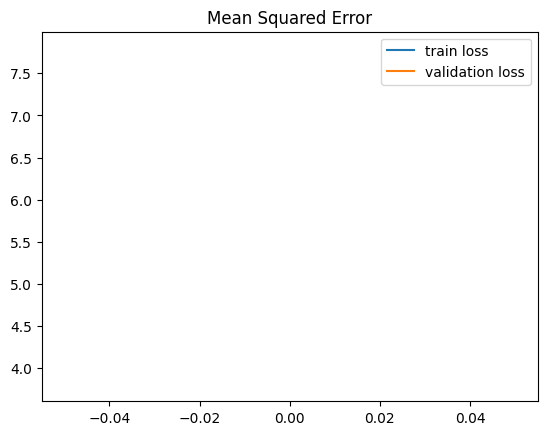

In [79]:
# Trainig
#build live matplotlib fig

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

LOAD_MODEL = True
if LOAD_MODEL:
    load_ckpt("{}/checkpoints/epoch_{}_batch_{}_ckpts.pt".format(os.getcwd(), 50, batch_size), model, optimizer)
lr = 0.1
scaler = torch.cuda.amp.GradScaler()
print(scaler)
best_val_loss = float('inf')
#writer = SummaryWriter("run/loss_plot")
step = 0


for epoch in tqdm(range(1, epochs+1)):
    print(f'Epoch #{epoch}')
    epoch_start_time = time.time()
    train_loss, sep_train_loss, train_pearsonr = train(model, train_dataloader, optimizer, scaler, None, step)
#     print(train_loss)
    train_losses.append(train_loss)
    sep_train_losses.append(sep_train_loss)
    mean_loss = sum(train_losses)/len(train_losses)
    val_loss, sep_val_loss, val_pearsonr = validate(model, val_dataloader)
    val_losses.append(val_loss)
    sep_val_losses.append(sep_val_loss)
    test_loss, sep_test_loss, test_pearsonr = validate(model, test_dataloader)
    test_losses.append(test_loss)
    sep_test_losses.append(sep_test_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'valid loss {val_loss:5.4f} | mean loss {mean_loss:8.4f}')
    print('-' * 89)
    ax.clear()
    ax.plot(mean_loss, label='train loss')
    ax.plot(val_loss.cpu(), label='validation loss')
    ax.set_title("Mean Squared Error")
    ax.legend()
    fig.canvas.draw()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # save model
#         save_ckpt("{}/checkpoints/epoch_{}_ckpts.pt".format(os.getcwd(), epoch), model, optimizer,epochs, val_loss)
        save_ckpt("{}/checkpoints".format(os.getcwd(), epoch), model, optimizer,epochs, train_losses, val_losses)

    # scheduler.step(mean_loss)
    scheduler.step()
# load_ckpt("/content/drive/MyDrive/checkpoints.pt", model, optimizer)


In [ ]:
sep_train_losses